# Оценка влияния изменения стоимости премиум-подписки при оплате через новые платежные системы на показатели дэйтингового приложения (A/B тест)

### Задание
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

### Содержание работы

0.	Предобработка данных, логические проверки
1.	Устранение «пробелов» в данных, обоснование принятых допущений
2.	Сегментация, общие характеристики пользователей
3.	Обработка результатов эксперимента, общие выводы
4.	Поиск групп клиентов, для которых нововведение имело бы смысл


### Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

#### users_*.csv – информация о пользователях:

uid – идентификатор пользователя

age – возраст

attraction_coeff – коэффициент привлекательности (от 0 до 1000, (лайки/просмотры)*1000

coins – число монеток (внутренняя валюта)

country – страна

visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

gender – пол

age_filter_start  – фильтр поиска, мин. значение 

age_filter_end  – фильтр поиска, макс. значение 

views_count – число полученных оценок 

was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)

is_premium –  является ли премиум

total_revenue – нормированная выручка
 
#### transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя

country – страна

joined_at – дата и время регистрации

paid_at – дата и время покупки

revenue – нормированная выручка

payment_id – идентификатор платежа

from_page – откуда пользователь перешел на страницу оплаты

product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

### Файлы:

users_test – информация о пользователях в тестовой группе. 

users_control_1 – информация о пользователях в первой контрольной группе. 

users_control_2 – информация о пользователях во второй контрольной группе . 

transactions_test – информация о платежах пользователей в тестовой группе. 

transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 

transactions_control_2 – информация о платежах пользователей во второй контрольной группе 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime as dt
import statsmodels.stats.api as sms
import scipy.stats as stats
import math
import gower
from sklearn.cluster import DBSCAN
import textwrap
import itertools
from tqdm.auto import tqdm
%matplotlib inline

In [2]:
users_test = pd.read_csv(r'C:\Users\Михаил\Desktop\Data analysis\Проекты\Tinder\users_test.csv', sep=';')
users_control_1 = pd.read_csv(r'C:\Users\Михаил\Desktop\Data analysis\Проекты\Tinder\users_control_1.csv', sep=';')
users_control_2 = pd.read_csv(r'C:\Users\Михаил\Desktop\Data analysis\Проекты\Tinder\users_control_2.csv', sep=';')

transactions_test = pd.read_csv(r'C:\Users\Михаил\Desktop\Data analysis\Проекты\Tinder\transactions_test.csv', 
                                sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_1 = pd.read_csv(r'C:\Users\Михаил\Desktop\Data analysis\Проекты\Tinder\transactions_control_1.csv', 
                                     sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_2 = pd.read_csv(r'C:\Users\Михаил\Desktop\Data analysis\Проекты\Tinder\transactions_control_2.csv',
                                     sep=';', parse_dates=['joined_at', 'paid_at'])

In [3]:
pd.set_option('display.max_columns',40)

Проверим соответствие столбцов в датафреймах и объединим все группы в единые датафреймы для удобства дальнейшей предобработки данных.

In [4]:
all([all(users_test.columns == users_control_1.columns), all(users_control_1.columns == users_control_2.columns)])

True

In [5]:
all([all(transactions_test.columns == transactions_control_1.columns), 
     all(transactions_control_1.columns == transactions_control_2.columns)])

True

In [6]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'
users = pd.concat([users_test, users_control_1, users_control_2], ignore_index=True)

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             170 non-null    float64
 4   country           12912 non-null  object 
 5   visit_days        8894 non-null   object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       1255 non-null   float64
 11  is_premium        540 non-null    float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.4+ MB


In [8]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], ignore_index=True)

In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           978 non-null    float64       
 1   country       978 non-null    object        
 2   joined_at     978 non-null    datetime64[ns]
 3   paid_at       978 non-null    datetime64[ns]
 4   revenue       978 non-null    float64       
 5   payment_id    978 non-null    float64       
 6   from_page     978 non-null    object        
 7   product_type  978 non-null    object        
 8   group         1608 non-null   object        
dtypes: datetime64[ns](2), float64(3), object(4)
memory usage: 113.2+ KB


In [10]:
transactions = transactions.dropna(thresh=8)

In [11]:
(transactions.uid - round(transactions.uid)).value_counts()

0.0    978
Name: uid, dtype: int64

In [12]:
(transactions.payment_id - round(transactions.payment_id)).value_counts()

0.0    978
Name: payment_id, dtype: int64

In [13]:
transactions = transactions.astype({'uid':'int','payment_id':'int'})

In [14]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           978 non-null    int32         
 1   country       978 non-null    object        
 2   joined_at     978 non-null    datetime64[ns]
 3   paid_at       978 non-null    datetime64[ns]
 4   revenue       978 non-null    float64       
 5   payment_id    978 non-null    int32         
 6   from_page     978 non-null    object        
 7   product_type  978 non-null    object        
 8   group         978 non-null    object        
dtypes: datetime64[ns](2), float64(1), int32(2), object(4)
memory usage: 68.8+ KB


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12912 entries, 0 to 12911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               12912 non-null  int64  
 1   age               12912 non-null  int64  
 2   attraction_coeff  12912 non-null  int64  
 3   coins             170 non-null    float64
 4   country           12912 non-null  object 
 5   visit_days        8894 non-null   object 
 6   gender            12912 non-null  int64  
 7   age_filter_start  12912 non-null  int64  
 8   age_filter_end    12912 non-null  int64  
 9   views_count       12912 non-null  int64  
 10  was_premium       1255 non-null   float64
 11  is_premium        540 non-null    float64
 12  total_revenue     12912 non-null  int64  
 13  group             12912 non-null  object 
dtypes: float64(3), int64(8), object(3)
memory usage: 1.4+ MB


Проверим датасеты на наличие дубликатов.

In [16]:
users.shape[0]

12912

In [17]:
users.drop_duplicates().shape[0]

12912

In [18]:
transactions.shape[0]

978

In [19]:
transactions.drop_duplicates().shape[0]

945

Есть дубликаты в платежах, посмотрим на них

In [20]:
transactions_dupl = transactions[transactions.duplicated(keep=False)].sort_values(list(transactions.columns))
transactions_dupl['number'] = transactions_dupl.groupby(list(transactions_dupl.columns)).cumcount() + 1
transactions_dupl.head(10)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,number
614,891252072,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19,empty_likes,coins,control_1,1
617,891252072,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19,empty_likes,coins,control_1,2
500,891320916,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67,empty_likes,other_type,control_1,1
574,891320916,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67,empty_likes,other_type,control_1,2
295,891365490,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19,empty_likes,coins,control_1,1
506,891365490,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19,empty_likes,coins,control_1,2
530,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127,sympathy,other_type,control_1,1
571,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127,sympathy,other_type,control_1,2
581,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127,sympathy,other_type,control_1,3
304,891367521,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19,sympathy,other_type,control_1,1


Стоит отметить, что наши данные по времени платежей детализированы только до минут, поэтому мы не можем знать, совпали ли все параметры платежей с точностью до секунды.

In [21]:
transactions_dupl[transactions_dupl.number == transactions_dupl.number.max()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,number
581,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456.0,127,sympathy,other_type,control_1,3
583,892102893,United States of America,2017-10-21 02:51:00,2017-10-22 23:00:00,6305.0,19,empty_likes,coins,control_1,3
442,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67,menu,other_type,control_1,3
471,892333905,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67,empty_admins,other_type,control_1,3


Максимальное количество полных дубликатов равно 3. Совершить 3 платежа в минуту не кажется сверхзадачей.

In [22]:
transactions_dupl.product_type.value_counts()

coins         41
other_type    21
Name: product_type, dtype: int64

Среди дублирующихся платежей отсутствуют платежи по оплате подписок. 

Оснований для исключения дублирующихся платежей нет. Однако, в будущем было бы неплохо получать данные, детализированные до секунд, чтобы не строить лишних предположений.

Проверим соответствие периодов проведения эксперимента в трех группах:

In [23]:
transactions.groupby('group').agg({'joined_at':['min', 'max']}).T

group                   control_1           control_2                test
joined_at min 2015-01-19 11:49:00 2017-01-11 08:36:00 2017-01-11 03:07:00
          max 2017-10-31 22:17:00 2017-10-31 17:43:00 2017-10-31 23:40:00

In [24]:
transactions.groupby('group').agg({'paid_at':['min', 'max']}).T

group                 control_1           control_2                test
paid_at min 2016-12-14 16:16:00 2017-01-11 05:34:00 2017-01-11 04:37:00
        max 2017-12-11 21:57:00 2017-12-11 23:28:00 2017-12-11 22:06:00

In [25]:
transactions[(transactions.joined_at < '2017-01-11') | (transactions.paid_at < '2017-01-11')]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
338,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0,refund_VP,other_type,control_1
374,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0,refung_AP,other_type,control_1
497,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0,refund_WP,other_type,control_1


In [26]:
transactions.query('uid == 960936960')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
338,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0,refund_VP,other_type,control_1
374,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0,refung_AP,other_type,control_1
497,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0,refund_WP,other_type,control_1


In [27]:
users.query('uid == 960936960')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
4818,960936960,30,4,99958.0,Russian Federation,"1,2,3,4,7,8,9,10,11,14,15,16,17,18,21,22,23,24...",1,26,62,4262,1.0,1.0,26,control_1


Всего 3 записи о транзакциях до 11.01.2017, все они принадлежат одному пользователю. Его данные необходимо исключить для соблюдения методологии эксперимента.

In [28]:
transactions.shape[0]

978

In [29]:
transactions = transactions[transactions.uid != 960936960]

In [30]:
transactions.shape[0]

975

In [31]:
users.shape[0]

12912

In [32]:
users = users[users.uid != 960936960]

In [33]:
users.shape[0]

12911

In [34]:
transactions.groupby('group').agg({'joined_at':['min', 'max']}).T

group                   control_1           control_2                test
joined_at min 2017-01-11 01:06:00 2017-01-11 08:36:00 2017-01-11 03:07:00
          max 2017-10-31 22:17:00 2017-10-31 17:43:00 2017-10-31 23:40:00

In [35]:
transactions.groupby('group').agg({'paid_at':['min', 'max']}).T

group                 control_1           control_2                test
paid_at min 2017-01-11 02:56:00 2017-01-11 05:34:00 2017-01-11 04:37:00
        max 2017-12-11 21:57:00 2017-12-11 23:28:00 2017-12-11 22:06:00

Получается эксперимент проводился для новых пользователей, зарегистрированных и оплативших подписку в период с 11.01.2017 по 11.12.2017 - 11 месяцев (!). 

Это очень затянувшийся эксперимент, проверим даты на правильность конвертации. 

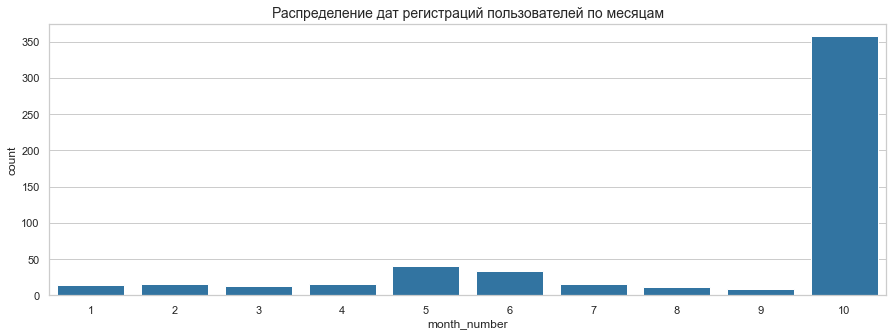

In [36]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(15,5))
sns.countplot(data = transactions.drop_duplicates(subset='uid'), 
              x = transactions.drop_duplicates(subset='uid').joined_at.dt.month, color='tab:blue')
plt.title('Распределение дат регистраций пользователей по месяцам', fontsize=14)
plt.xlabel('month_number')
plt.show()

Большая часть пользователей зарегистрировалась в октябре. Рассмотрим в каких числах этого месяца регистрировались пользователи

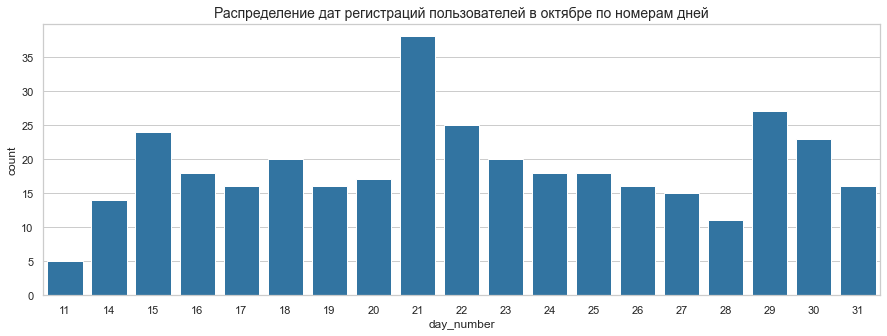

In [37]:
data=transactions.drop_duplicates(subset='uid')
plt.figure(figsize=(15,5))
sns.countplot(data = data[data.joined_at.dt.month == 10], 
              x = data[data.joined_at.dt.month == 10].joined_at.dt.day, color='tab:blue')
plt.title('Распределение дат регистраций пользователей в октябре по номерам дней', fontsize=14)
plt.xlabel('day_number')
plt.show()

Числа октября начинаются с 11.

Рассмотрим числа регистраций всего датасета 

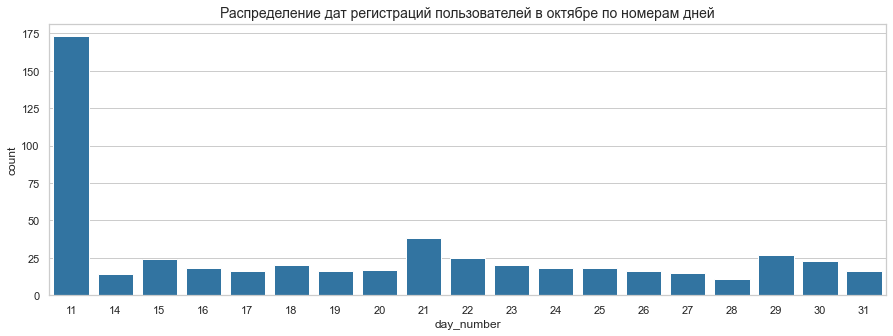

In [38]:
data=transactions.drop_duplicates(subset='uid')
plt.figure(figsize=(15,5))
sns.countplot(data = data, x = data.joined_at.dt.day, color='tab:blue')
plt.title('Распределение дат регистраций пользователей в октябре по номерам дней', fontsize=14)
plt.xlabel('day_number')
plt.show()

Отсутствуют числа от 1 до 10, аномально много 11 чисел. Возможно, это должен быть месяц, а не день.

Расссмотрим все варианты чисел регистраций до октября. 

In [39]:
transactions.drop_duplicates(subset='uid').query('joined_at < @pd.to_datetime("2017-10-01")')\
.joined_at.dt.day.value_counts()

11    168
Name: joined_at, dtype: int64

До октября во всех 9 месяцах только 11 числа, видимо, произошла ошибка при конвертации дат ноября.

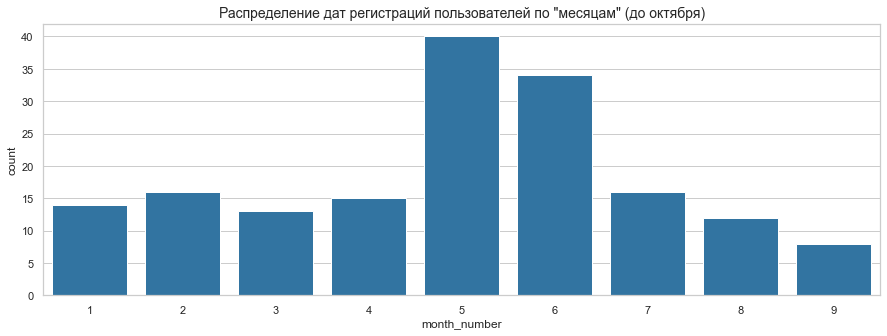

In [40]:
data=transactions.drop_duplicates(subset='uid')
plt.figure(figsize=(15,5))
sns.countplot(data=data.query('joined_at < @pd.to_datetime("2017-10-01")'), 
              x=data.query('joined_at < @pd.to_datetime("2017-10-01")').joined_at.dt.month, color='tab:blue')
plt.title('Распределение дат регистраций пользователей по "месяцам" (до октября)', fontsize=14)
plt.xlabel('month_number')
plt.show()

Числа "потенциального" ноября начинаются с 1 и заканчиваются 9. Вместе с диапазоном с 11 по 31 октября получается ровно 4 недели эксперимента.

Это выглядит убедительнее, чем 11-месячный эксперимент, в котором 10 из 11 месяцев новые пользователи регистрируются исключительно 11 числа.

Рассмотрим распределение дат в колонке дат платежей (paid_at).

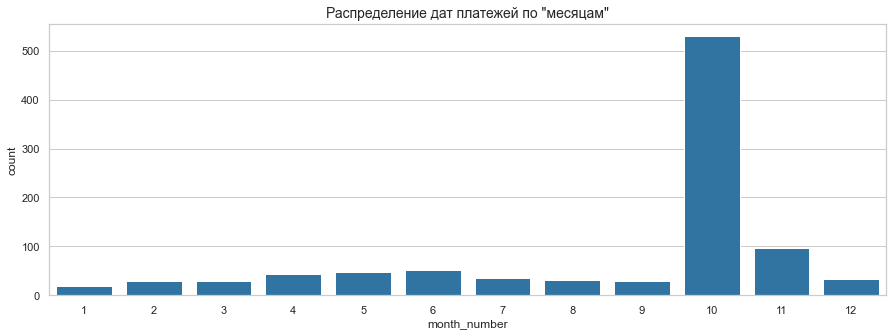

In [41]:
plt.figure(figsize=(15,5))
sns.countplot(data = transactions, x = transactions.paid_at.dt.month, color='tab:blue')
plt.title('Распределение дат платежей по "месяцам"', fontsize=14)
plt.xlabel('month_number')
plt.show()

Похоже такая же картина с датам платежей, проведем аналогичные проверки.

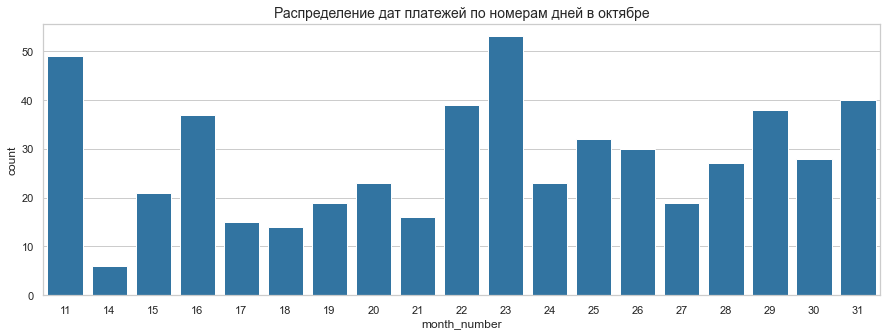

In [42]:
plt.figure(figsize=(15,5))
sns.countplot(data = transactions[transactions.paid_at.dt.month == 10], 
              x = transactions[transactions.paid_at.dt.month == 10].paid_at.dt.day, color='tab:blue')
plt.title('Распределение дат платежей по номерам дней в октябре', fontsize=14)
plt.xlabel('month_number')
plt.show()

Числа октября также начинаются с 11.

Также отдельно рассмотрим ноябрь и декабрь.

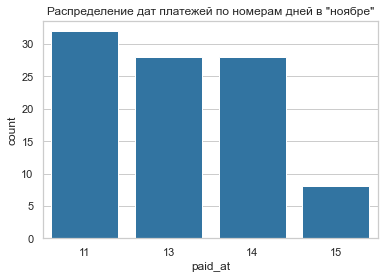

In [43]:
sns.countplot(data = transactions[transactions.paid_at.dt.month == 11], 
              x = transactions[transactions.paid_at.dt.month == 11].paid_at.dt.day, color='tab:blue')
plt.title('Распределение дат платежей по номерам дней в "ноябре"', fontsize=12)
plt.show()

In [44]:
transactions[transactions.paid_at.dt.month == 12].paid_at.dt.day.value_counts().sort_index()

11    34
Name: paid_at, dtype: int64

В ноябре отсутствуют платежи 12 числа, а в декабре только 11 число. Скорее всего 11-ое декабря должно быть 12-ым ноября.

Рассмотрим числа платежей всего датасета.

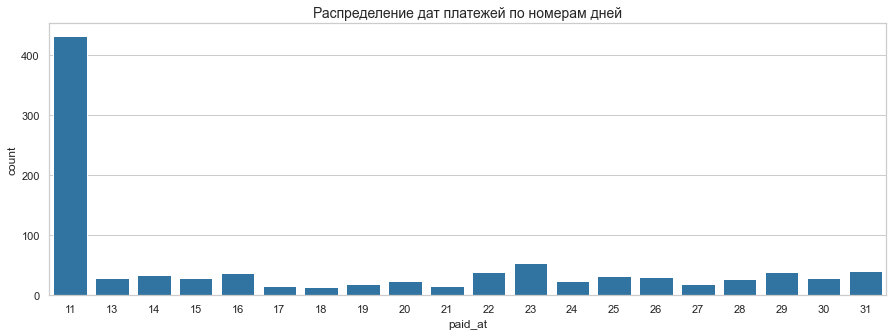

In [45]:
plt.figure(figsize=(15,5))
sns.countplot(data=transactions, x=transactions.paid_at.dt.day, color='tab:blue')
plt.title('Распределение дат платежей по номерам дней', fontsize=14)
plt.show()

Аналогично отсутствуют числа от 1 до 10, аномально много 11 чисел.

Расссмотрим все варианты чисел регистраций до октября. 

In [46]:
transactions.query('paid_at < @pd.to_datetime("2017-10-01")').paid_at.dt.day.value_counts()

11    316
Name: paid_at, dtype: int64

Числа в ноябре и декабре рассматривали выше. Произошла аналогичная ошибка при конвертации дат.

Меясяца в датах до октября являются числами ноября: 

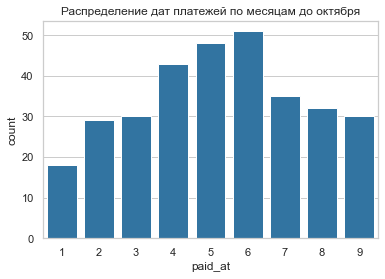

In [47]:
sns.countplot(data=transactions.query('paid_at < @pd.to_datetime("2017-10-01")'), 
              x=transactions.query('paid_at < @pd.to_datetime("2017-10-01")').paid_at.dt.month, color='tab:blue')
plt.title('Распределение дат платежей по месяцам до октября')
plt.show()

Числа "потенциального" ноября начинаются с 1 и заканчиваются 9, в самом ноябре уже есть числа 11,13-15, в декабре только 11. Вместе с диапазоном с 11 по 31 октября получается ранее полученный диапазон регистраций новых пользователей плюс несколько дней для платежной активности пользователей, зарегистрированных в последие дни диапазона для регистраций. Не хватает только сведений по 10 числу для ноября, скорее всего, часть данных за 11 октября конвертировалась некорректно. Рассмотрим этот вариант далее, пока конвертируем то, что очевидно некорректно.

In [48]:
transactions.joined_at = transactions.joined_at.apply(lambda x: 
                                                      pd.to_datetime(dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) 
                                                      if x.month != 10 else x)
transactions.joined_at.dt.month.value_counts().sort_index()

10    703
11    272
Name: joined_at, dtype: int64

In [49]:
transactions.paid_at = transactions.paid_at.apply(lambda x: 
                                                      pd.to_datetime(dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) 
                                                      if x.month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 12] else x)
transactions.paid_at.dt.month.value_counts().sort_index()

10    529
11    446
Name: paid_at, dtype: int64

Рассмотрим получившееся распределение количества регистраций и платежей по дням.

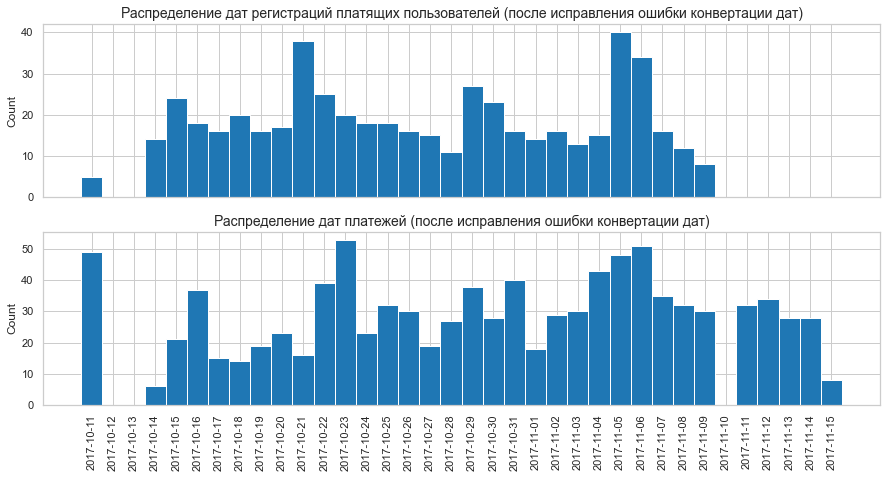

In [50]:
data=transactions.drop_duplicates(subset='uid')
bins = (transactions.paid_at.max() - transactions.joined_at.min()).days +1
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
sns.histplot(data=data,x=data.joined_at.dt.date, bins=bins, ax=ax[0], color='tab:blue', alpha=1)\
.set_title('Распределение дат регистраций платящих пользователей (после исправления ошибки конвертации дат)',
           fontsize=14)
plt.xlabel('')
sns.histplot(data=transactions,x=transactions.paid_at.dt.date, bins=bins, ax=ax[1], color='tab:blue', alpha=1)\
.set_title('Распределение дат платежей (после исправления ошибки конвертации дат)',
           fontsize=14)
plt.xlabel('')
plt.xticks(pd.date_range(transactions.joined_at.min().date(),transactions.paid_at.max().date()), rotation=90)
plt.show()

В распределении по дням бросается в глаза небольшое количество регистраций 11 октября и при этом кратно большее количество оплат в этот день. 10 ноября оплаты отсутствуют, также пустое окно 12 и 13 октября. 

Похоже действительно часть регистраций и оплат перетекла с 10 ноября на 11 октября из-за ошибки конвертации дат. Возможно даже все действия с 11 октября должны перетечь на 10 ноября и эксперимент вообще начался 14 октября.

Чтобы установить ошибочность данных по 11 октября, рассмотрим разность дат оплаты и регистрации и установим дни, в которые оплата произошла раньше регистрации.

In [51]:
transactions[transactions.paid_at - transactions.joined_at < '0 days'].paid_at.dt.date.value_counts()

2017-10-11    47
Name: paid_at, dtype: int64

Все 47 таких платежей произошли в 1 день - 11 октября. Значит, на самом деле они совершены 10 ноября.

Поправим данные.

In [52]:
transactions.paid_at = transactions.apply(lambda x: pd.to_datetime(dt.datetime.strftime(x.paid_at, '%Y-%d-%m %H:%M:%S'))
                           if x.paid_at - x.joined_at < dt.timedelta(0)
                           else x.paid_at,1)

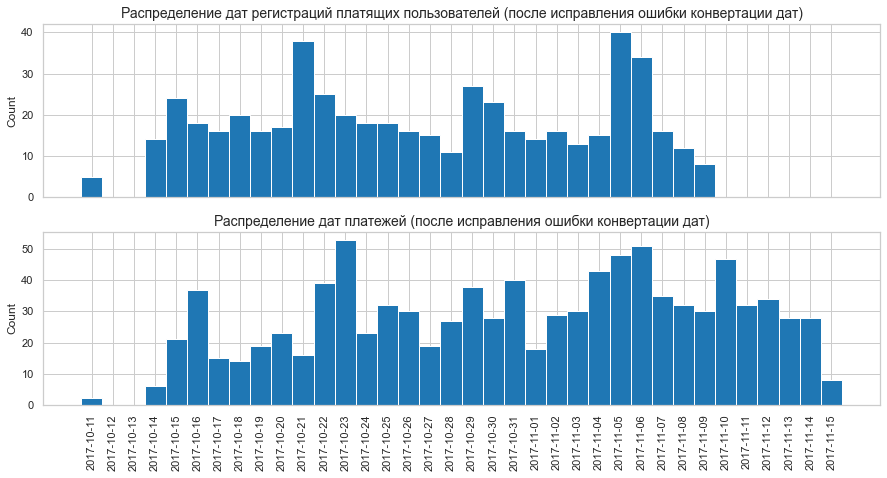

In [53]:
data=transactions.drop_duplicates(subset='uid')
bins = (transactions.paid_at.max() - transactions.joined_at.min()).days +1
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
sns.histplot(data=data,x=data.joined_at.dt.date, bins=bins, ax=ax[0], color='tab:blue', alpha=1)\
.set_title('Распределение дат регистраций платящих пользователей (после исправления ошибки конвертации дат)',
           fontsize=14)
plt.xlabel('')
sns.histplot(data=transactions,x=transactions.paid_at.dt.date, bins=bins, ax=ax[1], color='tab:blue', alpha=1)\
.set_title('Распределение дат платежей (после исправления ошибки конвертации дат)',
           fontsize=14)
plt.xlabel('')
plt.xticks(pd.date_range(transactions.joined_at.min().date(),transactions.paid_at.max().date()), rotation=90)
plt.show()

In [54]:
(transactions.paid_at - transactions.joined_at < '0 days').sum()

0

Рассмотрим первые платежи клиентов, зарегистрировавшихся 11 октября.

In [55]:
transactions.query('joined_at < @pd.to_datetime("2017-10-14")').sort_values(['uid','paid_at'])\
.drop_duplicates(subset='uid').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
1324,891077727,Argentina,2017-10-11 06:38:00,2017-10-11 16:33:00,6292.0,147,left_sidebar_menu,premium_no_trial,control_2
22,891071157,United States of America,2017-10-11 10:20:00,2017-10-11 16:37:00,9100.0,147,promo_09,premium_no_trial,test
1328,891068079,Argentina,2017-10-11 11:45:00,2017-11-11 04:20:00,4004.0,146,empty_likes,coins,control_2
1332,891080040,Israel,2017-10-11 04:59:00,2017-11-12 11:40:00,3783.0,67,empty_likes,other_type,control_2
1469,891075072,United States of America,2017-10-11 08:23:00,2017-11-14 21:44:00,2327.0,67,empty_likes,other_type,control_2


Всего в этот день было зарегистрировано 5 пользователей, 2 из них произвели первый платеж в эту же дату, остальные через месяц. Конвертация даты регистрации на 10 ноября возможна по всем пользователям, с учетом аналогичной конвертации даты платежей по пользователям, совершившим платеж день-в-день.

Принимая во внимание пустые окна в датах регистрации, которые будут устранены при данном варианте, получаемую в этом случае продолжительность эксперимента - ровно месяц с 2017-10-14 по 2017-11-15, и прочие косвенные признаки, внесем соответствующие изменения в поля дат.

In [56]:
transactions.joined_at = \
transactions.apply(lambda x: pd.to_datetime(dt.datetime.strftime(x.joined_at, '%Y-%d-%m %H:%M:%S'))
                           if str(x.joined_at)[:10] == '2017-10-11'
                           else x.joined_at,1)
transactions.paid_at = \
transactions.apply(lambda x: pd.to_datetime(dt.datetime.strftime(x.paid_at, '%Y-%d-%m %H:%M:%S'))
                           if str(x.paid_at)[:10] == '2017-10-11'
                           else x.paid_at,1)

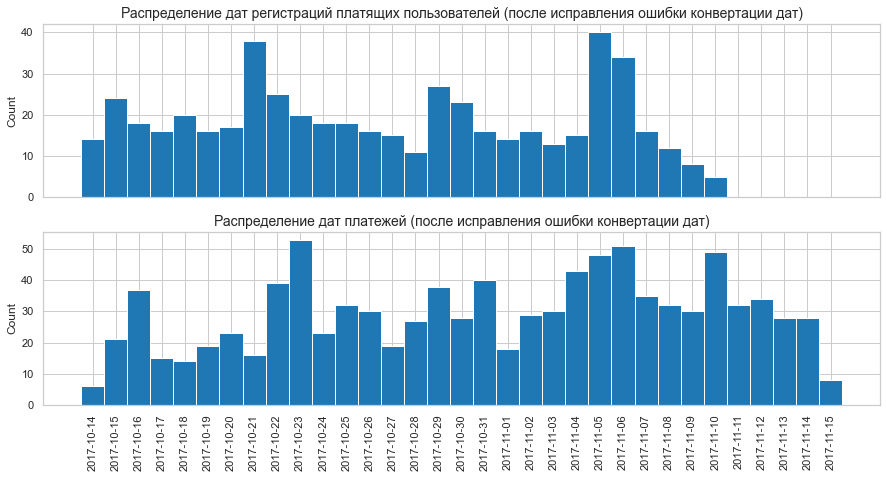

In [57]:
data=transactions.drop_duplicates(subset='uid')
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
sns.histplot(data=data,x=data.joined_at.dt.date, ax=ax[0], color='tab:blue', alpha=1)\
.set_title('Распределение дат регистраций платящих пользователей (после исправления ошибки конвертации дат)',
           fontsize=14)
plt.xlabel('')
sns.histplot(data=transactions,x=transactions.paid_at.dt.date, ax=ax[1], color='tab:blue', alpha=1)\
.set_title('Распределение дат платежей (после исправления ошибки конвертации дат)',
           fontsize=14)
plt.xlabel('')
plt.xticks(pd.date_range(transactions.joined_at.min().date(),transactions.paid_at.max().date()), rotation=90)
plt.show()

In [58]:
(transactions.paid_at - transactions.joined_at < '0 days').sum()

0

In [59]:
pd.concat([transactions.agg({'joined_at':['min', 'max']}), transactions.agg({'paid_at':['min', 'max']})], axis=1)

,joined_at,paid_at
min,2017-10-14 00:54:00,2017-10-14 02:57:00
max,2017-11-10 11:45:00,2017-11-15 09:31:00


Ошибки в датах исправлены. Эксперимент стартовал 14 октября, регистрации клиентов в рамках эксперимента закончились 10 ноября, и было дано еще 5 дней до 15 ноября на совершение платежей клиентам, зарегистрировавшимся в последние дни окна регистраций.

Проверим соответствие uid в данных по пользователям и платежам по группам. Все пользователи из транзакций определенной группы должны быть в данных о пользователях этой группы, при этом их не должно быть в данных по пользователям других групп.

In [60]:
def is_in(tran_group, users_group):
    p = pd.DataFrame(transactions.loc[transactions.group == tran_group, 'uid'].reset_index(drop=True))
    s = users.loc[users.group == users_group, ['uid','country']].reset_index(drop=True)
    if p.merge(s, how='left', on='uid').country.isna().sum() == 0:
        return 'входит полностью'
    elif p.merge(s, how='left', on='uid').country.isna().sum() == p.shape[0]:
        return 'полностью не входит'
    else:
        return 'нет данных'

In [61]:
groups = list(users.group.unique())
permutations = list(zip(groups, groups)) + list(itertools.permutations(groups, 2))
users_group = []
tran_group = []
for i in range(len(permutations)):
    users_group.append(permutations[i][0])
    tran_group.append(permutations[i][1])
    i+=1
s = pd.DataFrame({'tran_group': tran_group, 'users_group': users_group})
s['is_in'] = s.apply(lambda x: is_in(x.tran_group, x.users_group), 1)
s

,tran_group,users_group,is_in
0,test,test,входит полностью
1,control_1,control_1,входит полностью
2,control_2,control_2,входит полностью
3,control_1,test,полностью не входит
4,control_2,test,полностью не входит
5,test,control_1,полностью не входит
6,control_2,control_1,полностью не входит
7,test,control_2,полностью не входит
8,control_1,control_2,полностью не входит


Все сходится.

Сверим данные по платежам с данными по доходу пользователей (total_revenue).

In [62]:
users.total_revenue.sum() == transactions.revenue.sum()

False

In [63]:
s = transactions.groupby('uid', as_index=False).agg({'revenue':'sum'})\
.rename(columns={'revenue':'total_revenue_tran'})\
.merge(users.loc[:,['uid', 'total_revenue']], on='uid')
diff = s[s.total_revenue_tran != s.total_revenue]
diff

,uid,total_revenue_tran,total_revenue
465,892275462,58968.0,14885
495,892355163,30264.0,0


По двум пользователям не сошлись показатели. Приведем показатель total_revenue по всем пользователям в соответствие с данными транзакций, так как по логике транзакции - первоисточник данных для расчета общего дохода. 

In [64]:
users = users.merge(s.iloc[:,[0,1]], how='left', on='uid')
users.total_revenue = users.total_revenue_tran.fillna(0)
users = users.drop(columns='total_revenue_tran')
users[users.uid.isin(diff.uid)][['uid','total_revenue']]

,uid,total_revenue
2070,892275462,58968.0
7677,892355163,30264.0


In [65]:
users.total_revenue.sum() == transactions.revenue.sum()

True

Также сверим данные в колонках is_premuim и was_premium, далее сопоставим их c платежами

In [66]:
users.query('is_premium == 1').was_premium.value_counts(dropna=False)

1.0    539
Name: was_premium, dtype: int64

In [67]:
users.query('was_premium == 1').is_premium.value_counts(dropna=False)

NaN    715
1.0    539
Name: is_premium, dtype: int64

Признак was_premium включает все строки с признаком is_premium. От премиум-подписки отказалось 715 клиентов из 1254 когда-либо ее оформивших (по предварительным данным).

Теперь сопоставим признаки is_premium и was_premium с платежами.

In [68]:
u = users.query('was_premium == 1').loc[:,['uid','was_premium','group']]
t = transactions[transactions.product_type.str.contains('premium')].loc[:,['uid','country']]\
.drop_duplicates(subset='uid')
(u.shape[0], u.merge(t, how='left', on='uid').country.isna().sum()), \
(t.shape[0], t.merge(u, how='left', on='uid').was_premium.isna().sum())

((1254, 806), (448, 0))

По большинству клиентов в таблице users, имеющих признак was_premium, нет данных о соответствующих платежах в таблице transactions (806 из 1254). 

При этом по всем 448 клиентам, имеющим сведения об оплате пробной или полной премиум-подписки в таблице transactions, есть признак was_premium в таблице users.

Выделим в отдельную таблицу клиентов с признаком was_premium и отсутствием данных о транзакциях по покупке пробной или полной премиум-подписки и исследуем их.

In [69]:
s = u.merge(t, how='left', on='uid')
empty_premium_users = users[users.uid.isin(s[s.country.isna()].uid.unique())]

В условии сказано, что признак was_premium означает "был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)". Таким образом предполагается, что пробная премиум-подписка является бесплатной.

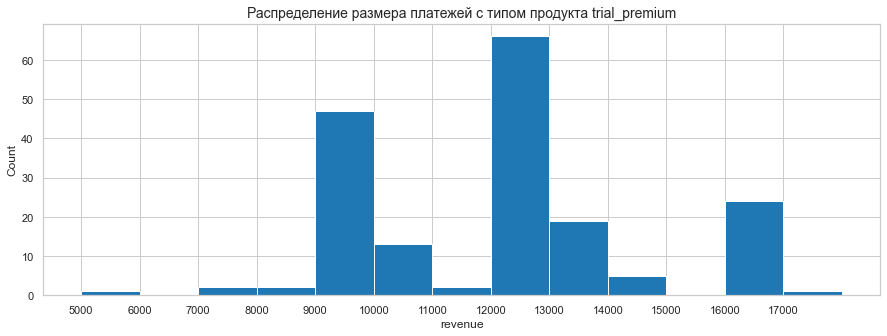

In [70]:
s = transactions.query('product_type == "trial_premium"')
plt.figure(figsize=(15,5))
ax=sns.histplot(data=s, x='revenue',color='tab:blue', binwidth=1000, binrange=(5000,18000), alpha=1)
ax.set_title('Распределение размера платежей с типом продукта trial_premium', fontsize=14)
plt.xticks(range(5000,18000,1000))
plt.show()

In [71]:
transactions.query('product_type == "trial_premium"').shape[0]

182

In [72]:
transactions.query('product_type == "trial_premium"').uid.nunique()

181

При этом в таблице transactions есть 182 платежа, совершенных 181 клиентом, по продукту trial_premium.

In [73]:
s = transactions.query('product_type == "trial_premium"')
s[s.duplicated(subset='uid', keep=False)]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
107,891297711,Spain,2017-11-06 01:35:00,2017-11-13 03:46:00,12818.0,147,trial_vip_popup,trial_premium,test
181,891297711,Spain,2017-11-06 01:35:00,2017-11-13 03:42:00,12818.0,147,autoreply_message,trial_premium,test


Клиент 891297711 оплатил пробную премиум-подписку дважды с интервалом в 4 минуты с разных страниц перехода. Спасибо, ждем вас снова!

In [74]:
transactions.query('product_type == "trial_premium"').revenue.apply(['min','max'])

min     5577.0
max    17199.0
Name: revenue, dtype: float64

Минимальный платеж составляет 5577 у.е., максимальный - 17199 у.е. Наиболее часто встречаются суммы платежей: 

In [75]:
transactions.query('product_type == "trial_premium"').revenue.value_counts().head()

12727.0    36
9087.0     30
13247.0     6
12766.0     5
12818.0     5
Name: revenue, dtype: int64

Таким образом, принимая во внимание ранее установленное равенство показателей суммарного дохода по всем транзакциям платящих клиентов и суммарного дохода, указанного в массиве с характеристиками пользователей, можно предположить, что большая часть пробных подписок (806) была бесплатной. Однако, также есть 181 пользователь, оплативший пробную подписку. Попробуем найти различия между этими группами пользователей, чтобы установить причины данного несоответствия.

In [76]:
round(empty_premium_users.country.value_counts(normalize=True).mul(100),1).head().apply(str) + '%'

United States of America    47.3%
Spain                        7.2%
United Arab Emirates         6.0%
France                       5.8%
Italy                        5.6%
Name: country, dtype: object

In [77]:
proved_trial_premium_users = users[users.uid.isin(transactions.query('product_type == "trial_premium"').uid)]
round(proved_trial_premium_users.country.value_counts(normalize=True).mul(100),1).head().apply(str) + '%'

United States of America    40.3%
France                      11.0%
Spain                        6.6%
Argentina                    5.5%
Belgium                      5.5%
Name: country, dtype: object

По региональному признаку видимых различий нет.

In [78]:
round(empty_premium_users.gender.value_counts(normalize=True).mul(100), 1).apply(str) + '%'

1    97.0%
0     3.0%
Name: gender, dtype: object

In [79]:
round(proved_trial_premium_users.gender.value_counts(normalize=True).mul(100), 1).apply(str) + '%'

1    96.1%
0     3.9%
Name: gender, dtype: object

По полу также пропорции примерно одинаковые.

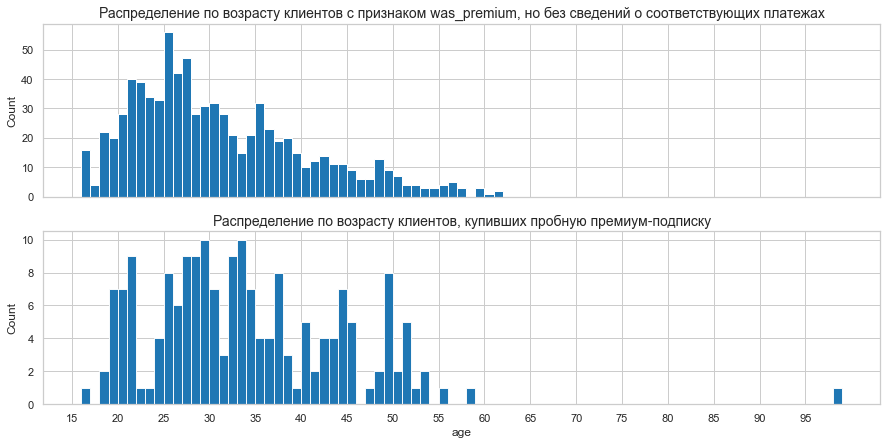

In [80]:
fig, ax = plt.subplots(2,1,figsize=(15,7), sharex=True)
sns.histplot(empty_premium_users.age, ax=ax[0], color='tab:blue', alpha=1, binwidth=1)\
.set_title('Распределение по возрасту клиентов с признаком was_premium, но без сведений о соответствующих платежах',
           fontsize=14)
sns.histplot(proved_trial_premium_users.age, ax=ax[1], color='tab:blue', alpha=1, binwidth=1)\
.set_title('Распределение по возрасту клиентов, купивших пробную премиум-подписку', fontsize=14)
plt.xticks(range(15,100,5))
plt.show()

Выраженная разница в распределении возрастов отсутствует. Проверка по другим параметрам (коэфф.привлекательности, диапазон выбора) нецелесообразна.

Единственная оставшаяся гипотеза, которая может быть частично проверена на имеющихся данных, что до какого-то момента времени подписка была бесплатной, затем стала платной, или наоборот. Данные о времени регистрации клиентов есть только в таблице платежей, там есть сведения по части клиентов с отсутствием платежей по пробной или полной премиум-подписке, так как они оплачивали прочие продукты:

In [81]:
transactions[transactions.uid.isin(list(empty_premium_users.uid))].uid.nunique()

46

Сравним распределение их дат регистрации с распределением дат регистрации пользователей, оплативших пробную премиум-подписку.

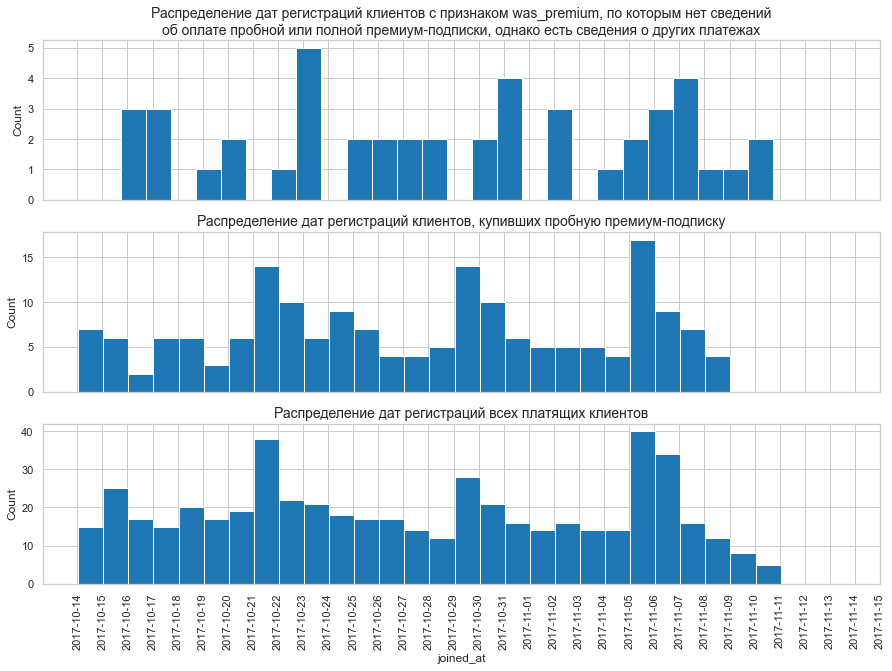

In [82]:
xticks = pd.date_range(transactions.paid_at.min().date(),transactions.paid_at.max().date())
fig, ax = plt.subplots(3,1,figsize=(15,10), sharex=True)
sns.histplot(transactions[transactions.uid.isin(list(empty_premium_users.uid))]
             .drop_duplicates(subset='uid').joined_at, ax=ax[0], color='tab:blue', alpha=1, binwidth=1)\
             .set_title(textwrap.fill('Распределение дат регистраций клиентов с признаком was_premium, по которым нет \
сведений об оплате пробной или полной премиум-подписки, однако есть сведения о других платежах', width=88,
                      break_long_words=False), fontsize=14)
sns.histplot(transactions[transactions.uid.isin(list(proved_trial_premium_users.uid))]
             .drop_duplicates(subset='uid').joined_at, ax=ax[1], color='tab:blue', alpha=1, binwidth=1)\
             .set_title('Распределение дат регистраций клиентов, купивших пробную премиум-подписку', fontsize=14)
sns.histplot(transactions.drop_duplicates(subset='uid').joined_at, ax=ax[2], color='tab:blue', alpha=1, binwidth=1)\
             .set_title('Распределение дат регистраций всех платящих клиентов', fontsize=14)
plt.xticks(xticks, rotation=90)
plt.show()

Явных различий в периодах регистраций нет. Также следует заметить, что у нас нет оснований полагать, что пользователи, по которым нет данных о совершенных платежах, а значит и дате регистрации, при этом есть признак was_premium, зарегистрированы до начала эксперимента и поэтому их платежи просто не учтены. Обратное подтверждается сведениями об общем доходе, не содержащим соответствующих сумм, а также частично данными о дате регистрации пользователей, совершившим транзакции по прочим продуктам.

Убедимся, что по данным 46 клиентам отсутствуют записи о транзакциях с ошибочным типом продукта, сопоставив распределение размеров платежей данных пользователей с распределением по размеру платежей пробной премиум-подписки.

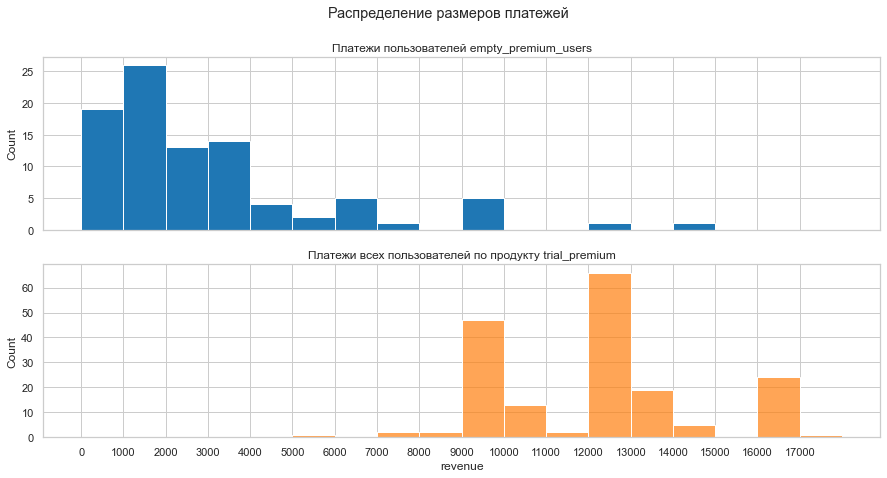

In [83]:
fig, ax = plt.subplots(2,1,figsize=(15,7), sharex=True)
plt.suptitle('Распределение размеров платежей')
sns.histplot(transactions[(transactions.uid.isin(list(empty_premium_users.uid))) &
                          (transactions.revenue < 20000)].revenue, ax=ax[0],
             color='tab:blue', alpha=1, binwidth=1000, binrange=(0,18000))\
                           .set_title('Платежи пользователей empty_premium_users')
sns.histplot(transactions.query('product_type == "trial_premium"').revenue, ax=ax[1],
             color='tab:orange', alpha=0.7, binwidth=1000, binrange=(0,18000))\
                           .set_title('Платежи всех пользователей по продукту trial_premium')
plt.xticks(range(0,18000,1000))
plt.show()

Сопоставление графиков распределений позволяет сделать вывод об отсутствии сходства в размерах платежей по большей части 96 платежей 46 указанных пользователей. Значит причина не в ошибочно проставленных типах продукта по транзакциям этих пользователей.

Также возможной причиной отсутствия платежей по премиум-подписке могла быть оплата подписки за купленные ранее coins (допустим наличие такой опции в приложении). Такое могло быть по клиентам, которые имеют платежи по типам продукта coins и other_type (так как нам неизвестно, что это за продукт, возможно, тоже что-то наподобие coins). Таких пользователей всего 46 из 806.

Ранее было установлено, что минимальная цена пробной премиум-подписки равна 5577 у.е. Посмотрим сколько из этих 46 пользователей могли бы претендовать на покупку пробной премиум-подписки по показателю общего дохода, который в их случае складывается как раз из оплат coins и other_type.

In [84]:
empty_premium_users.query('total_revenue >= 5577').shape[0]

19

Такой вариант был бы возможен максимум для 19 пользователей. Однако, принимая во внимание их долю от всех 806 таких пользователей и отсутствие других подтверждений данного предположения, не будем далее развивать эту версию.

In [85]:
empty_premium_users.is_premium.value_counts(dropna=False)

NaN    684
1.0    122
Name: is_premium, dtype: int64

Среди пользователей с признаком was_premium и отсутствием сведений о транзакциях, связанных с пробной или полной премиум-подпиской, есть 122 пользователя с признаком is_premium, что также не поддается логике.

На основании имеющихся данных и их описания в условии задания, можно предположить, что клиенты с признаком was_premium (is_premium) и отсутствием каких-либо сведений о соответствующих платежах в таблице transactions, получили пробную премиум-подписку бесплатно во время эксперимента. Однако, также вероятно, это ошибка в признаках, поэтому в дальнейшем анализе, определяя клиентов, оформивших подписку, будем полагаться на данные платежей, так как сведения о них мэтчатся в обоих массивах.

In [86]:
empty_premium_users.group.value_counts()

test         281
control_1    269
control_2    256
Name: group, dtype: int64

Количество таких клиентов по группам примерно одинаково. Перейдем к следующим проверкам.

Рассмотрим распределение всех клиентов по количеству платежей.

In [87]:
s = round(transactions.groupby('uid', as_index=False).agg({'paid_at': 'count'})\
.rename(columns={'paid_at': '% of users'})['% of users'].value_counts(normalize=True).mul(100), 2)\
.reset_index().rename(columns={'index':'pay_count'})
s['cum %'] = s['% of users'].cumsum()
s

,pay_count,% of users,cum %
0,1,66.29,66.29
1,2,14.10,80.39
2,3,10.10,90.49
3,4,4.19,94.68
4,5,1.33,96.01
5,6,1.14,97.15
6,10,0.76,97.91
7,9,0.76,98.67
8,11,0.38,99.05
9,7,0.38,99.43


Две трети платящих пользователей совершали только 1 платеж, 90.5% платящих пользователей совершали до 3 платежей.

Посмотрим, какое максимальное количество транзакций приходится на одного платящего клиента:

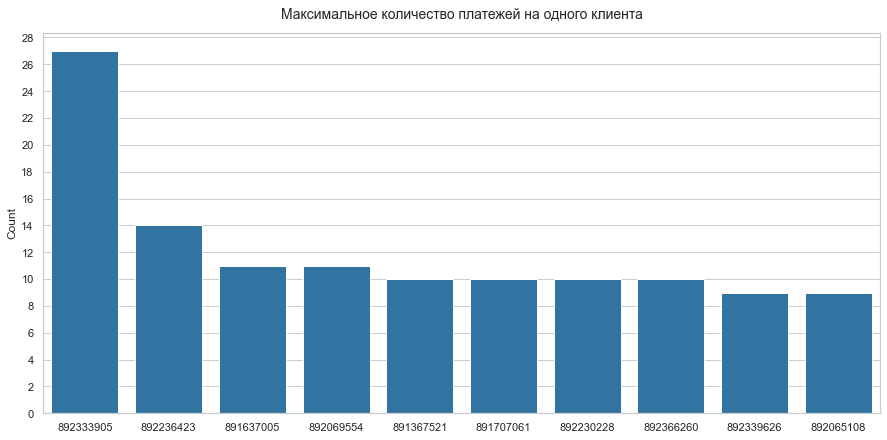

In [88]:
data = transactions.groupby('uid', as_index=False).agg({'paid_at': 'count'})\
.sort_values('paid_at', ascending=False).reset_index(drop=True).rename(columns={'paid_at': 'paid_at_count'}).head(10)
plt.figure(figsize=(15,7))
sns.barplot(data=data, x=data.index, y='paid_at_count', color='tab:blue', alpha=1).set_xticklabels(data.uid)
plt.yticks(range(0,29,2))
plt.ylabel('Count')
plt.title('Максимальное количество платежей на одного клиента', fontsize=14, pad=15)
plt.show()

У клиента 892333905 27 транзакций - это почти в 2 раза больше, чем у его ближайшего преследователя. Далее по списку убывание идет более плавно.

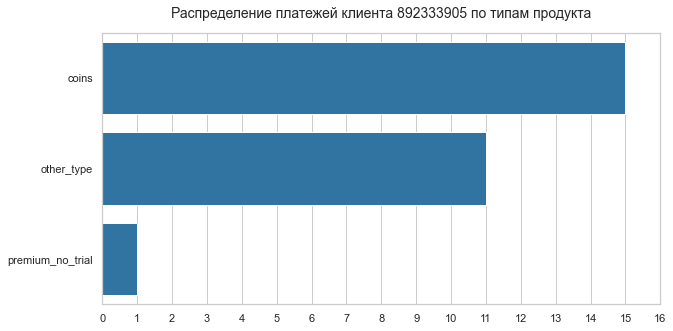

In [89]:
data = pd.DataFrame(transactions[transactions.uid == 892333905].product_type.value_counts())
plt.figure(figsize=(10,5))
sns.barplot(data=data, y=data.index, x='product_type', color='tab:blue', alpha=1)
plt.xticks(range(0,17,1))
plt.xlabel('')
plt.title('Распределение платежей клиента 892333905 по типам продукта', fontsize=14, pad=15)
plt.show()

Основную часть платежей этого клиента составляет оплата монет и прочих продуктов, подписка оплачена единожды.

Рассмотрим распределение платежей по времени по группам.

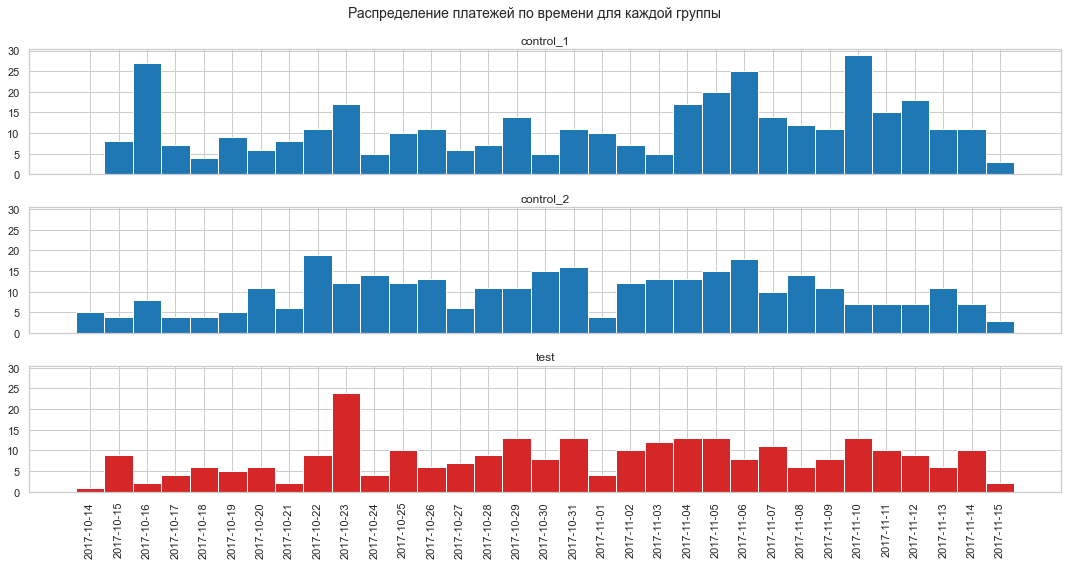

In [90]:
group = ["control_1","control_2","test"]
fig, ax = plt.subplots(3,1, figsize=(15,8), sharex=True, sharey=True)
fig.suptitle('Распределение платежей по времени для каждой группы', fontsize=14)
for i in range(3):
    data=transactions.query('group == @group[@i]')
    color='tab:blue'
    if group[i] == "test":
        color='tab:red'
    sns.histplot(data, x=data.paid_at.dt.date, ax = ax[i],color=color,alpha=1)
    ax[i].set_title(group[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.yticks(range(0,35,5))
xticks = pd.date_range(transactions.paid_at.min().date(),transactions.paid_at.max().date())
plt.xticks(xticks, rotation=90)
plt.tight_layout()
plt.show()

Распределение первой контрольной группы отличается от прочих большим количеством скачков кол-ва платежей, однако явные аномалии отсутствуют.

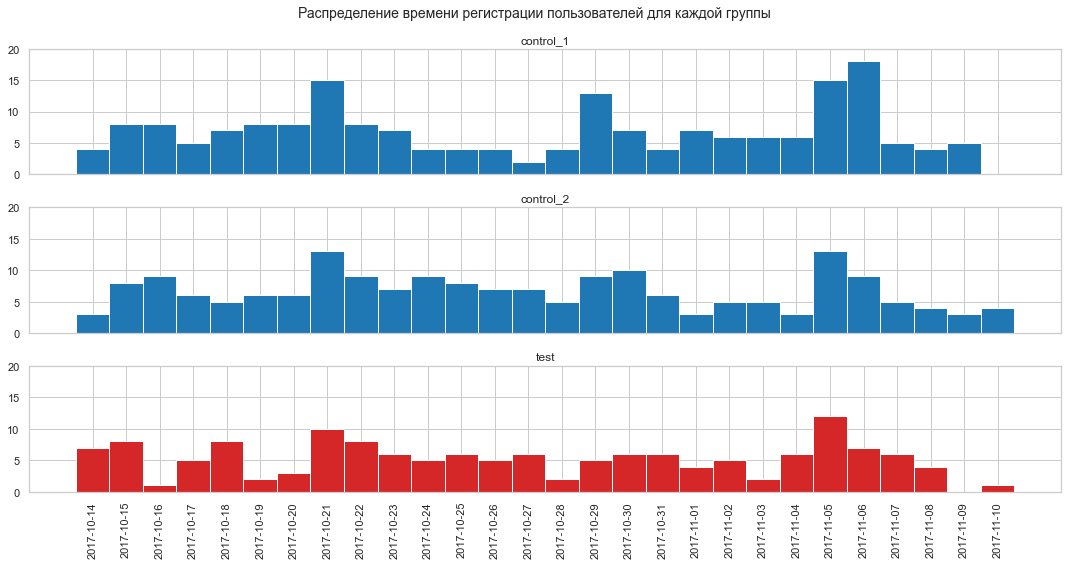

In [91]:
group = ["control_1","control_2","test"]
fig, ax = plt.subplots(3,1, figsize=(15,8), sharex=True, sharey=True)
fig.suptitle('Распределение времени регистрации пользователей для каждой группы', fontsize=14)
for i in range(3):
    data=transactions.drop_duplicates(subset='uid').query('group == @group[@i]')
    color='tab:blue'
    if group[i] == "test":
        color='tab:red'
    sns.histplot(data, x=data.joined_at.dt.date, ax = ax[i],color=color,alpha=1)
    ax[i].set_title(group[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.yticks(range(0,21,5))
xticks = pd.date_range(transactions.joined_at.min().date(), transactions.joined_at.max().date())
plt.xticks(xticks, rotation=90)
plt.tight_layout()
plt.show()

Явные аномалии также не обнаружены.

Рассмотрим распределение размеров платежей по продуктам.

In [92]:
transactions.product_type.value_counts()

coins               379
premium_no_trial    289
trial_premium       182
other_type          125
Name: product_type, dtype: int64

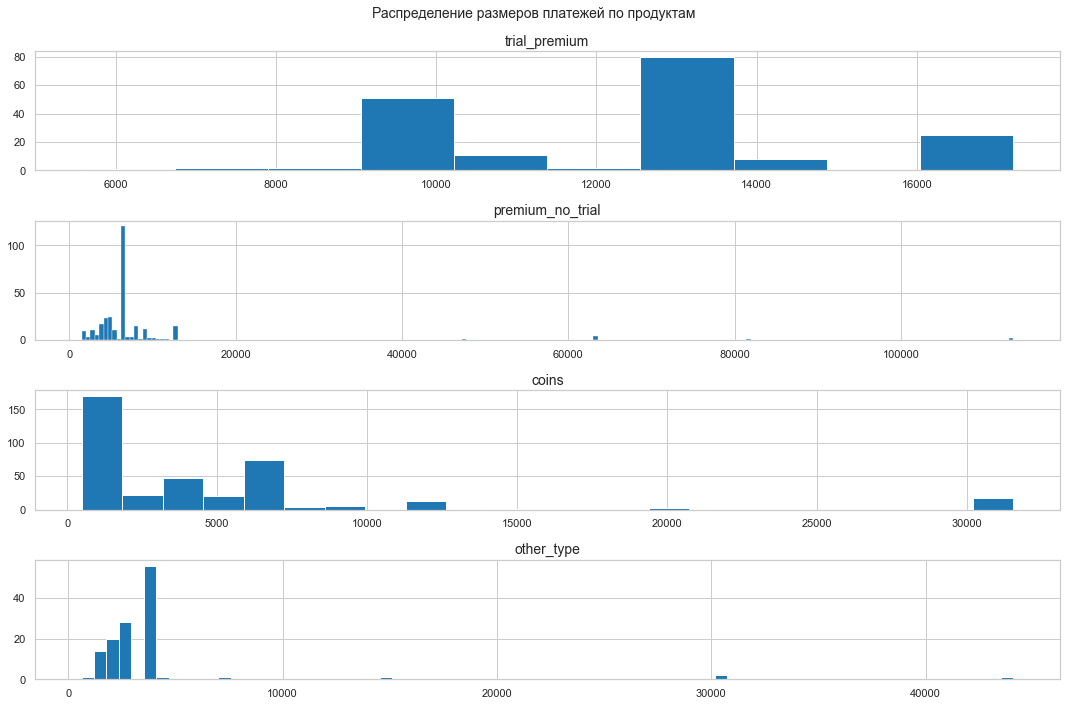

In [93]:
fig, ax = plt.subplots(4,1, figsize=(15,10))
fig.suptitle('Распределение размеров платежей по продуктам', fontsize=14)
products=['trial_premium','premium_no_trial','coins','other_type']
for i in range(4):
    sns.histplot(transactions[transactions.product_type == products[i]].revenue, ax = ax[i], color='tab:blue', alpha=1)
    ax[i].set_title(products[i], fontsize=14)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
fig.tight_layout(pad=1.15)
plt.show()

Заметны выбросы по платежам для оплаты подписки премиум, покупки монет, а также среди прочих платежей. Рассмотрим их отдельно по каждой из категорий.

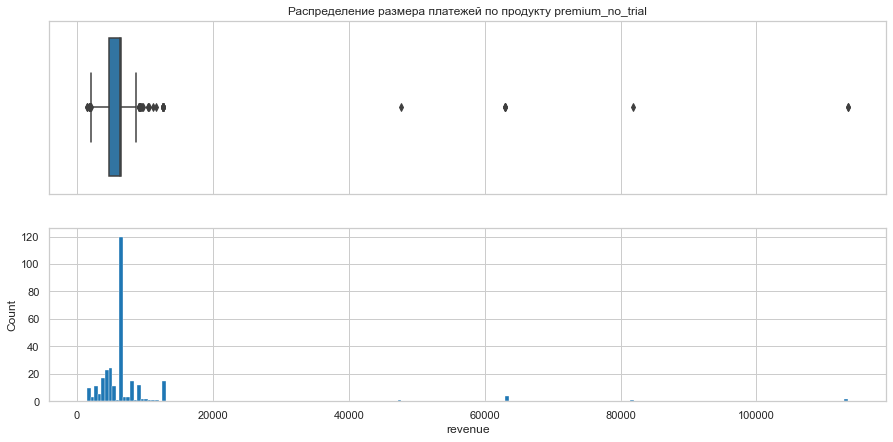

In [94]:
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
ax0 = sns.boxplot(data=transactions[transactions.product_type == 'premium_no_trial'], x='revenue', ax=ax[0],
                  color='tab:blue')
ax0.set_title('Распределение размера платежей по продукту premium_no_trial')
ax0.set_xlabel('')
sns.histplot(data=transactions[transactions.product_type == 'premium_no_trial'], x='revenue', ax=ax[1],
             color='tab:blue', alpha=1)
plt.show()

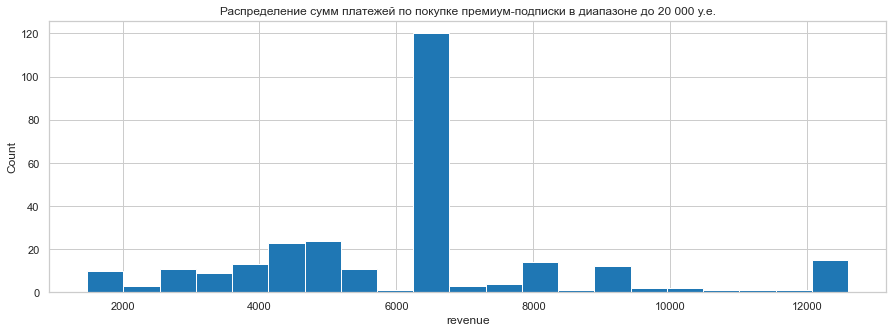

In [95]:
plt.figure(figsize=(15, 5))
sns.histplot(transactions[(transactions.product_type == 'premium_no_trial') &
                          (transactions.revenue < 20000)].revenue,color='tab:blue', alpha=1)
plt.title('Распределение сумм платежей по покупке премиум-подписки в диапазоне до 20 000 у.е.')
plt.show()

Основная доля платежей по покупке премиум-подписки лежит в диапазоне (0, 13 000) у.е. Далее приведены точные цифры

In [96]:
print('Количество платежей по оплате премиум-подписки размером до 20 000 у.е. составляет {} - это \
{}% всех аналогичных платежей)'
      .format(transactions[(transactions.product_type == 'premium_no_trial') 
                           & (transactions.revenue <= 20000)].revenue.count(),
              round(transactions[(transactions.product_type == 'premium_no_trial') 
                           & (transactions.revenue <= 20000)].revenue.count() *100/
                   transactions[transactions.product_type == 'premium_no_trial'].revenue.count(), 1)))
print('Максимальное значение платежа по покупке премиум-подписки в основной группе платежей составляет {} у.е.'\
      .format(transactions[(transactions.product_type == 'premium_no_trial') & (transactions.revenue <= 20000)]\
              .revenue.max()))

Количество платежей по оплате премиум-подписки размером до 20 000 у.е. составляет 281 - это 97.2% всех аналогичных платежей)
Максимальное значение платежа по покупке премиум-подписки в основной группе платежей составляет 12597.0 у.е.


Рассмотрим характеристики платежей свыше 12597.0 у.е., составляющих по количеству всего 2.8 % всех аналогичных платежей:

In [97]:
print('Минимальное значение платежа, превышающего 12597.0 у.е., составляет {} у.е., максимальное - {} у.е. \
      Всего таких платежей {}.'.format(transactions[(transactions.product_type == 'premium_no_trial') & 
                                                 (transactions.revenue > 12597)].revenue.min(),
                                    transactions[(transactions.product_type == 'premium_no_trial') & 
                                                 (transactions.revenue > 12597)].revenue.max(),
                                    transactions[(transactions.product_type == 'premium_no_trial') & 
                                                 (transactions.revenue > 12597)].shape[0]))

Минимальное значение платежа, превышающего 12597.0 у.е., составляет 47723.0 у.е., максимальное - 113477.0 у.е.       Всего таких платежей 8.


In [98]:
transactions[(transactions.product_type == 'premium_no_trial') & (transactions.revenue > 13000)]\
.sort_values('revenue', ascending=False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
12,891178380,Spain,2017-11-08 03:54:00,2017-11-09 21:53:00,113477.0,147,promo_09,premium_no_trial,test
196,892038759,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147,autoreply_message,premium_no_trial,test
1327,891778551,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147,left_sidebar_menu,premium_no_trial,control_2
416,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147,no_sympathy,premium_no_trial,control_1
550,892216461,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147,autoreply_message,premium_no_trial,control_1
590,891383310,Turkey,2017-11-04 20:47:00,2017-11-04 22:17:00,63037.0,147,autoreply_message,premium_no_trial,control_1
1302,892307238,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147,left_sidebar_menu,premium_no_trial,control_2
303,892421277,United States of America,2017-10-14 13:05:00,2017-10-15 13:11:00,47723.0,147,promo_09,premium_no_trial,control_1


Аномально высокие платежи по полной премиум-подписке встречаются во всех группах, однако оба платежа максимального размера относятся к тестовой группе.

Учитывая их малое количество, сильную разницу по размеру со значениями в основной группе платежей, а также отсутствие в условии информации о возможности предоплаты за несколько месяцев, необхоимо исключить данные пользователей, совершивших эти платежи из общего массива, чтобы получить достоверные результаты по генеральной совокупности пользователей.

In [99]:
transactions.shape[0]

975

In [100]:
s = transactions[(transactions.product_type == 'premium_no_trial') & (transactions.revenue > 13000)].uid
transactions_clean = transactions[transactions.uid.isin(s) == False]

In [101]:
transactions_clean.shape[0]

934

In [102]:
users.shape[0]

12911

In [103]:
users_clean = users[users.uid.isin(s) == False]

In [104]:
users_clean.shape[0]

12903

Рассмотрим платежи по продукту coins.

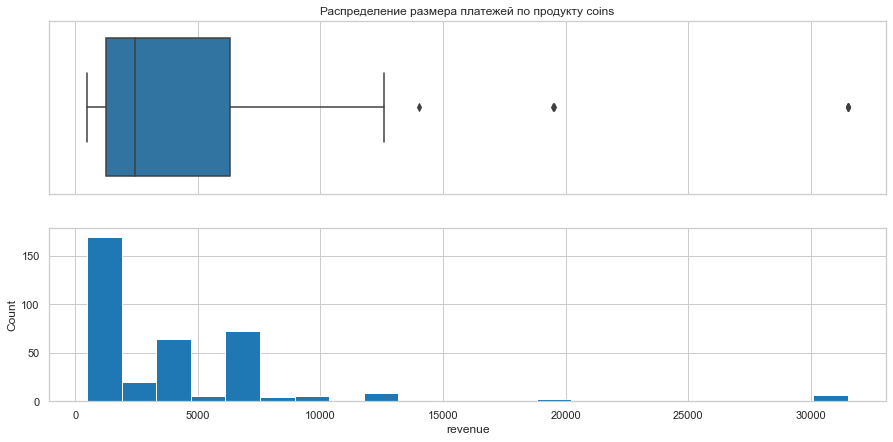

In [105]:
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
ax0 = sns.boxplot(data=transactions_clean[transactions_clean.product_type == 'coins'], x='revenue', ax=ax[0],
                  color='tab:blue')
ax0.set_title('Распределение размера платежей по продукту coins')
ax0.set_xlabel('')
sns.histplot(data=transactions_clean[transactions_clean.product_type == 'coins'], x='revenue', ax=ax[1],
             color='tab:blue', alpha=1)
plt.show()

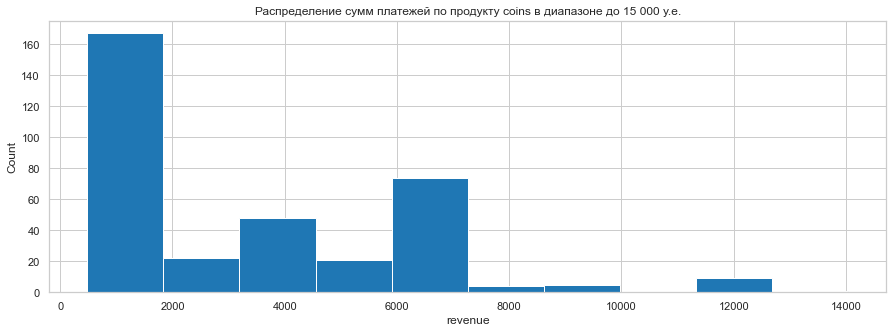

In [106]:
plt.figure(figsize=(15, 5))
sns.histplot(transactions_clean[(transactions_clean.product_type == 'coins') &
                                (transactions_clean.revenue < 15000)].revenue,
             color='tab:blue', alpha=1)
plt.title('Распределение сумм платежей по продукту coins в диапазоне до 15 000 у.е.')
plt.show()

Основная доля платежей по покупке монет лежит в диапазоне (0, 15 000) у.е. Далее приведены точные цифры

In [107]:
print('Количество платежей по оплате coins размером до 15 000 у.е. составляет {} - это \
{}% всех аналогичных платежей)'
      .format(transactions_clean[(transactions_clean.product_type == 'coins') 
                           & (transactions_clean.revenue <= 15000)].revenue.count(),
              round(transactions_clean[(transactions_clean.product_type == 'coins') 
                           & (transactions_clean.revenue <= 15000)].revenue.count() *100/
                   transactions_clean[transactions_clean.product_type == 'coins'].revenue.count(), 1)))
print('Максимальное значение платежа по покупке coins в основной группе платежей составляет {} у.е.'\
      .format(transactions_clean[(transactions_clean.product_type == 'coins') & (transactions_clean.revenue <= 15000)]\
              .revenue.max()))

Количество платежей по оплате coins размером до 15 000 у.е. составляет 351 - это 97.8% всех аналогичных платежей)
Максимальное значение платежа по покупке coins в основной группе платежей составляет 14040.0 у.е.


Рассмотрим характеристики платежей свыше 14040.0 у.е., составляющих по количеству всего 2.2 % всех аналогичных платежей:

In [108]:
print('Минимальное значение платежа, превышающего 14040.0 у.е., составляет {} у.е., максимальное - {} у.е. \
       Всего таких платежей {}.'.format(transactions_clean[(transactions_clean.product_type == 'coins') & 
                                                 (transactions_clean.revenue > 14040)].revenue.min(),
                                    transactions_clean[(transactions_clean.product_type == 'coins') & 
                                                 (transactions_clean.revenue > 14040)].revenue.max(),
                                    transactions_clean[(transactions_clean.product_type == 'coins') & 
                                                 (transactions_clean.revenue > 14040)].shape[0]))

Минимальное значение платежа, превышающего 14040.0 у.е., составляет 19500.0 у.е., максимальное - 31525.0 у.е.        Всего таких платежей 8.


In [109]:
transactions_clean[(transactions_clean.product_type == 'coins') & (transactions_clean.revenue > 14040)]\
.sort_values(['uid','revenue'], ascending=[True,False])

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
44,891346269,Argentina,2017-11-05 12:55:00,2017-11-07 11:28:00,31525.0,19,empty_likes,coins,test
202,891346269,Argentina,2017-11-05 12:55:00,2017-11-07 11:27:00,31525.0,19,empty_likes,coins,test
73,891654090,United States of America,2017-10-30 05:59:00,2017-10-31 05:50:00,19500.0,146,menu,coins,test
1377,891664350,Germany,2017-10-30 00:21:00,2017-11-03 02:57:00,19513.0,146,empty_likes,coins,control_2
169,891914619,United States of America,2017-10-24 23:12:00,2017-10-25 21:22:00,31525.0,19,empty_likes,coins,test
216,892150854,Argentina,2017-10-20 00:25:00,2017-10-30 02:14:00,31525.0,19,empty_likes,coins,test
81,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:14:00,31525.0,19,menu,coins,test
259,892248561,Germany,2017-10-17 20:06:00,2017-10-18 20:35:00,31525.0,19,empty_likes,coins,test


Большинство аномально высоких платежей по coins встречаются в тестовой группе (7 из 8), 6 из 7 указанных платежей - максимального размера.

Учитывая их малое количество, сильную разницу по размеру со значениями в основной группе платежей, необходимо исключить данные пользователей, совершивших эти платежи из общего массива, чтобы получить достоверные результаты по генеральной совокупности пользователей.

In [110]:
users_clean.shape[0]

12903

In [111]:
s = transactions_clean[(transactions_clean.product_type == 'coins') & (transactions_clean.revenue > 14040)].uid

In [112]:
transactions_clean.shape[0]

934

In [113]:
transactions_clean = transactions_clean[transactions_clean.uid.isin(s) == False]

In [114]:
transactions_clean.shape[0]

905

In [115]:
users_clean.shape[0]

12903

In [116]:
users_clean = users_clean[users_clean.uid.isin(s) == False]

In [117]:
users_clean.shape[0]

12896

Рассмотрим платежи по типу продукта other_type (прочие продукты).

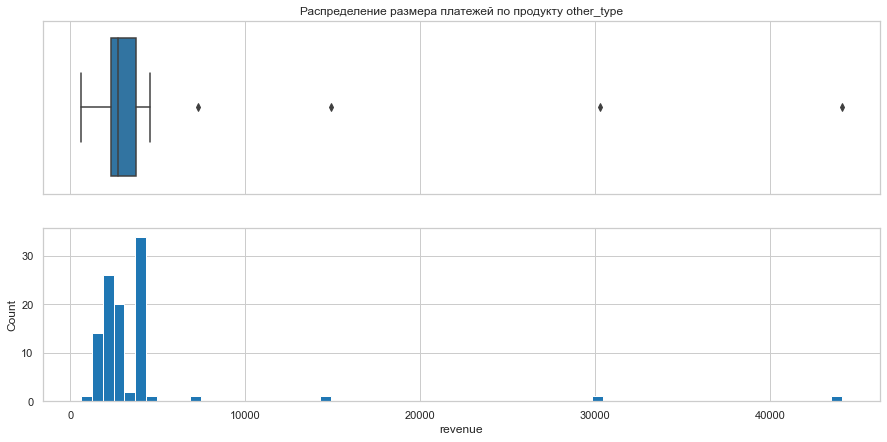

In [118]:
fig, ax = plt.subplots(2,1,figsize=(15,7),sharex=True)
ax0 = sns.boxplot(data=transactions_clean[transactions_clean.product_type == 'other_type'], x='revenue', ax=ax[0],
                  color='tab:blue')
ax0.set_title('Распределение размера платежей по продукту other_type')
ax0.set_xlabel('')
sns.histplot(data=transactions_clean[transactions_clean.product_type == 'other_type'], x='revenue', ax=ax[1],
            color='tab:blue',alpha=1)
plt.show()

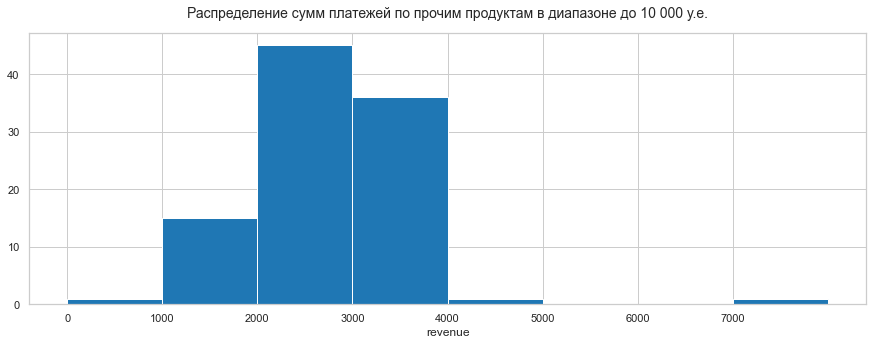

In [119]:
plt.figure(figsize=(15, 5))
sns.histplot(transactions_clean[(transactions_clean.product_type == 'other_type') & 
                                (transactions_clean.revenue < 10000)].revenue,
            color='tab:blue',alpha=1, binwidth=1000,binrange=(0,8000))
plt.title('Распределение сумм платежей по прочим продуктам в диапазоне до 10 000 у.е.', fontsize=14, pad=15)
plt.xticks(range(0,8000,1000))
plt.ylabel('')
plt.show()

Основная доля платежей по покупке премиум-подписки лежит в диапазоне (0, 10 000) у.е. Далее приведены точные цифры

In [120]:
print('Количество платежей по оплате продукта типа other_type размером до 15 000 у.е. составляет {} - это \
{}% всех аналогичных платежей)'
      .format(transactions_clean[(transactions_clean.product_type == 'other_type') 
                           & (transactions_clean.revenue <= 10000)].revenue.count(),
              round(transactions_clean[(transactions_clean.product_type == 'other_type') 
                           & (transactions_clean.revenue <= 10000)].revenue.count() *100/
                   transactions_clean[transactions_clean.product_type == 'other_type'].revenue.count(), 1)))
print('Максимальное значение платежа по покупке продукта типа other_type в основной группе платежей составляет {} у.е.'\
      .format(transactions_clean[(transactions_clean.product_type == 'other_type') & (transactions_clean.revenue <= 10000)]\
              .revenue.max()))

Количество платежей по оплате продукта типа other_type размером до 15 000 у.е. составляет 99 - это 97.1% всех аналогичных платежей)
Максимальное значение платежа по покупке продукта типа other_type в основной группе платежей составляет 7306.0 у.е.


Рассмотрим характеристики платежей свыше 7306.0  у.е., составляющих по количеству всего 3.6 % всех аналогичных платежей:

In [121]:
print('Минимальное значение платежа, превышающего 7306.0 у.е., составляет {} у.е., максимальное - {} у.е. \
        Всего таких платежей {}.'.format(transactions_clean[(transactions_clean.product_type == 'other_type') & 
                                                 (transactions_clean.revenue > 7306)].revenue.min(),
                                    transactions_clean[(transactions_clean.product_type == 'other_type') & 
                                                 (transactions_clean.revenue > 7306)].revenue.max(),
                                    transactions_clean[(transactions_clean.product_type == 'other_type') & 
                                                 (transactions_clean.revenue > 7306)].shape[0]))

Минимальное значение платежа, превышающего 7306.0 у.е., составляет 14885.0 у.е., максимальное - 44083.0 у.е.         Всего таких платежей 3.


In [122]:
transactions_clean[(transactions_clean.product_type == 'other_type') & (transactions_clean.revenue > 7306)]\
.sort_values(['uid','revenue'], ascending=[True,False])

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
64,892275462,France,2017-10-17 05:56:00,2017-11-02 18:24:00,44083.0,19,coins_popup,other_type,test
154,892275462,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885.0,68,super_popup,other_type,test
576,892355163,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68,super_popup,other_type,control_1


3 из 4 аномально высоких платежей по other_type встречаются в тестовой группе, при этом 2 из них принадлежат одному клиенту.

Учитывая их малое количество, сильную разницу по размеру со значениями в основной группе платежей, необхоимо исключить данные пользователей, совершивших эти платежи из общего массива, чтобы получить достоверные результаты по генеральной совокупности пользователей.

In [123]:
s = transactions_clean[(transactions_clean.product_type == 'other_type') & (transactions_clean.revenue > 7306)].uid

In [124]:
transactions_clean.shape[0]

905

In [125]:
transactions_clean = transactions_clean[transactions_clean.uid.isin(s) == False]

In [126]:
transactions_clean.shape[0]

902

In [127]:
users_clean.shape[0]

12896

In [128]:
users_clean = users_clean[users_clean.uid.isin(s) == False]

In [129]:
users_clean.shape[0]

12894

По итогам отчистки датасетов от выбросов по размеру платежа по каждому продукту были получчены следующие показатели.

Количество клиентов в первичном и очищенном датасетах по группам:

In [130]:
s = pd.DataFrame({'group':['test','control_1','control_2']})
u = pd.DataFrame(users.group.value_counts()).reset_index().rename(columns={'index':'group', 'group':'users'})
uc = pd.DataFrame(users_clean.group.value_counts()).reset_index().rename(columns={'index':'group', 'group':'users_clean'})
s = s.merge(u,on='group').merge(uc, on='group')
s = s.append(s.sum(numeric_only=True), ignore_index=True)
s.iloc[3,0] = 'SUM'
s['%'] = round(s.users_clean *100 / s.users,1)
s.style.format({'users':'{:.0f}', 'users_clean':'{:.0f}', '%':'{:.1f}'})

,group,users,users_clean,%
0,test,4308,4299,99.8
1,control_1,4339,4334,99.9
2,control_2,4264,4261,99.9
3,SUM,12911,12894,99.9


Количество платящих клиентов в первичном и очищенном датасетах по группам:

In [131]:
s = pd.DataFrame({'group':['test','control_1','control_2']})
u = pd.DataFrame(users.query('total_revenue > 0').group.value_counts()).reset_index().rename(columns={'index':'group', 'group':'users'})
uc = pd.DataFrame(users_clean.query('total_revenue > 0').group.value_counts()).reset_index().rename(columns={'index':'group', 'group':'users_clean'})
s = s.merge(u,on='group').merge(uc, on='group')
s = s.append(s.sum(numeric_only=True), ignore_index=True)
s.iloc[3,0] = 'SUM'
s['%'] = round(s.users_clean *100 / s.users,1)
s.style.format({'users':'{:.0f}', 'users_clean':'{:.0f}', '%':'{:.1f}'})

,group,users,users_clean,%
0,test,146,137,93.8
1,control_1,192,187,97.4
2,control_2,187,184,98.4
3,SUM,525,508,96.8


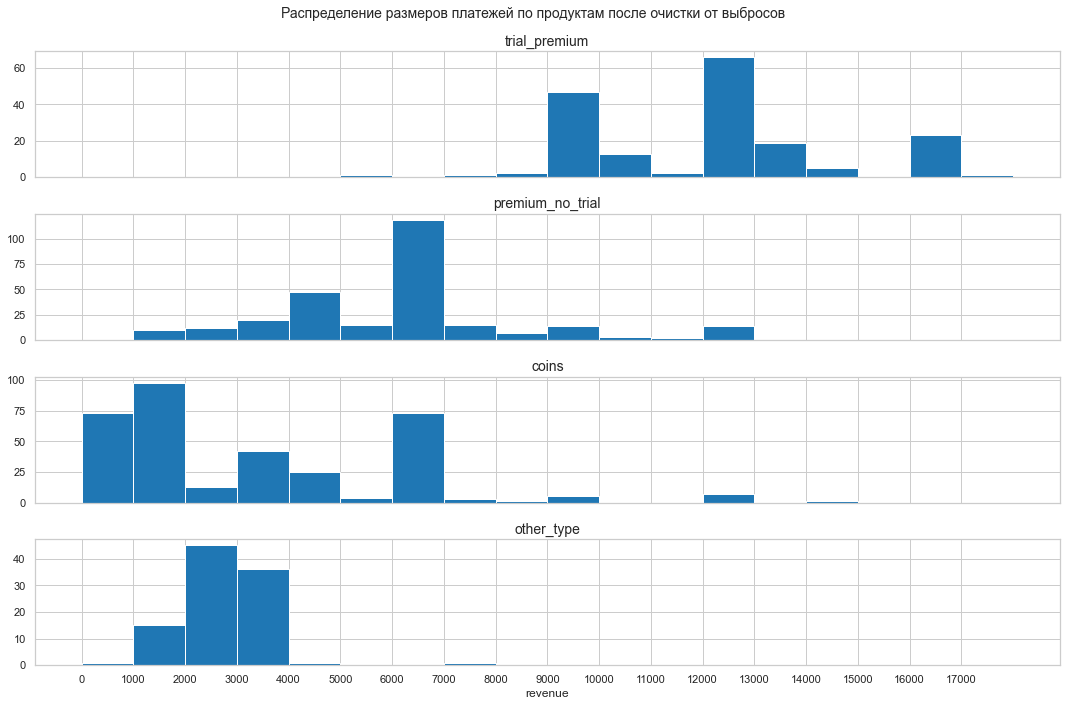

In [132]:
fig, ax = plt.subplots(4,1, figsize=(15,10), sharex=True)
fig.suptitle('Распределение размеров платежей по продуктам после очистки от выбросов', fontsize=14)
products=['trial_premium','premium_no_trial','coins','other_type']
for i in range(4):
    sns.histplot(transactions_clean[transactions_clean.product_type == products[i]].revenue, ax = ax[i],
                     color='tab:blue', alpha=1, binwidth=1000, binrange=(0,18000))
    ax[i].set_title(products[i], fontsize=14)
    ax[i].set_ylabel('')
plt.xticks(range(0,18000,1000))
fig.tight_layout(pad=1.15)
plt.show()

На получившемся распределении размеров платежей по продуктам есть вопросы по соотношению распределений стоимости пробной и полной премиум-подписки.

In [133]:
transactions_clean.groupby('product_type', as_index=False).agg({'revenue':['count','mean', 'std']}).droplevel(0,1)\
.rename(columns={'':'product_type'})\
.query('product_type == "premium_no_trial" or product_type == "trial_premium"').round(2)

,product_type,count,mean,std
2,premium_no_trial,278,6118.65,2325.44
3,trial_premium,180,12185.12,2454.24


Средняя величина пробной премиум-подписки в 2 раза превосходит среднюю величину полной премиум-подписки при практически равном стандартном отклонении и достаточном количестве платежей по обоим продуктам.

Причины данного логического несоответствия могут быть в ценовой политике сервиса или в ошибке в данных. 

In [134]:
transactions_clean.query('product_type in ["trial_premium","premium_no_trial"]').sort_values('paid_at')\
.drop_duplicates(subset=['uid','product_type']).pivot(index='uid',columns='product_type',values='paid_at')\
.reset_index().dropna()

product_type,uid,premium_no_trial,trial_premium
301,892065108,2017-11-08 22:45:00,2017-11-11 03:28:00


In [135]:
transactions_clean.query('product_type in ["trial_premium","premium_no_trial"]').sort_values('paid_at')\
.drop_duplicates(subset=['uid','product_type']).pivot(index='uid',columns='product_type',values='revenue')\
.reset_index().dropna()

product_type,uid,premium_no_trial,trial_premium
301,892065108,7098.0,12454.0


Только 1 пользователь за месяц эксперимента приобрел и пробную, и полную премуим-подписку. Причем сначала полную за 7098 у.е., а через пару дней пробную по цене 12454 у.е., профит! Пробная подписка была оплачена в субботу в 3:28.

Посмотрим на информацию о данном пользователи и на все его платежи.

In [136]:
users_clean.query('uid == 892065108')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
2642,892065108,99,475,72.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,2...",1,16,41,187,1.0,1.0,47242.0,test


In [137]:
transactions_clean.query('uid == 892065108').sort_values('paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
38,892065108,France,2017-10-21 20:40:00,2017-11-08 22:45:00,7098.0,147,popular_users_chat,premium_no_trial,test
185,892065108,France,2017-10-21 20:40:00,2017-11-09 10:45:00,7098.0,147,popular_users_chat,premium_no_trial,test
213,892065108,France,2017-10-21 20:40:00,2017-11-10 15:24:00,7111.0,147,popular_users_chat,premium_no_trial,test
114,892065108,France,2017-10-21 20:40:00,2017-11-10 15:26:00,871.0,146,menu,coins,test
71,892065108,France,2017-10-21 20:40:00,2017-11-10 15:27:00,871.0,19,menu,coins,test
175,892065108,France,2017-10-21 20:40:00,2017-11-10 15:27:00,3913.0,19,menu,coins,test
141,892065108,France,2017-10-21 20:40:00,2017-11-11 03:28:00,12454.0,147,popular_users_chat,trial_premium,test
52,892065108,France,2017-10-21 20:40:00,2017-11-12 02:10:00,3913.0,19,menu,coins,test
180,892065108,France,2017-10-21 20:40:00,2017-11-12 02:11:00,3913.0,19,menu,coins,test


Это довольно активный пользователь приложения, судя по частоте посещений и количеству покупок. Он зарегистрировался 21 октября в субботу вечером, затем почти три недели ежедневно заходил в приложение, далее в течение трех дней с 8 по 10 ноября купил сразу три(!) полных (месячных) премиум-подписки, докупил несколько лотов монет, на следующий день 11 ноября купил дорогую пробную подписку, и 12 ноября зафиксировал прибыль еще двумя лотами монет.

Щедро! Наверное, теперь он популярен у противоположного пола... Но это уже совсем другая история.

Факт в том, что его покупки в целом довольно импульсивны и не поддаются рациональной логике, поэтому он вполне мог купить дорогой пробный премиум после покупки трех полных премиумов в течение нескольких дней.

Ввиду отсутствия других данных, будем считать, что по ценам пробной и полной подписок так и задумано.

## 1. Устранение «пробелов» в данных, обоснование принятых допущений

В описании данных нет расшифровки по полу, он указан в виде 0 и 1. 

Пол - это один из ключевых социально-демографических параметров для описания групп клиентов и формирования дальнейших рекомендаций, тем более в дейтинговом приложении. За неимением других источников далее установим по косвенным показателям, к какому из полов относятся цифровые обозначения.

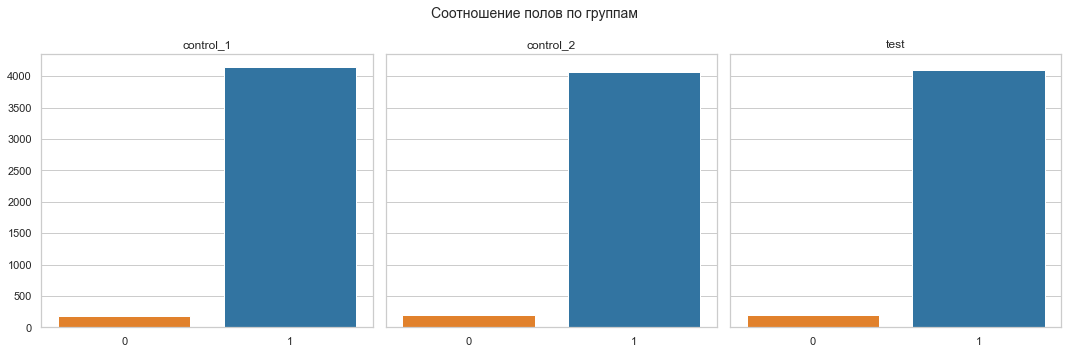

In [138]:
group=['control_1','control_2','test']
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey=True)
plt.suptitle('Соотношение полов по группам', fontsize=14)
for i in range(len(group)):
    sns.countplot(data = users_clean[users_clean.group == group[i]], x = 'gender', ax = ax[i],
                  palette=['tab:orange','tab:blue'])
    ax[i].set_title(group[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
plt.tight_layout()

In [139]:
s = pd.DataFrame({'gender':[0,1]})
for group in ['test', 'control_1', 'control_2']:
    s1 = users_clean[users_clean.group == group].groupby('gender', as_index=False).agg({'uid':'count'})\
    .rename(columns={'uid':group})
    s1[group+'%'] = round(s1[group] *100 / s1[group].sum(), 1)
    s = s.merge(s1, how='left', on='gender')
s

,gender,test,test%,control_1,control_1%,control_2,control_2%
0,0,202,4.7,182,4.2,195,4.6
1,1,4097,95.3,4152,95.8,4066,95.4


Во всех группах основную часть пользователей составляют представители пола 1.

Далее рассмотрим соотношение возраста пользователей и средней величины диапазона возраста выбора. Возможно там мы найдем характерные паттерны для полов.

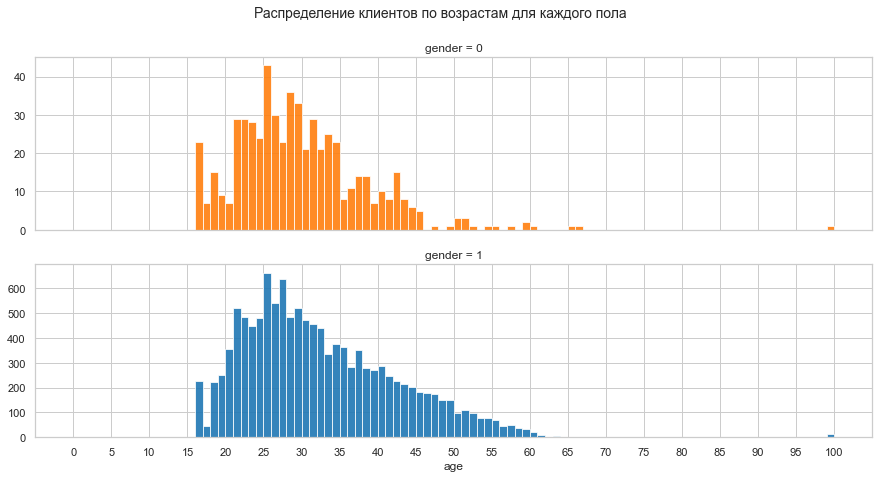

In [140]:
fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
fig.suptitle('Распределение клиентов по возрастам для каждого пола', fontsize=14)
sns.histplot(users_clean[users_clean.gender == 0].age, ax = ax[0], 
             color='tab:orange', alpha=0.9, binwidth=1,binrange=(0,100)).set_title('gender = 0')
plt.xticks(range(0,101,5))
ax[0].set_ylabel('')
sns.histplot(users_clean[users_clean.gender == 1].age, ax = ax[1], 
             color='tab:blue', alpha=0.9, binwidth=1,binrange=(0,100)).set_title('gender = 1')
plt.xticks(range(0,101,5))
ax[1].set_ylabel('')
plt.show()

Распределения по возрастам для обоих полов имеют сходную форму.

Оценим соотношение средних.

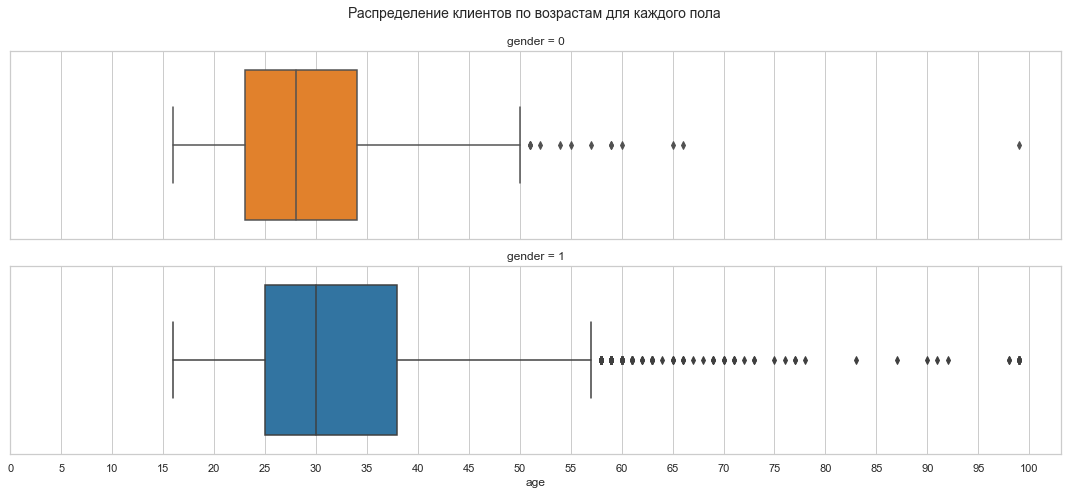

In [141]:
fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
fig.suptitle('Распределение клиентов по возрастам для каждого пола', fontsize=14)
sns.boxplot(data= users_clean[users_clean.gender == 0], x='age', ax = ax[0], 
             color='tab:orange').set_title('gender = 0')
plt.xticks(range(0,101,5))
ax[0].set_ylabel('')
ax[0].set_xlabel('')
sns.boxplot(data= users_clean[users_clean.gender == 1], x='age', ax = ax[1], 
             color='tab:blue').set_title('gender = 1')
plt.xticks(range(0,101,5))
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

Заметны выбросы у обоих полов. Возьмем диапазон до 55 лет, это дейтинговое приложение, и возраста выше этого значения скорее всего указаны некорректно. А если и корректно, таких пользователей единицы.

In [142]:
users_clean.query('age <= 55').groupby('gender', as_index=False).agg({'age':['median','mean','std']}).round(1)

gender    age           
         median  mean  std
0      0   28.0  28.9  7.7
1      1   30.0  31.5  9.2

In [143]:
stats.ttest_ind(users_clean.query('age <= 55 & gender == 0').age,
                users_clean.query('age <= 55 & gender == 1').age, equal_var=False)

Ttest_indResult(statistic=-7.853136194294317, pvalue=1.6726284536858767e-14)

Средний возраст пользователей пола 1 превышает средний возраст пользователей пола 0.

Рассмотрим соотношение возраста пользователей и среднего значения возраста искомого партнера в возрастной группе от 20 до 35 лет, так как именно в этой возрастной группе различия в стратегиях полов наиболее заметны: девушки в среднем чаще предпочитают в качестве партнеров ровесников или постарше, а мужчины - ровесниц или помладше.

In [144]:
s = users_clean.query('age >=20 and age <= 35').reset_index(drop=True)
s['age_filter_mean'] = round((s.age_filter_start + s.age_filter_end) / 2,1)
round(s.groupby('gender', as_index=0)
      .agg({'age':['count','median','mean','std'], 
            'age_filter_mean':['median','mean','std']}),1)

gender   age                   age_filter_mean            
         count median  mean  std          median  mean   std
0      0   409   27.0  27.2  4.1            29.0  34.2  14.4
1      1  7582   27.0  27.2  4.3            27.0  28.7   7.7

Посмотрим на формы распределений возраста пользователей и среднего значения возраста искомого партнера в указанной возрастной группе для обоих полов, чтобы выбрать корректный критерий для их сравнения.

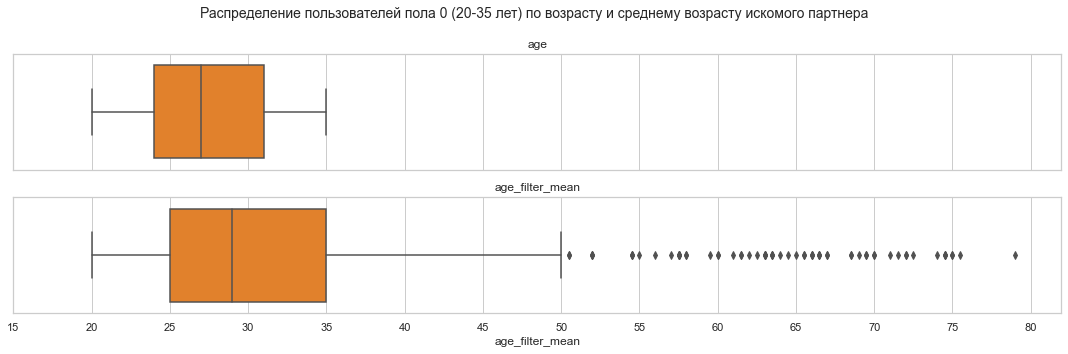

In [145]:
fig, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
fig.suptitle('Распределение пользователей пола 0 (20-35 лет) по возрасту и среднему возрасту искомого партнера', 
             fontsize=14)
sns.boxplot(data=s[s.gender == 0], x='age', ax = ax[0], color='tab:orange').set_title('age')
plt.xticks(range(15,81,5))
ax[0].set_ylabel('')
ax[0].set_xlabel('')
sns.boxplot(data=s[s.gender == 0], x='age_filter_mean', ax = ax[1], color='tab:orange').set_title('age_filter_mean')
plt.xticks(range(15,81,5))
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

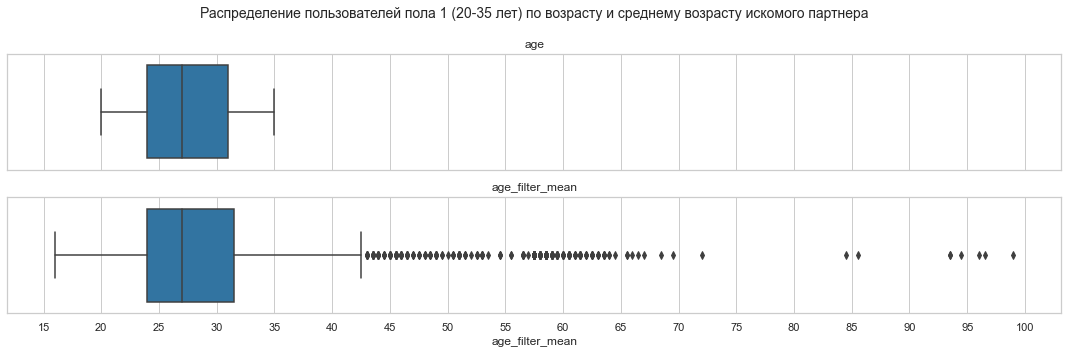

In [146]:
fig, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
fig.suptitle('Распределение пользователей пола 1 (20-35 лет) по возрасту и среднему возрасту искомого партнера', 
             fontsize=14)
sns.boxplot(data=s[s.gender == 1], x='age', ax = ax[0], color='tab:blue').set_title('age')
plt.xticks(range(15,101,5))
ax[0].set_ylabel('')
ax[0].set_xlabel('')
sns.boxplot(data=s[s.gender == 1], x='age_filter_mean', ax = ax[1], color='tab:blue').set_title('age_filter_mean')
plt.xticks(range(15,101,5))
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

Ограничим значения среднего возраста искомого партнера для выбранного возрастного диапазона 20-35 лет 40-ю годами, чтобы исключить откровенных альфонсов и содержанок, которые могут сильно сместить значения средних для обоих полов.

In [147]:
s=s[s.age_filter_mean <= 40]

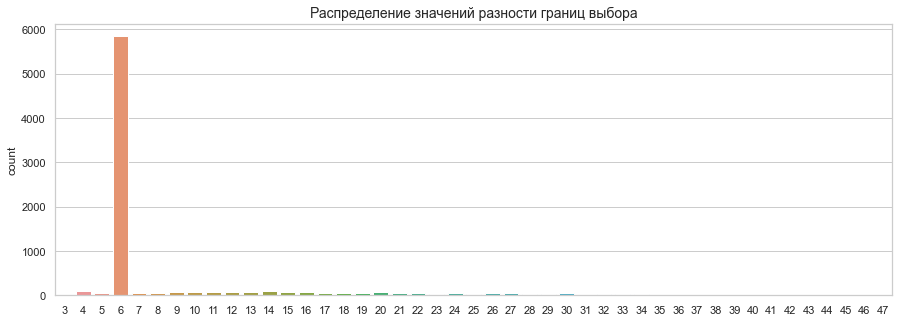

In [148]:
plt.figure(figsize=(15,5))
sns.countplot(x = s.age_filter_end - s.age_filter_start)
plt.title('Распределение значений разности границ выбора', fontsize=14)
plt.show()

Также исключим пользователей, разность границ выбора для которых превышает 15 лет, так как среднее значение в их случае слишком размытое понятие.

In [149]:
s = s[(s.age_filter_end - s.age_filter_start) <= 15]

После совершенных преобразований рассмотрим искомые соотношения для обоих полов.

In [150]:
s.groupby('gender', as_index=0).agg({'age':['count','median','mean','std'],
                                     'age_filter_mean':['median','mean','std']}).round(1)

gender   age                   age_filter_mean           
         count median  mean  std          median  mean  std
0      0   305   26.0  26.7  4.1            27.0  27.2  4.4
1      1  6353   27.0  27.0  4.3            27.0  26.8  4.4

Получены противоположные результаты для полов. Установим стат.значимость полученных различий и сделаем выводы по результатам сравнения.

Рассмотрим получившиеся формы распределений сравниваемых параметров для обоих полов, чтобы выбрать наиболее подходящий стат.критерий. 

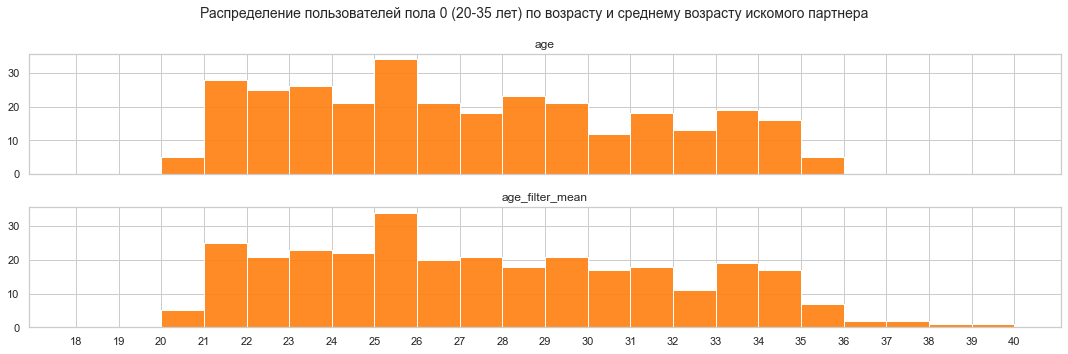

In [151]:
fig, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
fig.suptitle('Распределение пользователей пола 0 (20-35 лет) по возрасту и среднему возрасту искомого партнера', 
             fontsize=14)
sns.histplot(data=s[s.gender == 0], x='age', ax = ax[0], 
             color='tab:orange', alpha=0.9, binwidth=1,binrange=(18,40)).set_title('age')
plt.xticks(range(18,41,1))
ax[0].set_ylabel('')
ax[0].set_xlabel('')
sns.histplot(data=s[s.gender == 0], x='age_filter_mean', ax = ax[1], 
             color='tab:orange', alpha=0.9, binwidth=1,binrange=(18,40)).set_title('age_filter_mean')
plt.xticks(range(18,41,1))
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

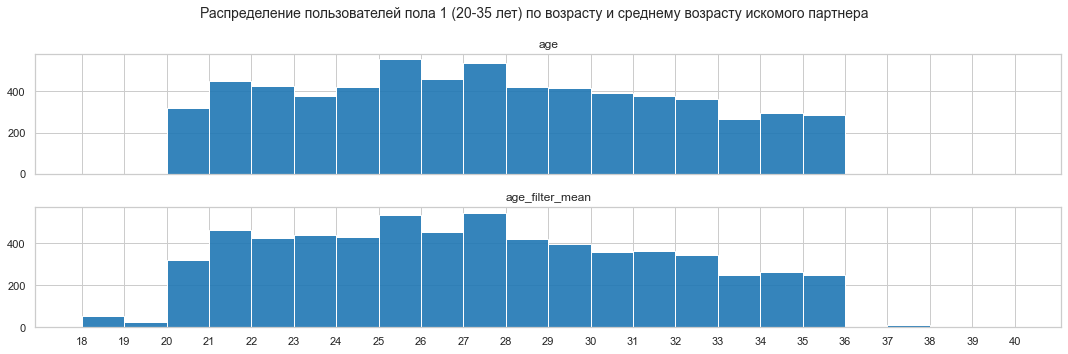

In [152]:
fig, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
fig.suptitle('Распределение пользователей пола 1 (20-35 лет) по возрасту и среднему возрасту искомого партнера', 
             fontsize=14)
sns.histplot(data=s[s.gender == 1], x='age', ax = ax[0], 
             color='tab:blue', alpha=0.9, binwidth=1,binrange=(18,40)).set_title('age')
plt.xticks(range(18,41,1))
ax[0].set_ylabel('')
ax[0].set_xlabel('')
sns.histplot(data=s[s.gender == 1], x='age_filter_mean', ax = ax[1], 
             color='tab:blue', alpha=0.9, binwidth=1,binrange=(18,40)).set_title('age_filter_mean')
plt.xticks(range(18,41,1))
ax[1].set_ylabel('')
ax[1].set_xlabel('')
plt.tight_layout()
plt.show()

Для распределений обоих полов подходит критерий Стьюдента, так как нет сильных перекосов значений и выбросов. 

In [153]:
stats.ttest_ind(s[s.gender == 0].age, 
                s[s.gender == 0].age_filter_mean, equal_var=False)

Ttest_indResult(statistic=-1.3626614307566813, pvalue=0.1734951458927659)

In [154]:
stats.ttest_ind(s[s.gender == 1].age, 
                s[s.gender == 1].age_filter_mean, equal_var=False)

Ttest_indResult(statistic=2.9550948224080096, pvalue=0.0031314681237118052)

Несмотря на бОльшую разницу между полученными средними для пола 0, из-за сравнительно небольшого количества его представителей, данная разница статистически незначима, гипотеза о равенстве средних значений не может быть отклонена. 

При этом стат.значимо возраст пользователей пола 1 превышает среднее значение их возраста выбора для возрастного диапазона 20-35 лет, хотя полученные средние различаются всего на ~2.5 месяца.

Таким образом, в основном представители обоих полов в возрастном диапазоне от 20 до 35 лет предпочитают в качестве партнеров ровесников, однако представители пола 1 в среднем чаще выбирают партнеров помладше, что больше соответствует мужскому паттерну поведения при поиске партнера.

Также в [статье](https://www.netimperative.com/2019/04/05/online-dating-trends-men-outnumber-women-on-tinder-by-9-to-1-while-grinder-wins-for-age-diversity/) от NetImperative на основе исследования ресурса ogury.com приведено соотношение полов в Tinder 9:1 в пользу мужчин. В Bumble, который изначально ориентирован на пользователей женского пола, количество мужчин превышает количество женщин более чем на 80%.

Таким образом, примем следующее соответствие полов:

0 - Female

1 - Male

In [155]:
users.gender = users.gender.apply(lambda x:'F' if x == 0 else 'M')
users_clean.gender = users_clean.gender.apply(lambda x:'F' if x == 0 else 'M')

В условии задания нет сведений о том, в какую сторону была изменена цена препиум-подписки при оплате через новые платежные системы для тестовой группы. Попробуем установить это на основании данных.

Посмотрим на распределение размеров платежей за премиум-подписку по группам.

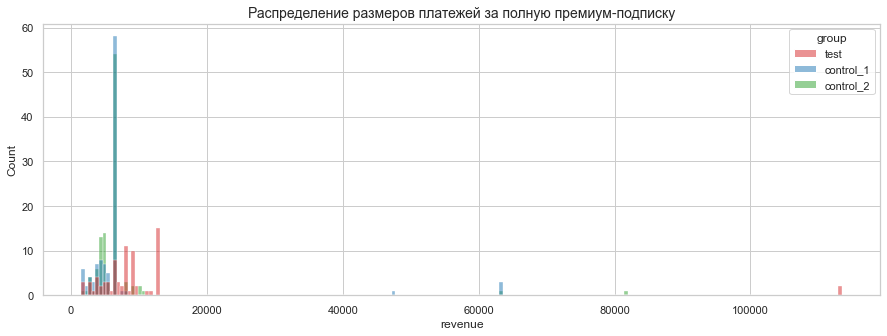

In [156]:
plt.figure(figsize=(15,5))
palette = {'test':'tab:red', 'control_1':'tab:blue', 'control_2':'tab:green'}
sns.histplot(data=transactions.query('product_type == "premium_no_trial"'),
             x='revenue',hue='group',palette=palette)\
.set_title('Распределение размеров платежей за полную премиум-подписку', fontsize=14)
plt.show()

В целом, если присмотреться, тренд проглядывается :) 

Однако ограничим лимит платежа 20 000 у.е., чтобы исключить единичные выбросы и сделать получившиеся графики более читабельными.

In [157]:
round(transactions.query('product_type == "premium_no_trial" & revenue < 20000').shape[0] *100 /\
transactions.query('product_type == "premium_no_trial"').shape[0],1)

97.2

In [158]:
transactions.query('product_type == "premium_no_trial" & revenue >= 20000').sort_values('revenue', ascending=False)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
12,891178380,Spain,2017-11-08 03:54:00,2017-11-09 21:53:00,113477.0,147,promo_09,premium_no_trial,test
196,892038759,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147,autoreply_message,premium_no_trial,test
1327,891778551,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147,left_sidebar_menu,premium_no_trial,control_2
416,892333905,Italy,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147,no_sympathy,premium_no_trial,control_1
550,892216461,United States of America,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147,autoreply_message,premium_no_trial,control_1
590,891383310,Turkey,2017-11-04 20:47:00,2017-11-04 22:17:00,63037.0,147,autoreply_message,premium_no_trial,control_1
1302,892307238,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147,left_sidebar_menu,premium_no_trial,control_2
303,892421277,United States of America,2017-10-14 13:05:00,2017-10-15 13:11:00,47723.0,147,promo_09,premium_no_trial,control_1


Этому ограничению соответствует 97.2 % данных платежей, среди выбросов есть значения из всех трех групп, поэтому точность не будет потеряна.

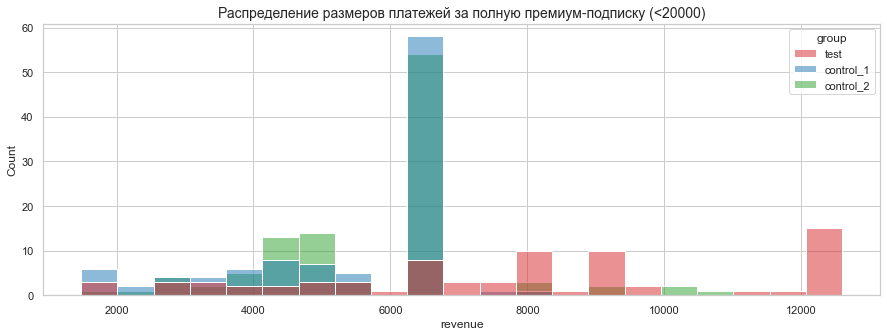

In [159]:
plt.figure(figsize=(15,5))
palette = {'test':'tab:red', 'control_1':'tab:blue', 'control_2':'tab:green'}
sns.histplot(data=transactions.query('product_type == "premium_no_trial" &\
                                      revenue < 20000'),
             x='revenue',hue='group',palette=palette)\
.set_title('Распределение размеров платежей за полную премиум-подписку (<20000)', fontsize=14)
plt.show()

В тестовой группе распределение размера платежей имеет больший размах, встречаются как минимальные суммы, так и максимальные, и все, что между ними. Однако стоит заметить, что все макимальные значения платежей принадлежат именно тестовой группе.

Посмотрим на распределение платежей за премиум-подписку по размеру по странам, количество платежей из которых самое высокое. Это необходимо, чтобы нивелировать возможное влияние курса валют и региональной ценовой политики на размер платежей в разных странах.

In [160]:
round(transactions.query('product_type == "premium_no_trial" & revenue < 20000')
      .country.value_counts(normalize=True).head(5).mul(100),1).apply(str) + '%'

United States of America          28.5%
France                             9.6%
Italy                              9.3%
United Kingdom (Great Britain)     7.5%
Spain                              7.1%
Name: country, dtype: object

In [161]:
round(transactions.query('product_type == "premium_no_trial" & revenue < 20000')
      .country.value_counts(normalize=True).head(5).mul(100).sum(),1)

61.9

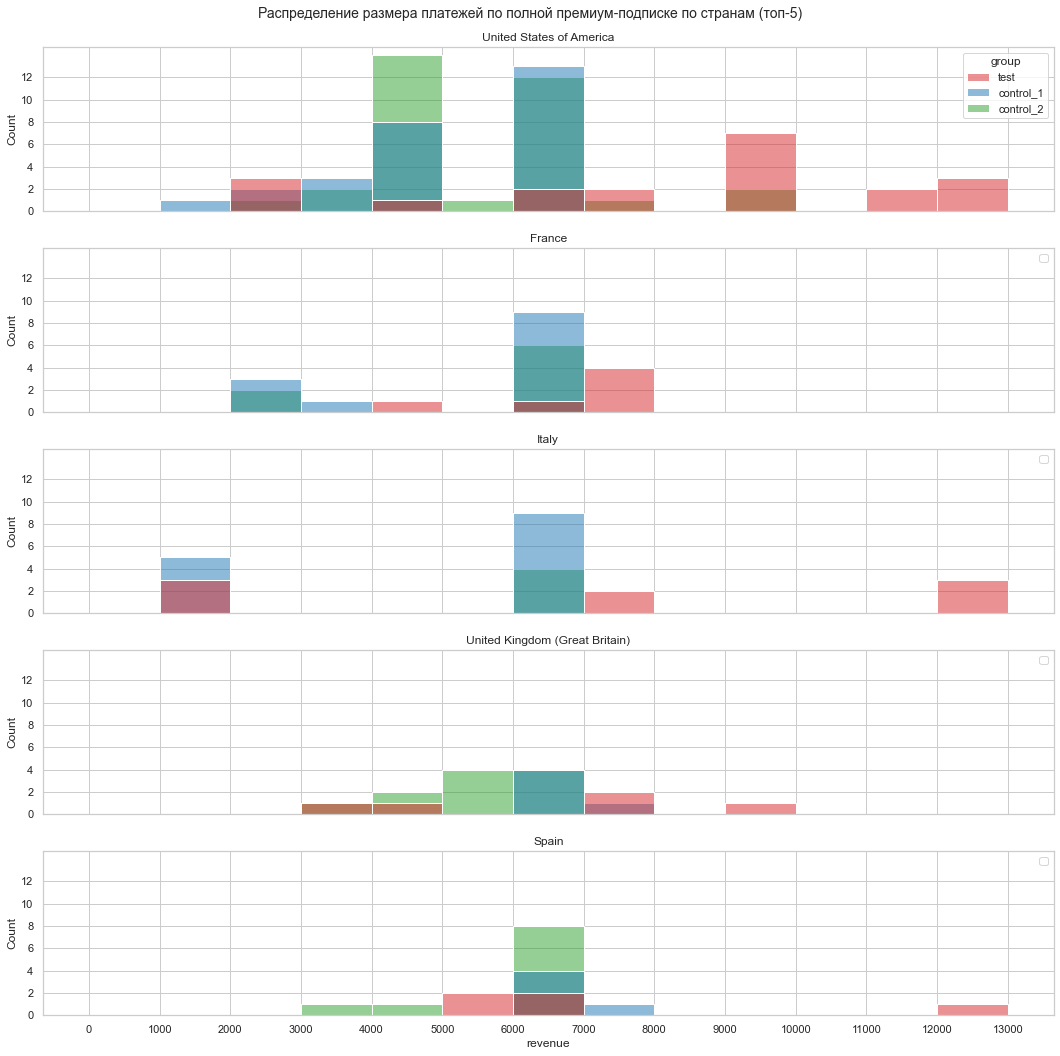

In [162]:
fig, ax = plt.subplots(5,1,figsize=(15,15),sharex=True, sharey=True)
plt.suptitle('Распределение размера платежей по полной премиум-подписке по странам (топ-5)', fontsize=14)
country = list(transactions.query('product_type == "premium_no_trial" & revenue < 20000')
      .country.value_counts().head(5).index)
palette = {'test':'tab:red', 'control_1':'tab:blue', 'control_2':'tab:green'}
for i in range(len(country)):
    s = sns.histplot(data=transactions.query('product_type == "premium_no_trial" &\
                                             country == @country[@i] &\
                                             revenue < 20000'),
                 x='revenue',hue='group',palette=palette, ax=ax[i], binwidth=1000, binrange=(0,13000))
    s.set_title(country[i], fontsize=12)
    if i != 0:
        s.legend('')
plt.xticks(range(0,13001,1000))
plt.yticks(range(0,14,2))
plt.tight_layout(pad=1.4)
plt.show()

Наблюдаем аналогичные особенности распределения размера платежей по оплате премиум-подписки в пяти самых популярных странах, суммарное количество платежей из которых составляет 61.9% всех платежей.

Рассмотрим средние значения размеров платежей по оплате премиум-подписки в группах.

In [163]:
transactions.query('product_type == "premium_no_trial" & revenue < 20000').groupby('group', as_index=False)\
.agg({'revenue':['count','mean','std']}).round(2)

group revenue                  
               count     mean      std
0  control_1     102  5317.89  1482.72
1  control_2     105  5714.06  1543.65
2       test      74  7888.54  3217.44

В тестовой группе среднее значение выше, однако, и стандартное отклонение высокое.

Сравним средние значения размеров платежей по оплате премиум-подписки между группами с помощью критерия Стьюдента (распределения значений в группах далеки от нормального, однако, выбросы отсутствуют) и бутстрапа - для проверки полученных результатов.

In [164]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    #plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

In [165]:
def get_bootstrap_pvalue(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    return p_value

In [166]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'revenue'
for row in groups:
    for col in groups:
        a = transactions.query('product_type == "premium_no_trial" & revenue < 20000').query("group == @row")[metric]
        b = transactions.query('product_type == "premium_no_trial" & revenue < 20000').query("group == @col")[metric]
        s.loc[row,col] = round(stats.ttest_ind(a,b,equal_var=False)[1],4)
s

,control_1,control_2,test
control_1,1.0000,0.0611,0.0
control_2,0.0611,1.0000,0.0
test,0.0000,0.0000,1.0


Различия между контрольными группами и тестовой статистически значимы, однако, также обращает на себя внимание низкий p-value при сравнении контрольных групп между собой. Проверим полученные выводы с помощью бутстрапа.

In [167]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'revenue'
for row in groups:
    for col in groups:
        a = transactions.query('product_type == "premium_no_trial" & revenue < 20000').query("group == @row")[metric]
        b = transactions.query('product_type == "premium_no_trial" & revenue < 20000').query("group == @col")[metric]
        s.loc[row,col] = round(get_bootstrap_pvalue(a,b),4)
s

,control_1,control_2,test
control_1,0.9981,0.0571,0.0000
control_2,0.0555,0.9920,0.0000
test,0.0000,0.0000,0.9859


Результаты практически идентичны с критерием Стьюдента.

Согласно условию стоимость пробной подписки осталась без изменений, как для тестовой, так и для контрольных групп. Посмотрим на ее распределение и сравним с непробной.

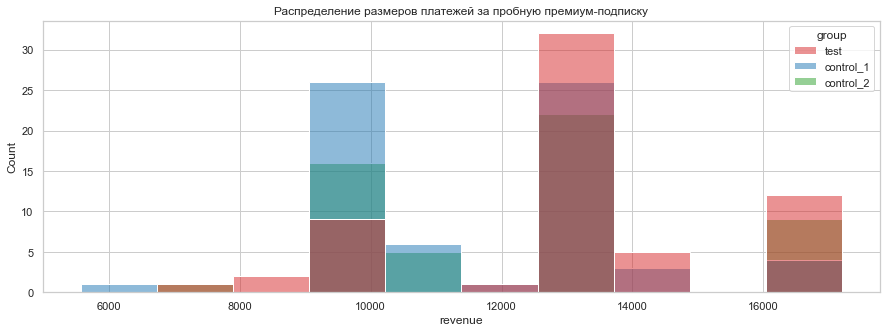

In [168]:
plt.figure(figsize=(15,5))
palette = {'test':'tab:red', 'control_1':'tab:blue', 'control_2':'tab:green'}
sns.histplot(data=transactions.query('product_type == "trial_premium"'),
             x='revenue',hue='group',palette=palette)\
.set_title('Распределение размеров платежей за пробную премиум-подписку')
plt.show()

Явное преимущество размера платежей в тестовой группе уже не проглядывается.

Посмотрим на распределение платежей за пробную премиум-подписку по размеру по странам, количество покупок пробной премиум-подписки из которых самое высокое. Это необходимо, чтобы нивелировать возможное влияние курса валют и региональной ценовой политики на размер платежей в разных странах.

In [169]:
round(transactions.query('product_type == "trial_premium"')
      .country.value_counts(normalize=True).head(5).mul(100),1).apply(str) + '%'

United States of America    40.1%
France                      11.0%
Spain                        7.1%
Belgium                      5.5%
Argentina                    5.5%
Name: country, dtype: object

In [170]:
round(transactions.query('product_type == "trial_premium"')
      .country.value_counts(normalize=True).head(5).mul(100).sum(),1)

69.2

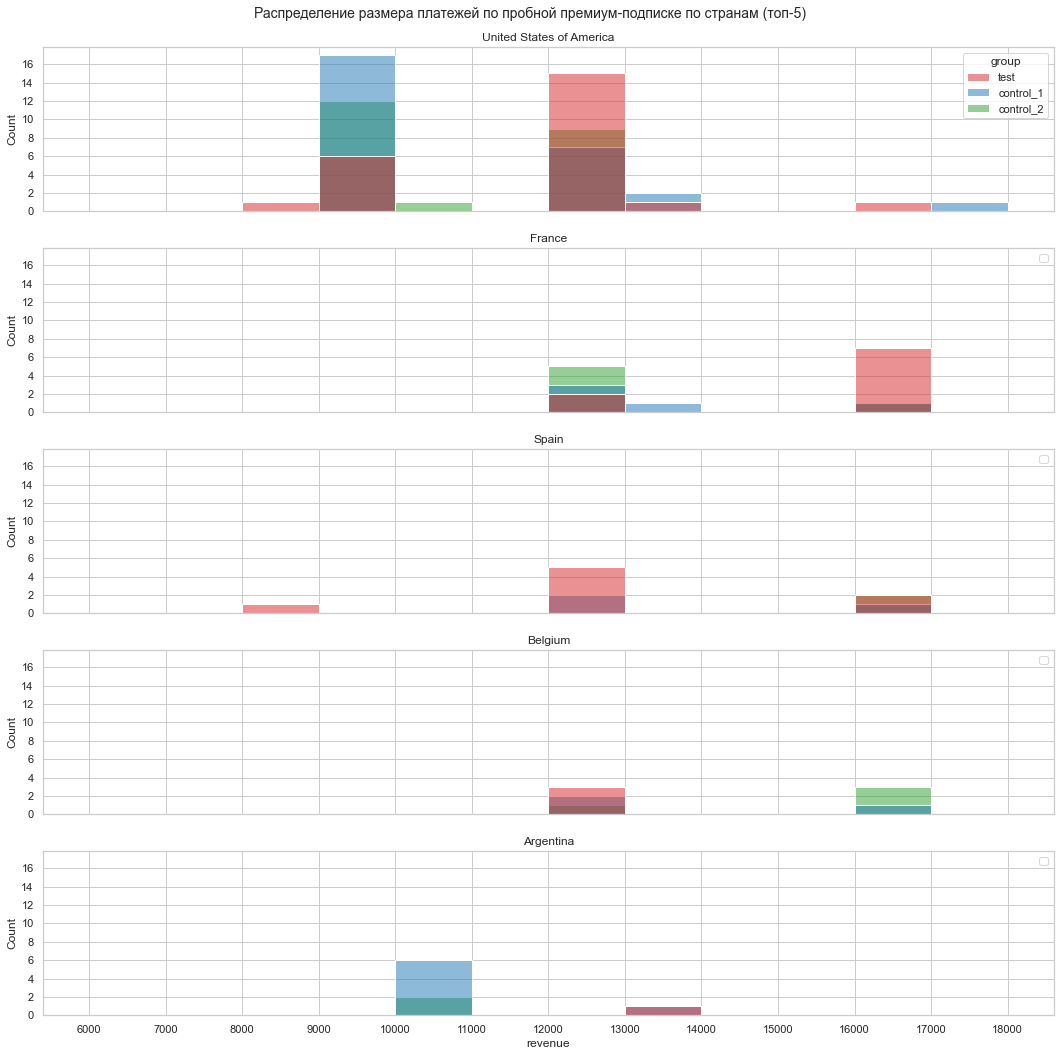

In [171]:
fig, ax = plt.subplots(5,1,figsize=(15,15),sharex=True, sharey=True)
plt.suptitle('Распределение размера платежей по пробной премиум-подписке по странам (топ-5)', fontsize=14)
country = list(transactions.query('product_type == "trial_premium"').country.value_counts().head(5).index)
palette = {'test':'tab:red', 'control_1':'tab:blue', 'control_2':'tab:green'}
for i in range(len(country)):
    s = sns.histplot(data=transactions.query('product_type == "trial_premium" & country == @country[@i]'),
                 x='revenue',hue='group',palette=palette, ax=ax[i], binwidth=1000, binrange=(6000,18000))
    s.set_title(country[i], fontsize=12)
    if i != 0:
        s.legend('')
plt.xticks(range(6000,18001,1000))
plt.yticks(range(0,18,2))
plt.tight_layout(pad=1.4)
plt.show()

Наблюдаем аналогичное отсутствие преимущества тестовой группы по размеру оплаты пробной премиум-подписки в правой части графика в пяти самых популярных странах, суммарное количество платежей из которых составляет 69.2% всех платежей.

Рассмотрим средние значения размеров платежей по оплате пробной премиум-подписки в группах.

In [172]:
transactions.query('product_type == "trial_premium"').groupby('group', as_index=False)\
.agg({'revenue':['count','mean','std']}).round(2)

group revenue                   
               count      mean      std
0  control_1      67  11533.13  2293.84
1  control_2      53  12150.58  2610.92
2       test      62  12906.48  2419.49

В тестовой группе среднее значение выше. Сравним средние значения размеров платежей по оплате премиум-подписки между группами с помощью критерия Стьюдента (распределения значений в группах далеки от нормального, однако, выбросы отсутствуют) и бутстрапа - для проверки полученных результатов.

In [173]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'revenue'
for row in groups:
    for col in groups:
        a = transactions.query('product_type == "trial_premium"').query("group == @row")[metric]
        b = transactions.query('product_type == "trial_premium"').query("group == @col")[metric]
        s.loc[row,col] = round(stats.ttest_ind(a,b,equal_var=False)[1],4)
s

,control_1,control_2,test
control_1,1.0000,0.1778,0.0013
control_2,0.1778,1.0000,0.1124
test,0.0013,0.1124,1.0000


Различия статистически незначимы. Проверим полученные выводы с помощью бутстрапа.

In [174]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'revenue'
for row in groups:
    for col in groups:
        a = transactions.query('product_type == "trial_premium"').query("group == @row")[metric]
        b = transactions.query('product_type == "trial_premium"').query("group == @col")[metric]
        s.loc[row,col] = round(get_bootstrap_pvalue(a,b),4)
s

,control_1,control_2,test
control_1,0.9966,0.1401,0.0013
control_2,0.1601,0.9672,0.0853
test,0.0008,0.0800,0.9786


Результаты близки к полученным с помощью критерия Стьюдента.

В данных о платежах отсутствуют сведения о платежных системах, через которые они были совершены, поэтому мы не можем напрямую установить зависимость размера платежа от выбранной платежной системы в тестовой группе и наверняка узнать, в какую сторону изменена цена.

Исходя из отсутствия прочих уточнений в условии, примем, что для тестовой группы были открыты и новые платежные системы, и старые тоже остались (как и для контрольных групп). Разница между тестом и контролем таким образом состояла только в изменении цены премиум-подписки при оплате через новые платежные системы при одинаковом наборе возможных платежных систем в тестовой и контрольной группах.

Таким образом, в данных тестовой группы могут быть как оплаты премиум-подписки через новые платежные системы (с изменением стоимости), так и оплаты премиум-подписки через старые платежные системы (без изменения стоимости). Это объясняет больший размах значений в распределении размера платежей по премиум-подписке в тестовой группе относительно контрольных.

Доминирование тестовой группы в правой части графика распределения размера платежей по премиум-подписке (даже среди выбросов), статистически значимая разница в среднем размере платежа, вкупе с пояснением о ежемесячном характере платежей без возможности единовременной оплаты за следующие несколько месяцев, данном в условии, а также отсутствием аналогичной особенности распределения для пробной подписки, свидетельствует об увеличении стоимости премиум-подписки через новые платежные системы для пользователей тестовой группы.

Данное допущение поможет нам при формировании выводов и рекомендаций по итогам эксперимента.

## 2. Общая информация о пользователях, сегментация

После подготовки массива можно приступить к изучению и сегментации пользователей.

In [175]:
users_clean_full = users_clean.copy()

### Возраст

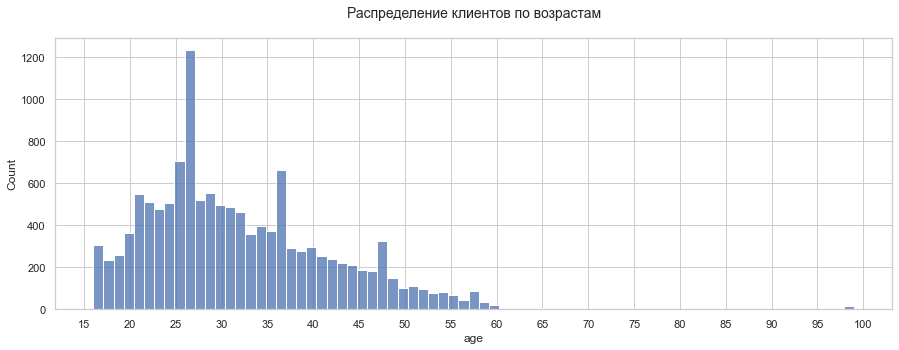

In [176]:
plt.figure(figsize = (15, 5))
ax = sns.histplot(x = users_clean_full.age)
ax.set_title('Распределение клиентов по возрастам', fontsize = 14, pad = 20)
plt.xticks(range(15,105,5))
plt.show()

In [177]:
users_clean_full.age.quantile([0,0.2,0.4,0.6,0.8,1])

0.0    16.0
0.2    23.0
0.4    28.0
0.6    33.0
0.8    40.0
1.0    99.0
Name: age, dtype: float64

Распределим пользователей по возрастам на базе жизненных этапов большинства людей, их примерных целей в дейтинговом приложении, с учетом квантилей на 5 групп:

- 16-22: школьники старших классов и студенты, ищут любовь и сильные эмоции, тратят деньги родителей
- 23-28: постстуденчество, первое трудоустройство, первый опыт самостоятельной жизни, ищут партнера со сходными амбициями в жизни, тратят первые заработанные деньги
- 29-34: сформировавшиеся люди с пониманием, чего они хотят от жизни, точно знают характеристики своего героя (героини), внимательны к тратам
- 35-45: разочаровавшиеся, разведенные, одинокие, ищут компаньона для совместной жизни
- 46+: такие же разочаровавшиеся, разведенные, одинокие, ищущие компаньона для совместной жизни, только совсем старые.

In [178]:
def age_segments(x):
    if x in range(16,23,1):
        return '16-22'
    if x in range(23,29,1):
        return '23-28'
    if x in range(29,35,1):
        return '29-34'
    if x in range(35,46,1):
        return '35-45'
    else:
        return '46+'

In [179]:
round(users_clean_full.age.apply(lambda x: age_segments(x)).value_counts(normalize=True).mul(100),1).sort_index()\
.apply(str) + '%'

16-22    17.3%
23-28    26.7%
29-34    21.3%
35-45    23.4%
46+      11.3%
Name: age, dtype: object

In [180]:
users_clean_full['age_segment'] = users_clean_full.age.apply(lambda x: age_segments(x))

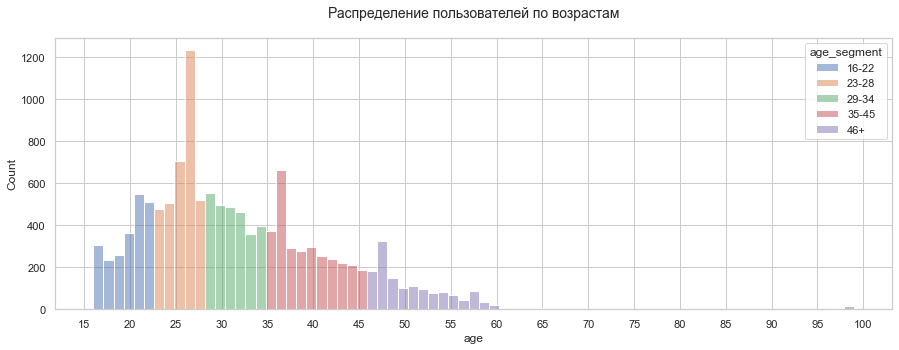

In [181]:
plt.figure(figsize = (15, 5))
ax = sns.histplot(data=users_clean_full, x='age', 
                  hue='age_segment', hue_order=sorted(list(users_clean_full.age_segment.unique())))
ax.set_title('Распределение пользователей по возрастам', fontsize = 14, pad = 20)
plt.xticks(range(15,105,5))
plt.show()

### Количество посещений в период эксперимента

Согласно условию:

visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

Эксперимент проводился для новых пользователей, которые регистрировались в течение эксперимента. Соответственно есть пользователи, зарегистрировавшиеся в первые дни эксперимента, а есть те, кто зарегистрировася, например, за день до его окончания. У всех пользователей разное количество дней в приложении, поэтому их активность нельзя оценить числом посещений. Необходимо учитывать, сколько дней пользователь зарегистрирован в приложении, и сколько из них он посещал приложение, чтобы получить информативную общую метрику посещаемости для пользователей, зарегитрировавшихся в разные дни эксперимента.

Данные по дате регистрации есть только по платящим пользователям, поэтому расчет данной метрики будет произведен только по ним отдельно после сегментации общего массива пользователей.

Пока же просто рассчитаем количество посещений по всем пользователям.

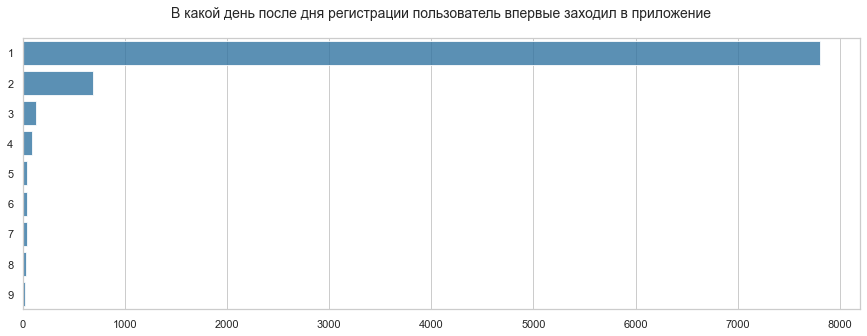

In [182]:
s = pd.DataFrame(users_clean_full.visit_days.str[0].value_counts(dropna=False).sort_index())
plt.figure(figsize=(15,5))
sns.barplot(data=s, y = s.index, x='visit_days', color='tab:blue', alpha=0.8)
plt.title('В какой день после дня регистрации пользователь впервые заходил в приложение', fontsize=14, pad=20)
plt.xlabel('')
plt.show()

В основном пользователи впервые заходили в приложение в 1-й день после регистрации, однако есть и те, кто после регистрации проявлял активность только через несколько дней. Максимальный лаг составил 9 дней.

In [183]:
round(users_clean_full.visit_days.isna().value_counts(normalize=True).mul(100),1).apply(str) + '%'

False    68.8%
True     31.2%
Name: visit_days, dtype: object

31.2% пользователей вообще не заходили в приложение после регистрации, что довольно тревожно.

In [184]:
def visit_days_count(x):
    if x != x:
        return 1
    else:
        return x.count(',') + 2

In [185]:
users_clean_full['visit_days_count'] = users_clean_full.visit_days.apply(lambda x: visit_days_count(x)).apply(int)

### Регионы

In [186]:
s = users_clean_full.country.value_counts(normalize=True).mul(100).reset_index()\
.rename(columns={'index':'country', 'country':'%'})
s['cum%'] = s['%'].cumsum()
s.round(1).head(15)

,country,%,cum%
0,United States of America,34.1,34.1
1,Argentina,9.2,43.3
2,France,8.6,51.8
3,Italy,7.4,59.2
4,Spain,7.4,66.6
5,Chile,6.6,73.2
6,United Arab Emirates,5.0,78.1
7,Germany,4.6,82.8
8,United Kingdom (Great Britain),3.6,86.4
9,Canada,3.1,89.5


Основную часть пользователей составляют представители североамериканских, латиноамериканских и европейских стран. Остальных отнесем в группу Прочие.

In [187]:
s.country.unique()

array(['United States of America', 'Argentina', 'France', 'Italy',
       'Spain', 'Chile', 'United Arab Emirates', 'Germany',
       'United Kingdom (Great Britain)', 'Canada', 'Israel', 'Portugal',
       'Belgium', 'Australia', 'Switzerland', 'Ukraine',
       'Russian Federation', 'Turkey', 'Mexico', 'India', 'Morocco',
       'Tunisia', 'Algeria', 'Indonesia', 'Colombia', 'Pakistan',
       'Dominican Republic', 'Kyrgyzstan', 'Costa Rica', 'Tajikistan',
       'Peru', 'Egypt', 'Puerto Rico', 'Austria', 'Qatar', 'Philippines',
       'Venezuela', 'China', 'Georgia', 'Uruguay', 'Romania', 'Latvia',
       'Hungary', 'Guatemala', 'Azerbaijan', 'New Zealand', 'Malaysia',
       'Mali', 'Nicaragua', 'Belarus', 'Jamaica', 'Czech Republic',
       'Uganda', 'Kuwait', 'Somalia', 'Paraguay', 'Burkina Faso',
       'Moldova, Republic of', 'Iraq', 'Armenia', 'Nepal', 'Panama',
       'Sweden', 'Uzbekistan', 'Monaco', 'Bolivia',
       'Islamic Republic of Iran', 'Brazil', 'Korea, Republic of

In [188]:
def country_segment(x):
    if x in ['United States of America', 'Canada']:
        return 'North America'
    if x in ['Argentina', 'Chile','Mexico', 'Colombia', 'Dominican Republic', 'Costa Rica',
             'Peru', 'Puerto Rico', 'Venezuela', 'Uruguay', 'Guatemala', 'Nicaragua', 'Jamaica',
             'Paraguay', 'Panama', 'Bolivia', 'Brazil']:
        return 'Latin America'
    if x in ['France', 'Italy', 'Spain', 'Germany', 'United Kingdom (Great Britain)', 
             'Portugal', 'Belgium', 'Switzerland', 'Austria', 'Romania', 'Latvia', 
             'Hungary', 'Czech Republic', 'Moldova, Republic of', 'Sweden', 'Monaco', 'Lithuania']:
        return 'Europe'
    else:
        return 'Other'

In [189]:
round(users_clean_full.country.apply(lambda x: country_segment(x)).value_counts(normalize=True).mul(100), 1)\
.apply(str) + '%'

North America    37.3%
Europe           37.0%
Latin America    16.0%
Other             9.7%
Name: country, dtype: object

In [190]:
users_clean_full['country_segment'] = users_clean_full.country.apply(lambda x: country_segment(x))

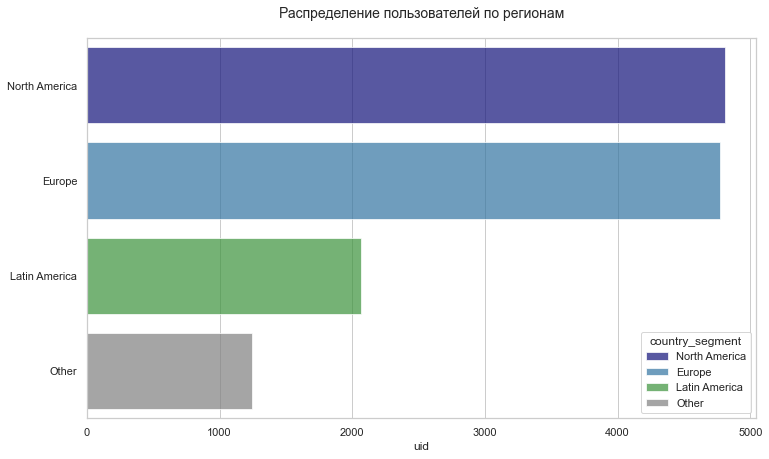

In [191]:
data=users_clean_full.groupby('country_segment', as_index=False).agg({'uid':'count'})\
.sort_values('uid', ascending=False).reset_index(drop=True)
plt.figure(figsize=(12,7))
sns.barplot(data=data,y='country_segment',x='uid',hue='country_segment',dodge=False,
            palette=['darkblue','tab:blue','tab:green','tab:grey'], alpha=0.7)
plt.title('Распределение пользователей по регионам', fontsize=14, pad=20)
plt.ylabel('')
plt.show()

### Доход

Разделим пользователей по признаку - платящий/неплатящий. По уровню дохода с пользователя общий массив делить нет смысла, так как доля плятящих пользователей крайне мала. Отдельно платящих пользователей делить по доходу, возможно, имеет смысл, это будет установлено в отдельном разделе по сегментации платящих пользователей далее.

In [192]:
users_clean_full['is_paying'] = users_clean_full.total_revenue.apply(lambda x: 1 if x > 0 else 0)

### Подписки

Выделим пользователей, которые оплатили пробную/полную премиум-подписку хотя бы раз.

In [193]:
premium_paid_users = transactions_clean[transactions_clean.product_type == 'premium_no_trial'].uid.unique()
trial_paid_users = transactions_clean[transactions_clean.product_type == 'trial_premium'].uid.unique()
users_clean_full['is_premium_paid'] = users_clean_full.uid.apply(lambda x: 1 if x in premium_paid_users else 0)
users_clean_full['is_trial_paid'] = users_clean_full.uid.apply(lambda x: 1 if x in trial_paid_users else 0)

### Доп.сегментация платящих пользователей по поведению в приложении

- частота посещения приложения

- платежеспособность

- продуктовые предпочтения (только подписки, не только подписки, только не подписки)

In [194]:
paying_users_full = users_clean_full.query('is_paying == 1')

### Частота посещений

Добавим данные о регистрации в массив по платящим пользователям.

In [195]:
paying_users_full = paying_users_full.merge(transactions_clean[['uid','joined_at']].drop_duplicates(),
                                            on='uid', how='left')

Рассчитаем количество полных дней со дня регистрации до окончания эксперимента, включая первый и последний дни.

In [196]:
paying_users_full['days_from_join'] = (transactions_clean.paid_at.max() - paying_users_full.joined_at)\
.dt.days + 2

In [197]:
(paying_users_full.visit_days_count / paying_users_full['days_from_join']).max()

1.0

Рассчитаем коэффициент посещаемости, разделив число посещений на число дней со дня регистрации. Далее рассмотрим распределение среднего значения данного коэффициента в зависимости от числа дней со дня регистрации.

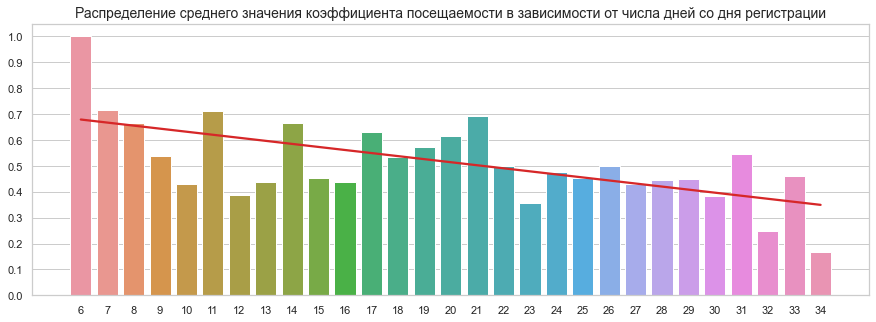

In [198]:
s = paying_users_full.loc[:,['uid','days_from_join','visit_days_count']]
s['visits_frequency_naive'] = round(s.visit_days_count / s.days_from_join).astype(int)
p = s.groupby('days_from_join', as_index=False).agg({'visits_frequency_naive':'mean'}).round(3)
fig,ax = plt.subplots(figsize=(15,5))
ax=sns.barplot(data=p,x='days_from_join', y='visits_frequency_naive')
sns.regplot(x=np.arange(0,len(p)), y=p['visits_frequency_naive'], ci=None, marker='', 
                color='tab:red', ax=ax)
ax.set_title('Распределение среднего значения коэффициента посещаемости \
в зависимости от числа дней со дня регистрации', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticks(np.arange(0,1.1,0.1))
plt.show()

Ожидаемо, коэффициент распределен неравномерно - чем меньше дней со дня региcтрации, тем выше коэффициент посещаемости. Хотя в теории распределение не должно иметь явного смещения, так как распределение дат регистраций активных и неактивных пользователей в течение эксперимента должно быть примерно равномерным. 

Необходимо привести всех пользователей к единому объективному коэффициенту посещаемости для корректного сравнения между собой, рассчитав прогнозный коэффициент посещаемости по итогам 34 дней со дня регистрации для всех пользователей. 

Для корректного моделирования прогнозного коэффициента посещаемости, рассмотрим динамику его изменения для платящих пользователей, зарегистрировавшихся как минимум за 20 дней до конца эксперимента.

In [199]:
paying_users_full.shape[0]

508

In [200]:
print('Таких пользователей {} - {}% платящих пользователей'.format(
    paying_users_full.query('days_from_join >= 20').shape[0],
    round(paying_users_full.query('days_from_join >= 20').shape[0] *100 / paying_users_full.shape[0], 1)))

Таких пользователей 267 - 52.6% платящих пользователей


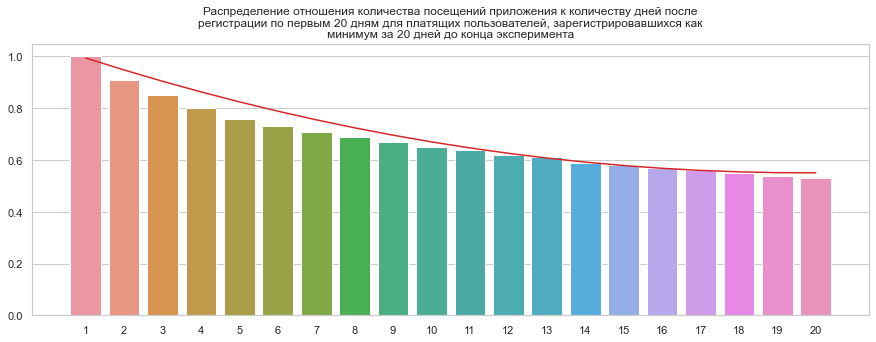

In [201]:
def ins01(x):
    x.insert(0,1)
    return x

data = paying_users_full.query('days_from_join >= 20')
visit_days_dist = pd.DataFrame()
m=0
n=0
for i in range(1,21,1):
    m+=data.visit_days.apply(lambda x: [] if x!=x else [int(n)+1 for n in str(x).split(',')])\
    .apply(lambda x: ins01(x)).apply(lambda x: i in x).sum()
    n+=data.shape[0]
    visit_days_dist.loc[i,'ratio'] = round(m/n,2)
visit_days_dist = visit_days_dist.reset_index().rename(columns={'index':'day_number'})

a,b,c = np.polyfit(visit_days_dist.day_number, visit_days_dist.ratio, 2)
x = np.array(range(0,20,1))
y = a*(x**2) + b*x + c

fig, ax = plt.subplots(figsize=(15,5), sharex=True, sharey=True)
sns.barplot(data=visit_days_dist, x='day_number',y='ratio')
plt.plot(x, y, color='tab:red')
plt.xlabel('')
plt.ylabel('')
plt.title(textwrap.fill('Распределение отношения количества посещений приложения к количеству дней после регистрации \
по первым 20 дням для платящих пользователей, зарегистрировавшихся как минимум за 20 дней до конца эксперимента', 88))

plt.show()

Динамика изменения хорошо описывается квадратичной функцией. На 20-м дне ветка параболы становится практически параллельной оси Х.

In [202]:
visit_days_dist.tail(10)

,day_number,ratio
10,11,0.64
11,12,0.62
12,13,0.61
13,14,0.59
14,15,0.58
15,16,0.57
16,17,0.56
17,18,0.55
18,19,0.54
19,20,0.53


К 20-му дню частота посещений стабилизируется. Примем, что для пользователей с числом дней в приложении меньше 20, начиная с 20 дня она не измняется до конца месяца эксперимента. Таким образом, приведя их показатели посещаемости к прогнозному уровню 20-го дня с помощью пропорции, мы получим умеренно позитивный итоговый прогноз коэффициента посещаемости для этой группы пользователей.

In [203]:
def visits_approximation(df):
    x0 = df.days_from_join
    y0 = df.visit_days_count
    if x0 >= 20:
        return round(y0*1000/x0)
    else:
        k = visit_days_dist.ratio[19] / visit_days_dist.ratio[x0-1]
        return round(k*y0*1000/x0)

Рассчитаем частоту посещений двумя разными способами и приведем ее к шкале от 0 до 1000 для наглядности. Далее сравним распределение средних частот посещений в зависимости от количества дней со дня регистрации, оставшихся до конца эксперимента (days_from_join). 

In [204]:
s = paying_users_full.loc[:,['uid','days_from_join','visit_days_count']]

s['visits_frequency_naive'] = round(s.visit_days_count *1000 / s.days_from_join).astype(int)
s['visits_frequency_adjusted'] = s.apply(lambda x: visits_approximation(x),1)
s.head()

,uid,days_from_join,visit_days_count,visits_frequency_naive,visits_frequency_adjusted
0,891152790,8,4,500,384
1,892333656,32,5,156,156
2,891589239,16,10,625,581
3,891343671,11,10,909,753
4,892430988,34,3,88,88


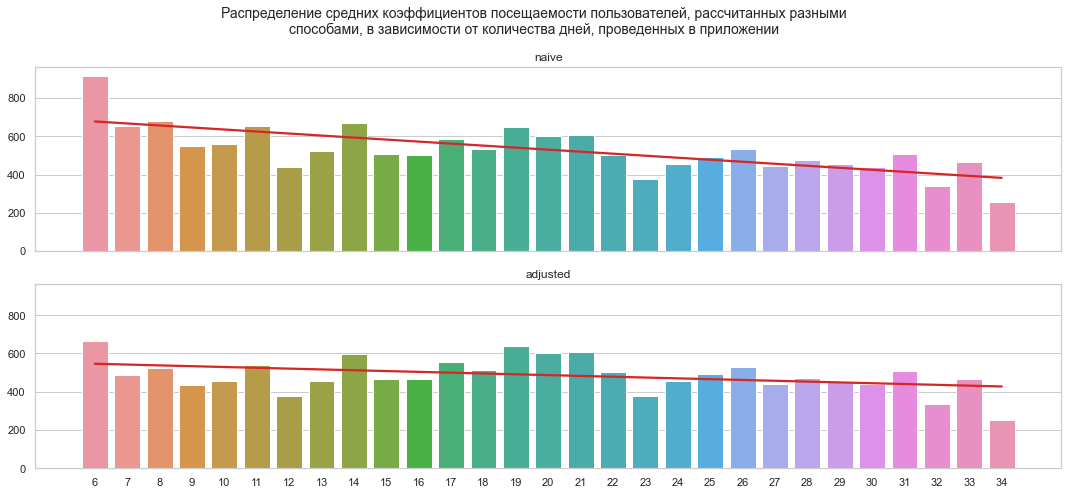

In [205]:
p = s.groupby('days_from_join', as_index=False).agg({'visits_frequency_naive':'mean',
                                                 'visits_frequency_adjusted':'mean'}).round(3)

method=['naive','adjusted']
fig, ax = plt.subplots(2,1,figsize=(15,7), sharex=True, sharey=True)
plt.suptitle(textwrap.fill('Распределение средних коэффициентов посещаемости пользователей, \
рассчитанных разными способами, в зависимости от количества дней, проведенных в приложении',88),
             fontsize=14)
for i in [0,1]:
    sns.barplot(data=p,x='days_from_join', y='visits_frequency_'+method[i], ax=ax[i])
    sns.regplot(x=np.arange(0,len(p)), y=p['visits_frequency_'+method[i]], ci=None, marker='', 
                color='tab:red', ax=ax[i])
    ax[i].set_title(method[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
plt.tight_layout()
plt.show()

На распределениях видно, что сглажены значения в левой части графика, наклон линии тренда гораздо меньше. Рассмотрим эффект на примерах.

In [206]:
s.sort_values('days_from_join').iloc[[16,101,150,423,507],:]

,uid,days_from_join,visit_days_count,visits_frequency_naive,visits_frequency_adjusted
454,891143379,8,7,875,672
61,891297711,11,9,818,678
22,891499695,14,14,1000,898
78,892202526,29,27,931,931
94,892431081,34,1,29,29


На примерах очевидно, что второй подход дает интуитивно более реалистичную картину - 9/11 сопоставимо с 7/8, а не значительно хуже как в "наивном" подходе (1 и 2 строки примеров). А 27/29 немного лучше 14/14, а не хуже как в "наивном", так как далеко не факт, что пользователь с 14/14 не пропустит еще хотя бы два дня из оставшихся 15 дней до 29.

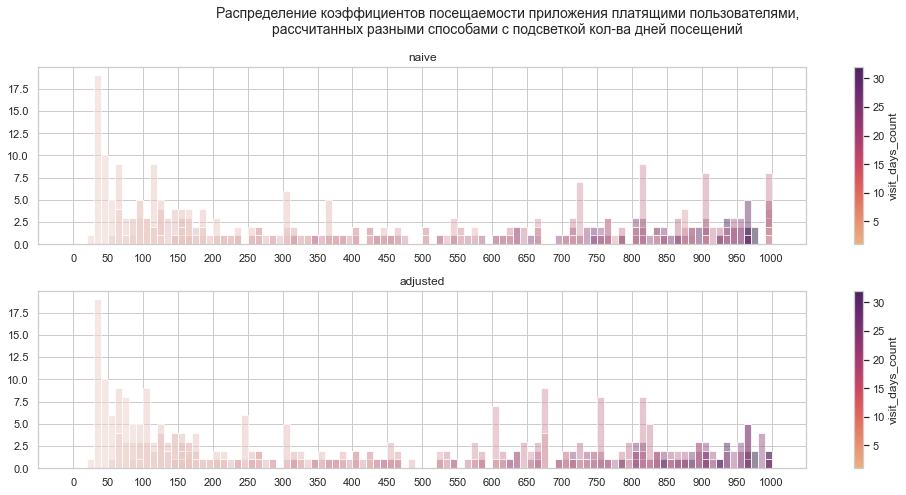

In [207]:
method = ['naive','adjusted']
column = ['visits_frequency_naive','visits_frequency_adjusted']

fig, ax = plt.subplots(2,1,figsize=(14,7), sharey=True)
plt.suptitle(textwrap.fill('Распределение коэффициентов посещаемости приложения платящими пользователями, \
рассчитанных разными способами с подсветкой кол-ва дней посещений',88),
             fontsize=14)
for i in [0,1]:
    sns.histplot(data=s,x=column[i],hue='visit_days_count', ax=ax[i], 
                 binwidth=10, binrange=(0,1000))
    ax[i].set_title(method[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticks(range(0,1001,50))
    ax[i].get_legend().remove()

    colormap = sns.color_palette("flare", as_cmap=True)
    scalarmappaple = cm.ScalarMappable(cmap=colormap)
    scalarmappaple.set_array(range(1,33,1))
    plt.colorbar(scalarmappaple, ax=ax[i]).set_label('visit_days_count')

plt.tight_layout()
plt.show()

Общая тенденция не изменилась - чем больше число посещений, тем больше и коэффициент посещаемости, однако в правой части графиков заметно, что при взвешенном алгоритме расчета среди макcимальных значений коэффициентов посещаемости больше максимальных значений посещений, так как коэффициенты при числе посещений менее 20 скорректированы в меньшую сторону.

Добавим коэффициент посещаемости, рассчитанный с учетом корректировки, в данные платящих пользователей.

In [208]:
paying_users_full = paying_users_full.merge(s[['uid','visits_frequency_adjusted']], on='uid', how='left')

Разделим платящих пользователей на 3 сегмента по коэффициенту посещаемости:

- inactive
- low-active
- reasonably active
- high-active

In [209]:
paying_users_full.visits_frequency_adjusted.quantile([0.33,0.4,0.5,0.75])

0.33    245.0
0.40    325.0
0.50    456.5
0.75    800.0
Name: visits_frequency_adjusted, dtype: float64

Установим границы сегментов на основании особенностей распределения и квантилей.

In [210]:
paying_users_full.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,age_segment,visit_days_count,country_segment,is_paying,is_premium_paid,is_trial_paid,joined_at,days_from_join,visits_frequency_adjusted
0,891152790,29,769,NaN,Spain,"2,5,6",M,16,32,13,1.0,1.0,12597.0,test,29-34,4,Europe,1,1,0,2017-11-08 18:39:00,8,384
1,892333656,50,436,4.0,United States of America,"1,2,3,4",M,47,53,126,NaN,NaN,897.0,test,46+,5,North America,1,0,0,2017-10-16 01:45:00,32,156
2,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",M,18,24,181,1.0,1.0,37817.0,test,16-22,10,Europe,1,1,0,2017-10-31 14:16:00,16,581
3,891343671,26,0,24.0,France,"1,2,3,4,5,6,7,8,9",M,23,35,37,1.0,1.0,21580.0,test,23-28,10,Europe,1,0,1,2017-11-05 13:42:00,11,753
4,892430988,28,181,NaN,United States of America,"1,2",M,25,31,22,1.0,1.0,12727.0,test,23-28,3,North America,1,0,1,2017-10-14 07:02:00,34,88


In [211]:
def visits_frequency_segments(df):
    if df.visit_days != df.visit_days:
        return 'inactive'
    if df.visits_frequency_adjusted <= 500:
        return 'low-active'
    if df.visits_frequency_adjusted > 500 and df.visits_frequency_adjusted <=800:
        return 'reasonably active'
    else:
        return 'high-active'

In [212]:
paying_users_full['visits_frequency_segment'] = paying_users_full.apply(lambda x: visits_frequency_segments(x),1)

In [213]:
round(paying_users_full['visits_frequency_segment'].value_counts(normalize=True).mul(100),1).apply(str) + '%'

low-active           40.7%
high-active          24.8%
reasonably active    23.8%
inactive             10.6%
Name: visits_frequency_segment, dtype: object

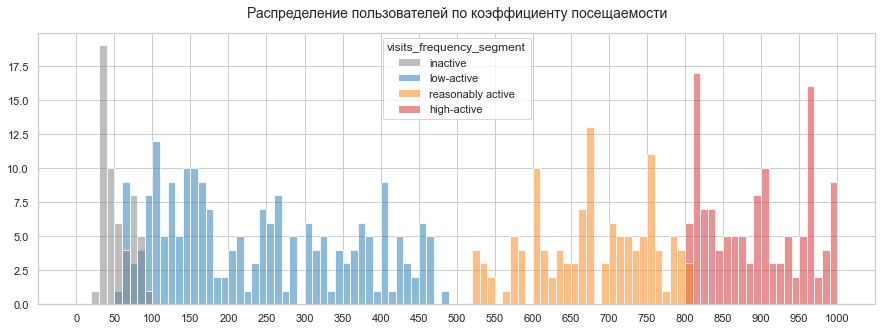

In [214]:
plt.figure(figsize=(15,5))
sns.histplot(data=paying_users_full,x='visits_frequency_adjusted',
             hue='visits_frequency_segment', 
             hue_order=['inactive','low-active','reasonably active','high-active'],
             palette=['tab:grey','tab:blue','tab:orange','tab:red'],
             binwidth=10,binrange=(0,1000))
plt.title('Распределение пользователей по коэффициенту посещаемости',fontsize=14, pad=15)
plt.ylabel('')
plt.xlabel('')
plt.xticks(range(0,1001,50))
plt.show()

### Платежеспособность

Используем аналогичный подход к расчету коэффициента платежеспособности.

Рассмотрим распределение среднего суммарного дохода с пользователя в зависимости от числа дней со дня регистрации, однако, сначала исключим выбросы.

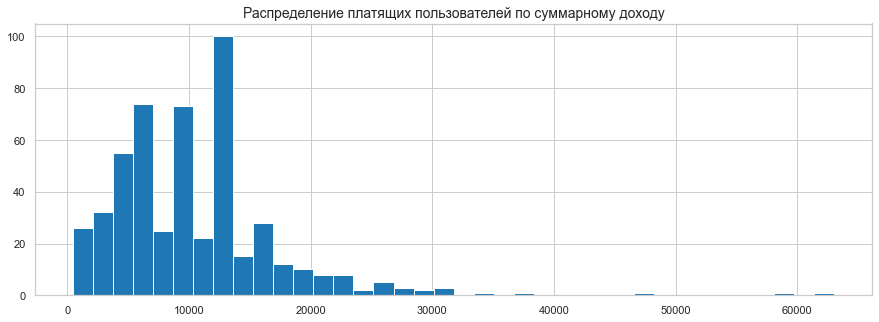

In [215]:
plt.figure(figsize=(15,5))
ax=sns.histplot(data=paying_users_full,x='total_revenue', color='tab:blue',alpha=1)
ax.set_title('Распределение платящих пользователей по суммарному доходу', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

Для прогнозирования оставим пользователей с доходом до 30 000 у.е.

In [216]:
print('Таких пользователей {} - {}% платящих пользователей'.format(
    paying_users_full.query('total_revenue < 30000').shape[0],
    round(paying_users_full.query('total_revenue < 30000').shape[0] *100 / paying_users_full.shape[0], 1)))

Таких пользователей 500 - 98.4% платящих пользователей


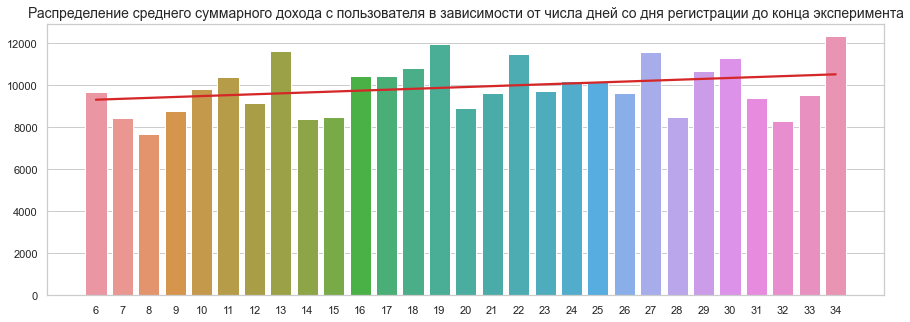

In [217]:
s = paying_users_full.query('total_revenue < 30000').loc[:,['uid','days_from_join','total_revenue']]
p = s.groupby('days_from_join', as_index=False).agg({'total_revenue':'mean'}).round(2)
fig,ax = plt.subplots(figsize=(15,5))
sns.barplot(data=p,x='days_from_join', y='total_revenue', ax=ax)
sns.regplot(x=np.arange(0,len(p)), y=p['total_revenue'], ci=None, marker='', color='tab:red')
ax.set_title('Распределение среднего суммарного дохода с пользователя \
в зависимости от числа дней со дня регистрации до конца эксперимента', fontsize=14)
ax.set_ylabel('')
ax.set_xlabel('')

plt.show()

В целом средний доход распределен достаточно равномерно в зависимости от кол-ва дней в приложении, значит архитекторы эксперимента выбрали в целом достаточный лаг для совершения платежей пользователями, зарегистрировавшимися в последние дни окна регистраций - за 5 дней до финальной отсечки. Но все же есть небольшой возрастающий тренд. Сгладим его на основании расчета прогнозного дохода.

Для корректного моделирования прогнозного дохода, рассмотрим динамику его изменения для платящих пользователей, зарегистрировавшихся как минимум за 20 дней до конца эксперимента (за исключением выбросов).

In [218]:
print('Таких пользователей {} - {}% платящих пользователей'.format(
    paying_users_full.query('days_from_join >= 20 & total_revenue < 30000').shape[0],
    round(paying_users_full.query('days_from_join >= 20 & total_revenue < 30000').shape[0] *100 / 
          paying_users_full.shape[0], 1)))

Таких пользователей 261 - 51.4% платящих пользователей


C:\Games\Anaconda\Anaconda installed\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


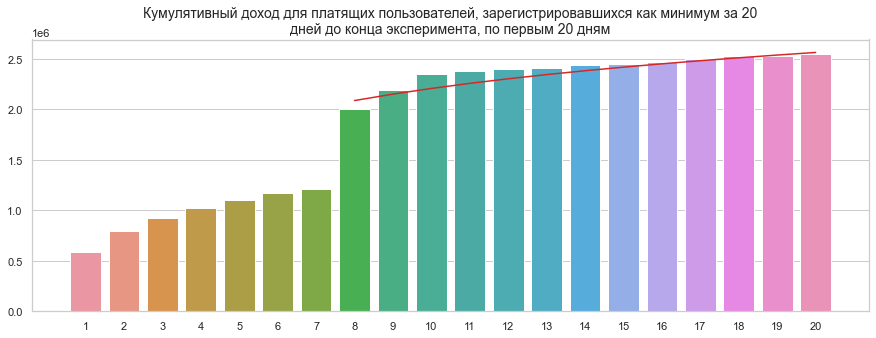

In [219]:
l = paying_users_full.query('days_from_join >= 20 & total_revenue < 30000').uid.unique()
s = transactions_clean.query('uid in @l')
s['paid_at_day_number'] = (s.paid_at - s.joined_at).dt.days + 1
revenue_dist = s.groupby('paid_at_day_number', as_index=False).agg({'revenue':'sum'})\
.query('paid_at_day_number <= 20').sort_values('paid_at_day_number').reindex(index=list(range(20)), fill_value=0)
revenue_dist.loc[19,'paid_at_day_number'] = 19
revenue_dist = revenue_dist.sort_values('paid_at_day_number', ignore_index=True)
revenue_dist['revenue_cum'] = revenue_dist['revenue'].cumsum()

a,b = np.polyfit(np.log(revenue_dist.loc[7:19,'paid_at_day_number']), revenue_dist.loc[7:19,'revenue_cum'], 1)
x = np.array(range(7,20,1))
y = a*np.log(x) + b

fig, ax = plt.subplots(figsize=(15,5), sharex=True, sharey=True)
sns.barplot(data=revenue_dist, x='paid_at_day_number',y='revenue_cum')
plt.plot(x, y, color='tab:red')
plt.xlabel('')
plt.ylabel('')
plt.title(textwrap.fill('Кумулятивный доход для платящих пользователей, зарегистрировавшихся \
как минимум за 20 дней до конца эксперимента, по первым 20 дням', 88), fontsize=14)

plt.show()

На графике видно, что пользователи экономят финансовые резервы в течение первой недели после регистрации, пытаясь обойтись относительно малыми тратами, однако начиная с 8 дня их платежная активность драматично вырастает практически в 2 раза и далее постепенно набирает мощь с убывающей интенсивностью до 20 дня.  

Динамика прироста кумулятивного дохода, начиная с 8-го дня, хорошо описывается логарифмической функцией. На 20-м дне логарифмическая кривая становится практически параллельной оси Х.

In [220]:
revenue_dist

,paid_at_day_number,revenue,revenue_cum
0,1,590421.0,590421.0
1,2,203424.0,793845.0
2,3,135304.0,929149.0
3,4,91442.0,1020591.0
4,5,79131.0,1099722.0
5,6,74373.0,1174095.0
6,7,42159.0,1216254.0
7,8,787215.0,2003469.0
8,9,191061.0,2194530.0
9,10,155194.0,2349724.0


К 20-му дню прирост дохода становится минимальным. 

Привязываться к логарифмической финкции не имеет смысла для прогноза реальных показателей на оновании весьма ограниченных данных. 

Примем, что для пользователей с числом дней в приложении меньше 20, начиная с 20-го дня он не изменяется до конца месяца эксперимента. Таким образом, приведя показатели дохода таких клиентов к прогнозному уровня 20-го дня, с учетом также ранее исключенных выбросов, получим вполне реалистичный умеренно негативный прогноз общего дохода для этой группы пользователей.

In [221]:
def total_revenue_approximation(df):
    x0 = df.days_from_join
    y0 = df.total_revenue
    if x0 >= 20:
        return y0
    else:
        k = revenue_dist.revenue_cum[19] / revenue_dist.revenue_cum[x0-1]
        return round(k*y0)

Рассчитаем прогнозный доход и рассмотрим получившееся разпределение по пользователям.

In [222]:
s = paying_users_full.loc[:,['uid','days_from_join','total_revenue']]

s['total_revenue_adjusted'] = s.apply(lambda x: total_revenue_approximation(x),1)
s.head()

,uid,days_from_join,total_revenue,total_revenue_adjusted
0,891152790,8,12597.0,16031.0
1,892333656,32,897.0,897.0
2,891589239,16,37817.0,39015.0
3,891343671,11,21580.0,23104.0
4,892430988,34,12727.0,12727.0


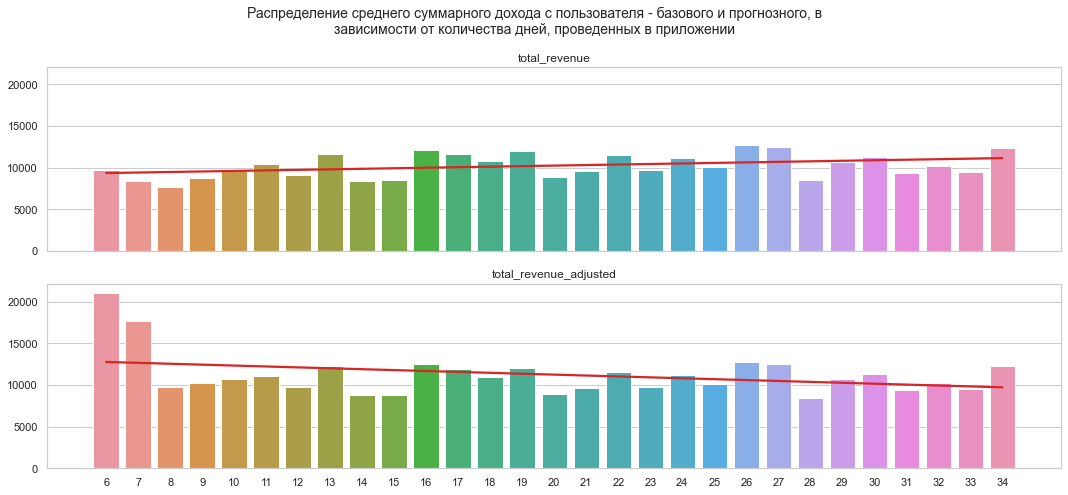

In [223]:
p = s.groupby('days_from_join', as_index=False).agg({'uid':'count',
                                                     'total_revenue':'mean',
                                                     'total_revenue_adjusted':'mean'})\
.rename(columns={'uid':'amount'}).round(3)

method=['total_revenue','total_revenue_adjusted']
fig, ax = plt.subplots(2,1,figsize=(15,7), sharex=True, sharey=True)
plt.suptitle(textwrap.fill('Распределение среднего суммарного дохода с пользователя - \
базового и прогнозного, в зависимости от количества дней, проведенных в приложении',88),
             fontsize=14)
for i in [0,1]:
    sns.barplot(data=p,x='days_from_join', y=method[i], ax=ax[i])
    sns.regplot(x=np.arange(0,len(p)), y=p[method[i]], ci=None, marker='', 
                color='tab:red', ax=ax[i])
    ax[i].set_title(method[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
plt.tight_layout()
plt.show()

На распределениях видно, что средние значения прогнозного дохода для пользователей, зарегистрировавшихся за 7 и 6 дней до конца эксперимента, значительно выше остальных. Рассмотрим показатели этой группы пользователей и установим причину такого дисбаланса.

In [224]:
p.head()

,days_from_join,amount,total_revenue,total_revenue_adjusted
0,6,2,9698.000,21060.500
1,7,7,8438.857,17690.571
2,8,9,7685.889,9781.222
3,9,13,8795.000,10218.385
4,10,28,9827.071,10663.179


In [225]:
s.query('days_from_join <8').sort_values('total_revenue', ascending=False)

,uid,days_from_join,total_revenue,total_revenue_adjusted
363,891112263,7,17290.0,36245.0
337,891080040,7,15132.0,31722.0
492,891068079,6,10296.0,22359.0
202,891092322,7,9945.0,20848.0
130,891071157,6,9100.0,19762.0
251,891120969,7,6292.0,13190.0
467,891077727,7,6292.0,13190.0
473,891075072,7,2327.0,4878.0
403,891118668,7,1794.0,3761.0


In [226]:
s.query('days_from_join >20').total_revenue.mean()

10823.625984251968

На такие высокие прогнозные показатели по пользователям, зарегистрировавшимся в последние дни окна регистраций (за 6 и 7 дней до конца эксперимента) влияют следующие факторы:

- аномально высокие показатели трат значительной части данных пользователей в течение первой недели после регистрации в приложении - на уровне среднего значения общего дохода пользователей, проведших в приложении 20+ дней и выше;

- ранее выявленная динамики роста трат для клиентов с 20+ днями в приложении, экстраполированная на всех пользователей, согласно которой основной рост платежной активности начинается с 8-10 дня в приложении;

- малое число таких пользователей.

Учитывая объективные предпосылки для такого высокого прогноза по данным пользователям, нет оснований для дополнительных корректировок прогноза. 

Рассмотрим прочие примеры корректировок.

In [227]:
s.sort_values('days_from_join').iloc[[1,2,50,87,113,150,205,423],:]

,uid,days_from_join,total_revenue,total_revenue_adjusted
130,891071157,6,9100.0,19762.0
337,891080040,7,15132.0,31722.0
24,891242403,10,1456.0,1580.0
380,891323850,11,13273.0,14210.0
221,891409599,12,4537.0,4819.0
22,891499695,14,9698.0,10139.0
219,891676365,18,5135.0,5168.0
78,892202526,29,2691.0,2691.0


С учетом всех вводных, описанных выше, прогноз кажется вполне реалистичным.

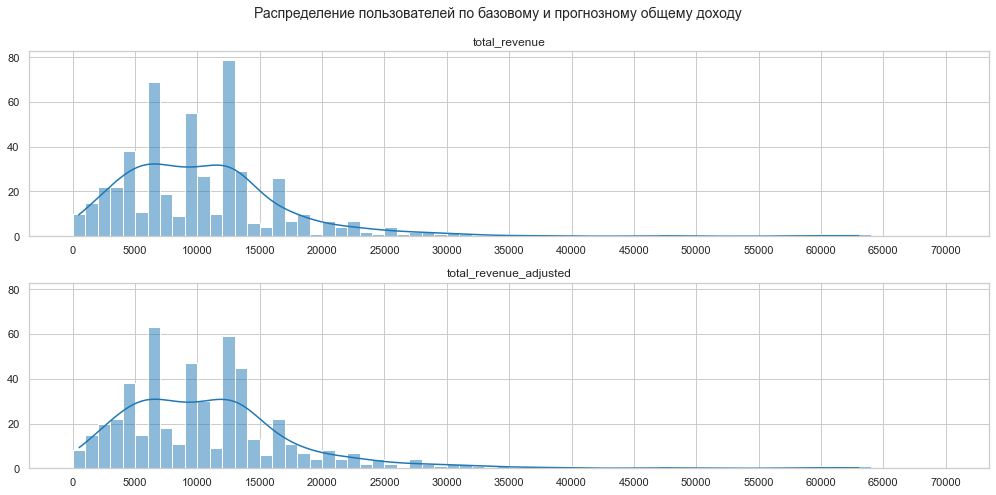

In [228]:
method = ['total_revenue','total_revenue_adjusted']

fig, ax = plt.subplots(2,1,figsize=(14,7), sharey=True)
plt.suptitle('Распределение пользователей по базовому и прогнозному общему доходу',
             fontsize=14)
for i in [0,1]:
    sns.histplot(data=s,x=method[i], ax=ax[i], color='tab:blue', kde=True, 
                 binwidth=1000,binrange=(0,70000))
    ax[i].set_title(method[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticks(range(0,70001,5000))

plt.tight_layout()
plt.show()

In [229]:
s[['total_revenue','total_revenue_adjusted']].apply(['count','median','mean','std']).round()

,total_revenue,total_revenue_adjusted
count,508.0,508.0
median,9607.0,9932.0
mean,10490.0,10934.0
std,7021.0,7311.0


Общая картина не сильно изменилась при расчете прогнозного дохода, однако для некоторых отдельных пользователей главный показатель платежеспособности стал более объективным.

Добавим прогнозный доход в данные платящих пользователей в общий массив по пользователям.

In [230]:
paying_users_full = paying_users_full.merge(s[['uid','total_revenue_adjusted']], on='uid', how='left')

In [231]:
users_clean_full = users_clean_full.merge(paying_users_full[['uid','total_revenue_adjusted']], on='uid', how='left')
users_clean_full['total_revenue_adjusted'] = users_clean_full['total_revenue_adjusted'].fillna(0)

In [232]:
paying_users_full.shape[0]

508

Разделим платящих пользователей на 3 сегмента по прогнозному общему доходу:

- moderate spenders
- enthusiastic customers
- hardcore wasters

In [233]:
paying_users_full.total_revenue_adjusted.quantile([0.5,0.85])

0.50     9932.0
0.85    16601.0
Name: total_revenue_adjusted, dtype: float64

Установим границы сегментов на основании особенностей распределения (впадины по kde) и квантилей.

In [234]:
def total_revenue_segments(x):
    if x <= 9932:
        return 'moderate spenders'
    if x > 9932 and x <= 16601:
        return 'enthusiastic spenders'
    else:
        return 'hardcore wasters'

In [235]:
paying_users_full['revenue_segment'] = paying_users_full.total_revenue_adjusted\
.apply(lambda x: total_revenue_segments(x))

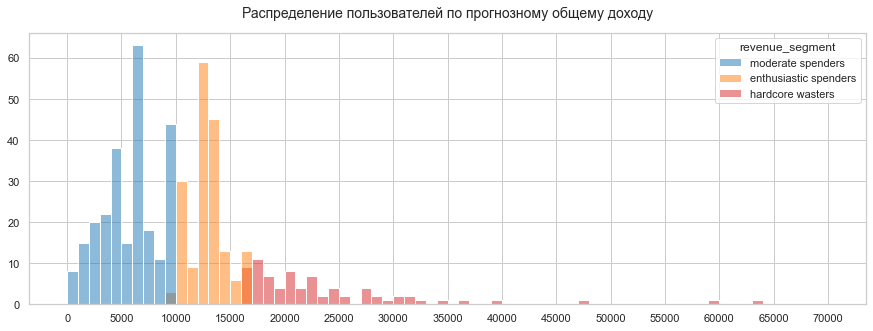

In [236]:
plt.figure(figsize=(15,5))
sns.histplot(data=paying_users_full,x='total_revenue_adjusted', color='tab:blue',
             hue='revenue_segment',
             hue_order=['moderate spenders','enthusiastic spenders','hardcore wasters'],
             palette=['tab:blue','tab:orange','tab:red'],
             binwidth=1000,binrange=(0,70000))
plt.title('Распределение пользователей по прогнозному общему доходу',fontsize=14, pad=15)
plt.ylabel('')
plt.xlabel('')
plt.xticks(range(0,70001,5000))
plt.show()

### Продуктовые предпочтения

Распределим платящих пользователей по купленным продуктам на 3 категории:

- купили только подписки

- купили и подписки, и прочие продукты (монеты, и проч.)

- купили только прочие продукты.

In [237]:
paying_users_full = paying_users_full.merge(transactions_clean.groupby('uid', as_index=False).agg({'product_type':'unique'})\
.rename(columns={'product_type':'product_types_paid'}), on='uid', how='left')
paying_users_full.product_types_paid.head()

0                    [premium_no_trial]
1                               [coins]
2             [coins, premium_no_trial]
3    [coins, trial_premium, other_type]
4                       [trial_premium]
Name: product_types_paid, dtype: object

In [238]:
def products_class(x):
    if ('premium' in str(x)) and (('coins' in str(x)) == ('other' in str(x)) == False):
         return 'subscription only'
    if ('premium' in str(x)) == False:
         return 'non-subscription products only'
    if ('premium' in str(x)) and (('coins' in str(x)) == True or ('other' in str(x)) == True):
         return 'both subscription and non-subscription products'

In [239]:
paying_users_full['products_class'] = paying_users_full.product_types_paid.apply(lambda x: products_class(x))

In [240]:
paying_users_full[['product_types_paid','products_class']].head()

,product_types_paid,products_class
0,[premium_no_trial],subscription only
1,[coins],non-subscription products only
2,"[coins, premium_no_trial]",both subscription and non-subscription products
3,"[coins, trial_premium, other_type]",both subscription and non-subscription products
4,[trial_premium],subscription only


In [241]:
paying_users_full.products_class.value_counts(normalize=True).mul(100).reset_index().round(1)\
.rename(columns={'index':'products_class', 'products_class':'% of paying users'})

,products_class,% of paying users
0,subscription only,60.6
1,both subscription and non-subscription products,25.0
2,non-subscription products only,14.4


Большая часть платящих пользователей (60.6%) покупала в течение месяца эксперимента только подписки, четверть платящих пользователей покупала не только подписки, но и прочие продукты, остальные 14.4% - только прочие продукты.

Сегментация по другим признакам нецелесообразна.

### Сводные данные по пользователям

Рассмотрим пользователей в разрезе полученных сегментов.

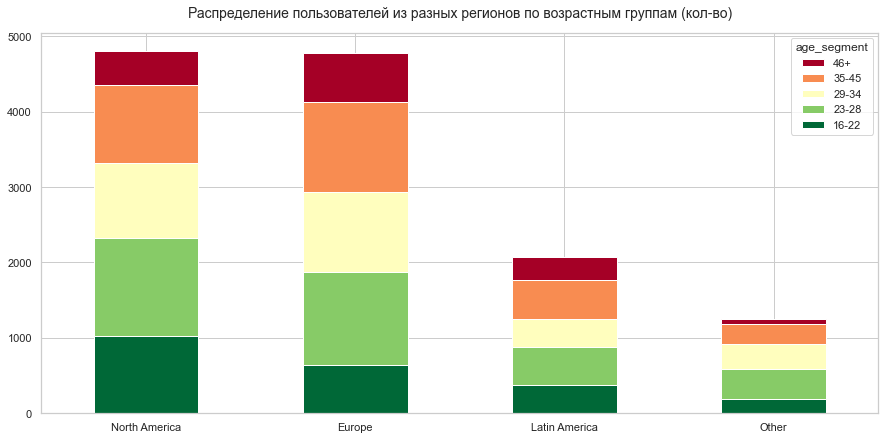

In [242]:
MF = users_clean_full.pivot_table(index='country_segment', columns='age_segment', 
                                                      values='uid', aggfunc='count',margins=True)\
.sort_values('All', ascending=False).iloc[1:,:]
ax=MF.iloc[:,:-1].plot(kind='bar', stacked=True, figsize=(15,7),colormap='RdYlGn_r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='age_segment')
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Распределение пользователей из разных регионов по возрастным группам (кол-во)', 
          fontsize=14, pad=15)
plt.show()

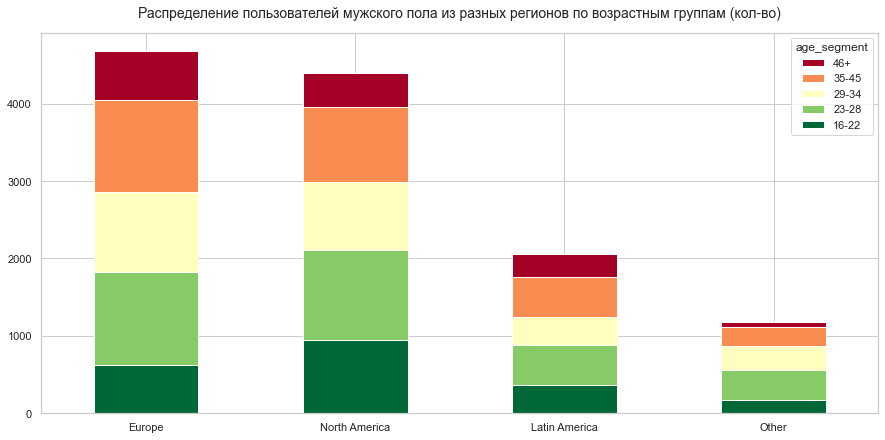

In [243]:
M = users_clean_full.query('gender=="M"').pivot_table(index='country_segment', columns='age_segment', 
                                                      values='uid', aggfunc='count',margins=True)\
.sort_values('All', ascending=False).iloc[1:,:-1]
ax=M.plot(kind='bar', stacked=True, figsize=(15,7),colormap='RdYlGn_r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='age_segment')
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Распределение пользователей мужского пола из разных регионов по возрастным группам (кол-во)', 
          fontsize=14, pad=15)
plt.show()

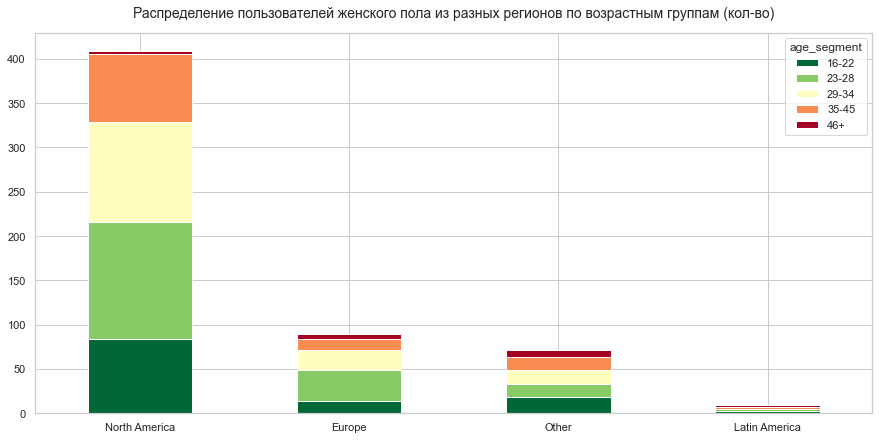

In [244]:
F = users_clean_full.query('gender=="F"').pivot_table(index='country_segment', columns='age_segment', 
                                                      values='uid', aggfunc='count',margins=True)\
.sort_values('All', ascending=False).iloc[1:,:-1]
F.plot(kind='bar', stacked=True, figsize=(15,7),colormap='RdYlGn_r')
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Распределение пользователей женского пола из разных регионов по возрастным группам (кол-во)', 
          fontsize=14, pad=15)
plt.show()

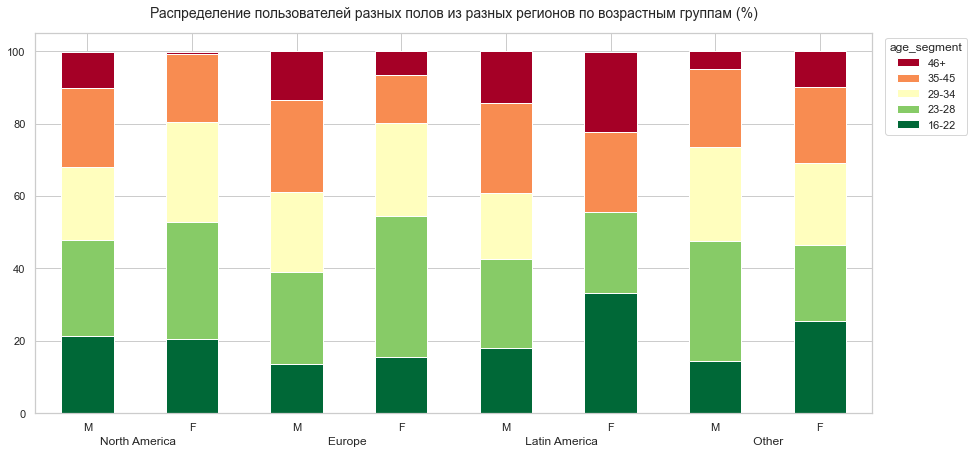

In [245]:
df = users_clean_full.pivot_table(index=['country_segment','gender'], columns='age_segment', values='uid', 
                                  aggfunc='count').apply(lambda x: round(x*100/x.sum(),1),1)\
.reset_index().sort_values(['country_segment','gender'], ascending=[0,0])\
.set_index('gender').iloc[[2,3,6,7,4,5,0,1],:]
ax=df.plot(kind='bar', stacked=True, figsize=(15,7),
          colormap='RdYlGn_r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='age_segment', bbox_to_anchor=(1.12,1), loc="upper right")
plt.xticks(rotation=0)
plt.xlabel('North America                                             \
Europe                                   \
            Latin America                                  \
            Other       ')
plt.title('Распределение пользователей разных полов из разных регионов по возрастным группам (%)', fontsize=14, pad=15)
plt.show()

Для основной аудитории приложения - представителей североамериканских стран и европейцев характерно равенство или превышение доли старшей возрастной группы (от 29 лет) над молодой для мужчин и обратный тренд для женщин. Для выводов о соотношениях поло-возрастного состава по остальным регионам недостаточно данных по женщинам.

In [246]:
users_clean_full.pivot_table(index=['country_segment','gender'], columns='age_segment', values='uid', 
                                  aggfunc='count',margins=True).fillna(0)\
.reset_index().sort_values(['country_segment','gender'], ascending=[0,0])\
.set_index(['country_segment','gender']).iloc[[2,3,6,7,4,5,0,1],:]\
.style.background_gradient(subset=MF.columns[0:5], axis=None)\
.format('{:.0f}',subset=MF.columns[0:6])

In [247]:
s = users_clean_full.groupby(['gender','country_segment','age_segment'], as_index=False).agg({'uid':'count'})\
.rename(columns={'uid':'amount'}).sort_values('amount', ascending=False)
s['%_of_users'] = round(s.amount *100 / s.amount.sum(),1)
s['%_of_users_cum'] = s['%_of_users'].cumsum()
s.head(10)

,gender,country_segment,age_segment,amount,%_of_users,%_of_users_cum
20,M,Europe,23-28,1192,9.2,9.2
22,M,Europe,35-45,1187,9.2,18.4
30,M,North America,23-28,1164,9.0,27.4
21,M,Europe,29-34,1037,8.0,35.4
32,M,North America,35-45,960,7.4,42.8
29,M,North America,16-22,943,7.3,50.1
31,M,North America,29-34,884,6.9,57.0
23,M,Europe,46+,636,4.9,61.9
19,M,Europe,16-22,630,4.9,66.8
27,M,Latin America,35-45,513,4.0,70.8


Типичными пользователями нашего приложения являются мужчины 23-28 лет из Европы и Северной Америки, также приложение популярно у европейских мужчин 35-45 лет. Вместе эти три группы пользователей составляют более четверти всех пользователей приложения.

In [248]:
s = users_clean_full.groupby(['gender','country','age_segment'], as_index=False).agg({'uid':'count'})\
.rename(columns={'uid':'amount'}).sort_values('amount', ascending=False)
s['%_of_users'] = round(s.amount *100 / s.amount.sum(),1)
s['%_of_users_cum'] = s['%_of_users'].cumsum()
s.head(10)

,gender,country,age_segment,amount,%_of_users,%_of_users_cum
232,M,United States of America,23-28,1089,8.4,8.4
231,M,United States of America,16-22,912,7.1,15.5
234,M,United States of America,35-45,838,6.5,22.0
233,M,United States of America,29-34,796,6.2,28.2
235,M,United States of America,46+,370,2.9,31.1
70,M,Argentina,35-45,298,2.3,33.4
68,M,Argentina,23-28,291,2.3,35.7
114,M,France,23-28,287,2.2,37.9
116,M,France,35-45,282,2.2,40.1
115,M,France,29-34,270,2.1,42.2


Если смотреть по странам, типичный пользователь нашего приложения - мужчина из США в возрасте от 16 до 45 лет - таких пользователей 28.2%.

### Платящие пользователи

По платящим пользователям кроме демографических характеристик у нас также есть характеристики посещаемости, дохода и продуктовых предпочтений.

Рассмотрим пользователей в координатах  прогнозной месячной посещаемости и прогнозного месячного дохода с подсветкой предпочитаемого набора продуктов.

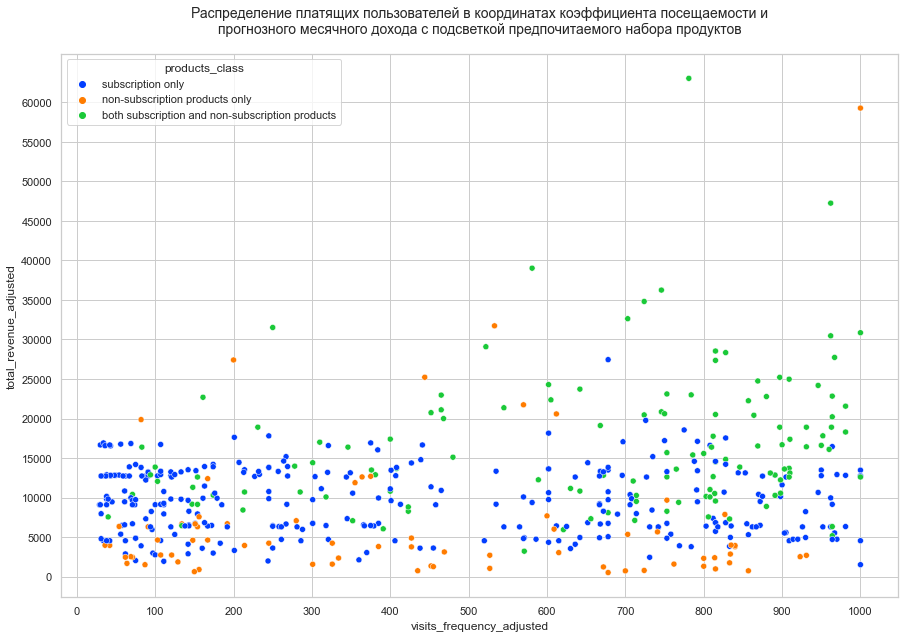

In [249]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=paying_users_full,x='visits_frequency_adjusted',y='total_revenue_adjusted',hue='products_class',
               palette='bright')
plt.title(textwrap.fill('Распределение платящих пользователей в координатах коэффициента посещаемости и \
                        прогнозного месячного дохода с подсветкой предпочитаемого набора продуктов', 88), 
          fontsize=14, pad=20)
plt.yticks(range(0,60001,5000))
plt.xticks(range(0,1001,100))
plt.show()

Самая высокая плотноть точек в квадрате до 200 по коэффициенту посещаемости и до 20000 по уровню дохода.

Тренд повышения дохода с ростом частоты посещений проглядывается только для пользователей с высокими тратами (>30 тыс.)

Обращают на себя внимание пользователи, не оформившие подписку, с доходом более 20, местами до 60 тыс.

Также примечательно наличие пользователя, купившего и подписку и монеты, при этом уложившись в 5 тыс.

Рассмотрим распределение платящих пользователей по осям посещаемости-привлекательности (ограничимся пользователями с числом просмотров профиля > 10), с подсветкой уровня трат.

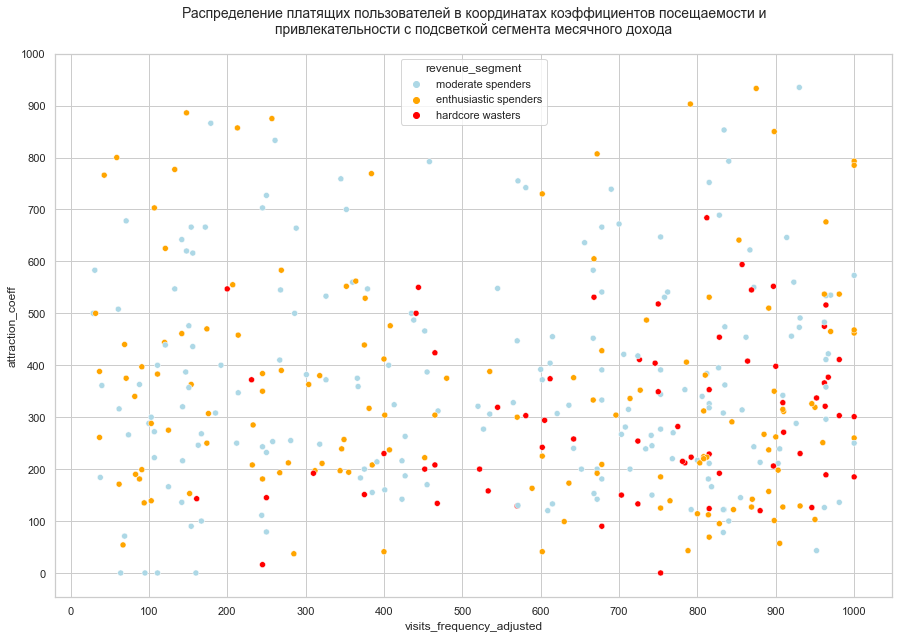

In [250]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=paying_users_full.query('views_count >= 10'),x='visits_frequency_adjusted',y='attraction_coeff',
                hue='revenue_segment', hue_order=['moderate spenders','enthusiastic spenders','hardcore wasters'],
                palette=['lightblue','orange','red'])
plt.title(textwrap.fill('Распределение платящих пользователей в координатах коэффициентов посещаемости и \
                        привлекательности с подсветкой сегмента месячного дохода', 88), 
          fontsize=14, pad=20)
plt.yticks(range(0,1001,100))
plt.xticks(range(0,1001,100))
plt.show()

Низко- и среднедоходные пользователи распределены достаточно равномерно по осям посещаемости и привлекательности. А вот плотность точек наиболее платежно активных пользователей явно смещена в сторону высокой посещаемости и низкой-средней привлекательности (правый нижний квадрант).

## 3. Результаты эксперимента

Рассмотим ключевые метрики, на основании которых будет оценена успешность эксперимента. 

Напомним, что в рамках данного эксперимента для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы (при этом стоимость пробного периода оставалась прежней).

Список метрик:
- доля платящих пользователей
- средний доход на одного пользователя
- средний доход на одного платящего пользователя
- доля пользователей, купивших полную премиум-подписку
- доля пользователей, купивших пробную премиум-подписку

In [251]:
s = users_clean_full.groupby('group', as_index=False).agg({'uid':'count', 'is_paying':'sum', 'is_premium_paid':'sum',\
'is_trial_paid':'sum','total_revenue':'mean'}).rename(columns={'uid':'users', 'total_revenue':'ARPU'}).round(2)
s = s.append(s.mean(numeric_only=True).round(2), ignore_index=True)
s.iloc[3,0] = 'mean'

s['is_paying(%)'] = round(s['is_paying'] *100 / s['users'], 2)
s['is_paying(%)_delta_%%'] = round((s['is_paying(%)'] - s['is_paying(%)'][0]) *100 / s['is_paying(%)'][0],2)

s['is_premium_paid(%)'] = round(s['is_premium_paid'] *100 / s['users'], 2)
s['is_premium_paid_delta_%%'] = round((s['is_premium_paid(%)'] - s['is_premium_paid(%)'][0]) *100 / \
                                      s['is_premium_paid(%)'][0],2)

s['is_trial_paid(%)'] = round(s['is_trial_paid'] *100 / s['users'], 2)
s['is_trial_paid(%)_delta_%%'] = round((s['is_trial_paid(%)'] - s['is_trial_paid(%)'][0]) *100 / \
                                       s['is_trial_paid(%)'][0],2)

s['ARPU_delta_%'] = round((s['ARPU'] - s['ARPU'][0]) *100 / s['ARPU'][0],2)

s['ARPPU'] = round(s['ARPU'] * s['users'] / s['is_paying'], 2)
s['ARPPU_delta_%'] = round((s['ARPPU'] - s['ARPPU'][0]) *100 / s['ARPPU'][0],2)
final_report_table = s.loc[:,['group', 'users', 
         'is_paying', 'is_paying(%)', 'is_paying(%)_delta_%%', 
         'ARPU', 'ARPU_delta_%', 
         'ARPPU', 'ARPPU_delta_%',
         'is_premium_paid', 'is_premium_paid(%)','is_premium_paid_delta_%%', 
         'is_trial_paid', 'is_trial_paid(%)','is_trial_paid(%)_delta_%%']]
final_report_table

,group,users,is_paying,is_paying(%),is_paying(%)_delta_%%,ARPU,ARPU_delta_%,ARPPU,ARPPU_delta_%,is_premium_paid,is_premium_paid(%),is_premium_paid_delta_%%,is_trial_paid,is_trial_paid(%),is_trial_paid(%)_delta_%%
0,control_1,4334.0,187.00,4.31,0.00,440.07,0.00,10199.27,0.00,95.00,2.19,0.00,67.00,1.55,0.00
1,control_2,4261.0,184.00,4.32,0.23,407.15,-7.48,9428.62,-7.56,99.00,2.32,5.94,53.00,1.24,-20.00
2,test,4299.0,137.00,3.19,-25.99,392.42,-10.83,12313.97,20.73,63.00,1.47,-32.88,59.00,1.37,-11.61
3,mean,4298.0,169.33,3.94,-8.58,413.21,-6.10,10488.26,2.83,85.67,1.99,-9.13,59.67,1.39,-10.32


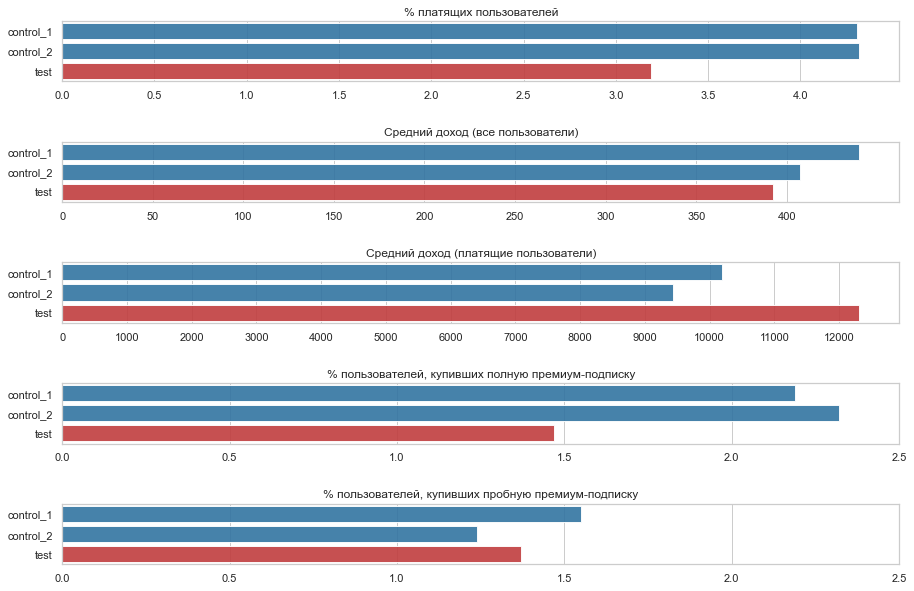

In [252]:
def final_report_graph():
    fig, ax = plt.subplots(5,1,figsize=(15,10))
    ax0 = sns.barplot(data=final_report_table.iloc[0:3,:], x='is_paying(%)', y='group', ax=ax[0],
                      palette=['tab:blue','tab:blue','tab:red'], alpha=0.9)
    ax0.set_xticks(np.arange(0,4.5,0.5))
    ax0.set_title('% платящих пользователей')
    ax0.set_xlabel('')
    ax0.set_ylabel('')
    ax1 = sns.barplot(data=final_report_table.iloc[0:3,:], x='ARPU', y='group', ax=ax[1],
                     palette=['tab:blue','tab:blue','tab:red'], alpha=0.9)
    ax1.set_xticks(np.arange(0,450,50))
    ax1.set_title('Средний доход (все пользователи)')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax2 = sns.barplot(data=final_report_table.iloc[0:3,:], x='ARPPU', y='group', ax=ax[2],
                     palette=['tab:blue','tab:blue','tab:red'], alpha=0.9)
    ax2.set_xticks(np.arange(0,12500,1000))
    ax2.set_title('Средний доход (платящие пользователи)')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax3 = sns.barplot(data=final_report_table.iloc[0:3,:], x='is_premium_paid(%)', y='group', ax=ax[3],
                     palette=['tab:blue','tab:blue','tab:red'], alpha=0.9)
    ax3.set_xticks(np.arange(0,3,0.5))
    ax3.set_title('% пользователей, купивших полную премиум-подписку')
    ax3.set_xlabel('')
    ax3.set_ylabel('')
    ax4 = sns.barplot(data=final_report_table.iloc[0:3,:], x='is_trial_paid(%)', y='group', ax=ax[4],
                     palette=['tab:blue','tab:blue','tab:red'], alpha=0.9)
    ax4.set_xticks(np.arange(0,3,0.5))
    ax4.set_title('% пользователей, купивших пробную премиум-подписку')
    ax4.set_xlabel('')
    ax4.set_ylabel('')
    plt.subplots_adjust(hspace=1)
    plt.show()
final_report_graph()

Предварительные результаты:
- Доля платящих пользователей в тестовой группе уменьшилось.
- Средний чек пользователей в тестовой группе уменьшился.
- Средний чек платящих пользователей в тестовой группе увеличился.
- Доля пользователей, купивших полную премиум-подписку, в тестовой группе уменьшилась.
- Доля пользователей, купивших пробную премиум-подписку, в тестовой группе осталась без изменений.

Проверим статистическую значимость полученных результатов с помощью соответствующих критериев.

### Доля платящих пользователей

Признак платящий/неплатящий (0/1 в колонке 'is_paying') является категориальным, установим стат.значимость различий по данному параметру между группами с помощью критерия Хи-квадрат.

In [253]:
def chisquare(data,metric,group_column,group1,group2):
    data_crosstab = pd.DataFrame()
    for row in data[metric].unique():
        for col in [group1,group2]:
            data_crosstab.loc[row,col] = data[(data[metric] == row) & (data[group_column] == col)][metric].count()
    data_crosstab.loc['Total',:] = data_crosstab.sum()
    if group1 == group2:
        group2 = group2 + '_1'
        data_crosstab[group2] = data_crosstab[group1]
    data_crosstab['Total'] = data_crosstab[group1] + data_crosstab[group2]
    
    chi_square = 0
    for row in data[metric].unique():
        for col in [group1,group2]:
            O = data_crosstab.loc[row,col]
            E = data_crosstab.loc[row,'Total'] * data_crosstab.loc['Total',col] / data_crosstab.loc['Total','Total']
            chi_square += (O-E)**2/E
    p_value = 1 - stats.chi2.cdf(chi_square, (len(data[metric].unique())-1)*(len([group1,group2])-1))
    return chi_square,p_value

In [254]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'is_paying'
for row in groups:
    for col in groups:
        s.loc[row,col] = round(chisquare(users_clean_full, metric,'group',row,col)[1],4)
s

,control_1,control_2,test
control_1,1.0000,0.9936,0.0058
control_2,0.9936,1.0000,0.0059
test,0.0058,0.0059,1.0000


Результаты AA-теста подтверждают равенство двух контрольных групп по доле платящих клиентов. 

P-value для гипотезы о равенстве тестовой группы с обеими контрольными не превышает 0.05, различия статистически значимы.

### Средний доход

Рассмотрим распределение клиентов по доходу.

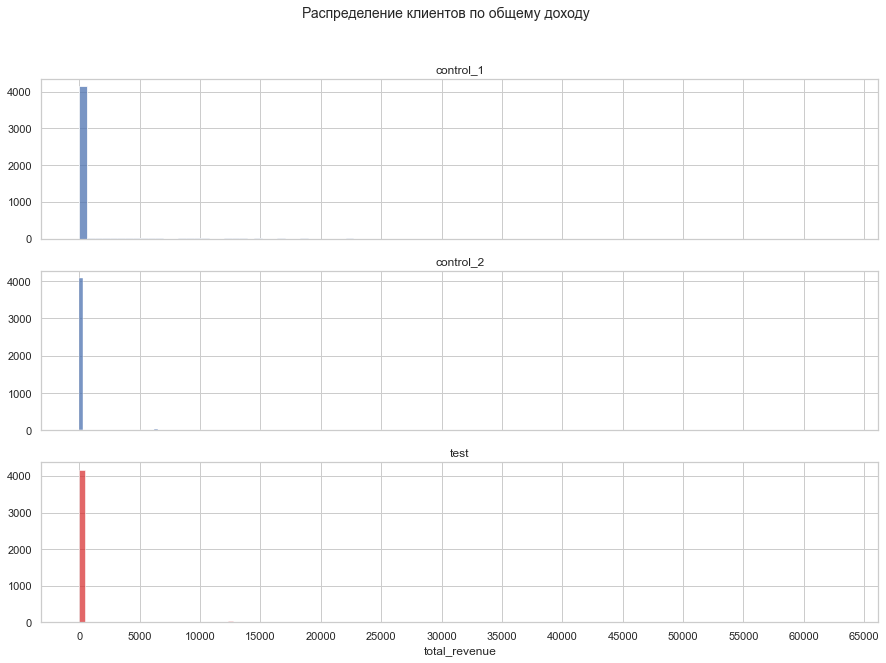

In [255]:
fig, ax = plt.subplots(3,1,figsize = (15, 10), sharex=True)
plt.suptitle('Распределение клиентов по общему доходу', fontsize=14)
ax0 = sns.histplot(data=users_clean_full.query('group == "control_1"'), x = 'total_revenue', bins=100, ax=ax[0])
ax0.set_title('control_1', fontsize=12)
ax1 = sns.histplot(data=users_clean_full.query('group == "control_2"'), x = 'total_revenue', bins=100, ax=ax[1])
ax1.set_title('control_2', fontsize=12)
ax2 = sns.histplot(data=users_clean_full.query('group == "test"'), x = 'total_revenue', bins=100, ax=ax[2],
                   color='tab:red',alpha=0.7)
ax2.set_title('test', fontsize=12)
for i in range(3):
    ax[i].set_ylabel('')

plt.xticks(range(0,70000,5000))
plt.show()

Ранее при предварительной обработке данных были "вычищены" все аномально большие платежи. Реальное распределение сильно скошено к нулю и имеет большой размах засчет аномально высоких показателей нескольких клиентов, поэтому для исследования метрики ARPU наиболее оправданным будет применение критерия Манна-Уитни или метода бутстрапа.

Рассмотрим значения p-value для обоих подходов.

Начнем с критерия Манна-Уитни.

In [256]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'total_revenue'
for row in groups:
    for col in groups:
        a = users_clean_full.query("group == @row")[metric]
        b = users_clean_full.query("group == @col")[metric]
        s.loc[row,col] = round(stats.mannwhitneyu(a,b,alternative='two-sided')[1],4)
s

,control_1,control_2,test
control_1,1.0000,0.9861,0.0072
control_2,0.9861,1.0000,0.0076
test,0.0072,0.0076,1.0000


Результаты AA-теста подтверждают соответствие распределений двух контрольных групп по среднему доходу. 

P-value для гипотезы о равенстве распределений тестовой и обеих контрольных групп не превышает 0.05, различия распределений статистически значимы.

Проведем бутстрапирование, чтобы получить оценку различий по среднему доходу между группами.

In [257]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'total_revenue'
for row in groups:
    for col in groups:
        a = users_clean_full.query("group == @row")[metric]
        b = users_clean_full.query("group == @col")[metric]
        s.loc[row,col] = round(get_bootstrap_pvalue(a,b),4)
s

,control_1,control_2,test
control_1,0.9930,0.5259,0.3456
control_2,0.5301,0.9889,0.7501
test,0.3736,0.8112,0.9745


Результаты AA-теста методом бутстрапа свидетельствуют об отсутствии статистически значимых различий между двумя контрольными группами по среднему доходу. 

В отличие от критерия Манна-Уитни сравнение выборок методом бутстрапа не дало статистически значимых различий между контрольными и тестовой группой. Нет оснований для отклонения гипотезы о равенстве средних.

Рассмотрим распределение средних разностей между значениями тестовой и первой контрольной группы для бутстрапа.

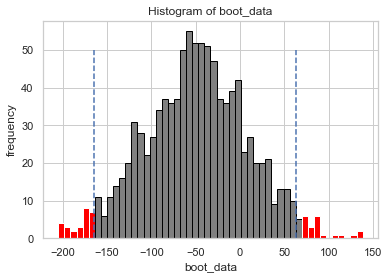

In [258]:
metric = 'total_revenue'
a = users_clean_full.query("group == 'test'")[metric]
b = users_clean_full.query("group == 'control_1'")[metric]
booted_data = get_bootstrap(a,b)

Несмотря на вхождение значения 0 в рассчитанный доверительный 95%-интервал для средних разностей между значениями тестовой и первой контрольной группы методом бутстрапа, их распределение имеет явное отрицательное смещение с центром примерно в -50. Это соответствует рассчитаной разности средних, полученной в предварительном расчете.

Рассмотрим распределение средних разностей между значениями тестовой и второй контрольной группы для бутстрапа.

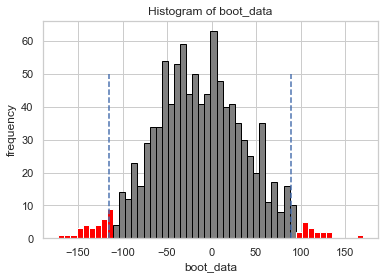

In [259]:
metric = 'total_revenue'
a = users_clean_full.query("group == 'test'")[metric]
b = users_clean_full.query("group == 'control_2'")[metric]
booted_data = get_bootstrap(a,b)

Со второй контрольной группой такое смещение уже явно не проглядывается.

Тем не менее, основания для признания различий стат.значимыми отсутствуют.

Удостоверимся в независимости полученных результатов от особенностей распределения дат регистраций пользователей в течение эксперимента, сравнив также прогнозные показатели дохода.

Проведем бутстрапирование, чтобы получить оценку различий по среднему доходу между группами.

In [260]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'total_revenue_adjusted'
for row in groups:
    for col in groups:
        a = users_clean_full.query("group == @row")[metric]
        b = users_clean_full.query("group == @col")[metric]
        s.loc[row,col] = round(get_bootstrap_pvalue(a,b),4)
s

,control_1,control_2,test
control_1,0.9979,0.6185,0.3378
control_2,0.6138,0.9938,0.6689
test,0.3688,0.6573,0.9491


Ранее полученные результаты подтвердились.

### Средний доход на одного платящего пользователя

Рассмотрим распределение платящих клиентов по общему доходу.

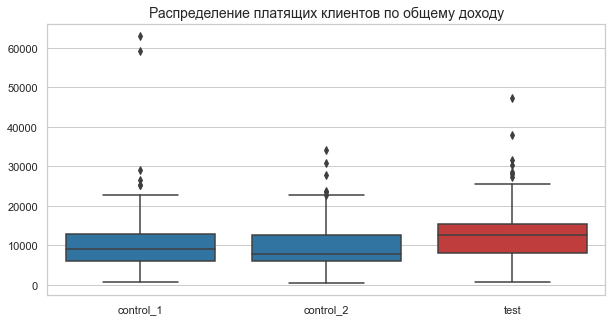

In [261]:
plt.figure(figsize=(10,5))
plt.title('Распределение платящих клиентов по общему доходу', fontsize=14)
sns.boxplot(data=users_clean_full.query('is_paying == 1'), x='group', y='total_revenue',
            order=['control_1','control_2','test'],
            palette=['tab:blue','tab:blue','tab:red'])
plt.xlabel('')
plt.ylabel('')
plt.show()

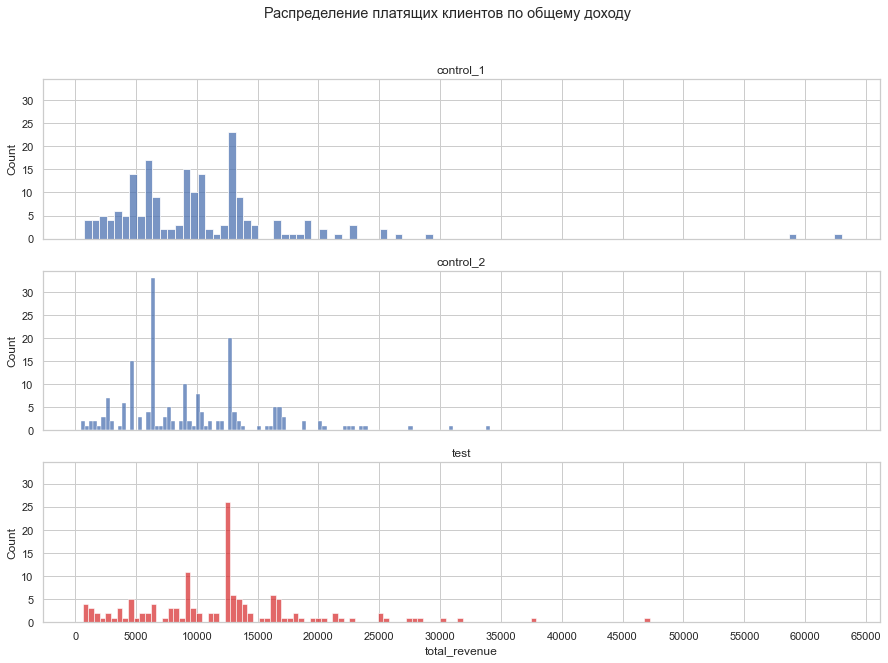

In [262]:
fig, ax = plt.subplots(3,1,figsize = (15, 10), sharex=True, sharey=True)
plt.suptitle('Распределение платящих клиентов по общему доходу')
ax0 = sns.histplot(data=users_clean_full.query('is_paying == 1 and group == "control_1"'), 
                   x = 'total_revenue', bins=100, ax=ax[0])
ax0.set_title('control_1')
ax1 = sns.histplot(data=users_clean_full.query('is_paying == 1 and group == "control_2"'), 
                   x = 'total_revenue', bins=100, ax=ax[1])
ax1.set_title('control_2')
ax2 = sns.histplot(data=users_clean_full.query('is_paying == 1 and group == "test"'), 
                   x = 'total_revenue', bins=100, ax=ax[2], color='tab:red', alpha=0.7)
ax2.set_title('test')

plt.xticks(range(0,70000,5000))
plt.show()

По нескольким клиентам есть аномально высокие показатели во всех трех группах (примеры рассмотрены выше), поэтому для этой метрики используем подход, аналогичный предыдущему.

Начнем с критерия Манна-Уитни.

In [263]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'total_revenue'
for row in groups:
    for col in groups:
        a = users_clean_full.query("is_paying == 1 and group == @row")[metric]
        b = users_clean_full.query("is_paying == 1 and group == @col")[metric]
        s.loc[row,col] = round(stats.mannwhitneyu(a,b,alternative='two-sided')[1],4)
s

,control_1,control_2,test
control_1,0.9996,0.3171,0.0014
control_2,0.3171,0.9996,0.0001
test,0.0014,0.0001,0.9994


Результаты AA-теста подтверждают соответствие распределений двух контрольных групп по среднему доходу на платящего клиента. 

P-value для гипотезы о равенстве распределений тестовой и обеих контрольных групп не превышает 0.05, различия распределений статистически значимы.

Проведем бутстрапирование, чтобы получить оценку различий по среднему доходу на платящего клиента между группами.

In [264]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'total_revenue'
for row in groups:
    for col in groups:
        a = users_clean_full.query("is_paying == 1 and group == @row")[metric]
        b = users_clean_full.query("is_paying == 1 and group == @col")[metric]
        s.loc[row,col] = round(get_bootstrap_pvalue(a,b),4)
s

,control_1,control_2,test
control_1,0.9588,0.2534,0.0087
control_2,0.2884,0.9758,0.0000
test,0.0061,0.0000,0.9988


Результаты сравнения средних методом бутстрапа позволяют сделать вывод о статистически значимых различиях между средними доходом на платящего клиента в тестовой и контрольных группах.

Удостоверимся в независимости полученных результатов от особенностей распределения дат регистраций пользователей в течение эксперимента, сравнив также прогнозные показатели дохода.

Проведем бутстрапирование, чтобы получить оценку различий по среднему доходу между группами.

In [265]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'total_revenue_adjusted'
for row in groups:
    for col in groups:
        a = users_clean_full.query("is_paying == 1 and group == @row")[metric]
        b = users_clean_full.query("is_paying == 1 and group == @col")[metric]
        s.loc[row,col] = round(get_bootstrap_pvalue(a,b),4)
s

,control_1,control_2,test
control_1,0.9824,0.3679,0.0102
control_2,0.3510,0.9751,0.0002
test,0.0068,0.0002,0.9921


Ранее полученные результаты подтвердились.

### Доля пользователей, купивших полную премиум-подписку

Установим стат.значимость различий по данному параметру между группами с помощью критерия Хи-квадрат.

In [266]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'is_premium_paid'
for row in groups:
    for col in groups:
        s.loc[row,col] = round(chisquare(users_clean_full, metric,'group',row,col)[1],4)
s

,control_1,control_2,test
control_1,1.0000,0.6817,0.0118
control_2,0.6817,1.0000,0.0036
test,0.0118,0.0036,1.0000


Результаты AA-теста подтверждают равенство двух контрольных групп по доле платящих клиентов. 

P-value для гипотезы о равенстве тестовой группы с обеими контрольными не превышает 0.05, различия статистически значимы.

### Доля пользователей, купивших пробную премиум-подписку

Установим стат.значимость различий по данному параметру между группами с помощью критерия Хи-квадрат.

In [267]:
s = pd.DataFrame()
groups = ['control_1', 'control_2', 'test']
metric = 'is_trial_paid'
for row in groups:
    for col in groups:
        s.loc[row,col] = round(chisquare(users_clean_full, metric,'group',row,col)[1],4)
s

,control_1,control_2,test
control_1,1.0000,0.2327,0.5015
control_2,0.2327,1.0000,0.6007
test,0.5015,0.6007,1.0000


Результаты AA-теста подтверждают равенство двух контрольных групп по доле платящих клиентов. 

P-value для гипотезы о равенстве тестовой группы с обеими контрольными также сильно превышает 0.05, что логично, цена пробной премиум-подписки не менялась.

### Итоговые общие выводы по эксперименту:
Ранее в ходе анализа размера платежей по премиум-подписке в контрольных и экспериментальной группе было установлено, что для новых пользователей в тестовой группе стоимость полной премиум-подписки через две новые платежные системы была изменена в большую сторону.

По итогам анализа результатов эксперимента с помощью метода бутстрапа было установлено отсутствие статистически значимых изменений среднего дохода на одного пользователя в тестовой группе относительно контрольных.

При этом с помощью критерия Хи-квадрат было установлено статистически значимое уменьшенние доли платящих клиентов, так же как и доли клиентов, купивших полную премиум-подписку.

Снижение среднего чека в пересчете на всех пользователей было нивелировано за счет статистически значимого повышения среднего чека платящих пользователей, установленного с помощью метода бутстрапа.

В целом эксперимент нельзя считать удачным: целевая метрика (средний доход в пересчете на всех пользователей) не увеличилась, в то время как доля платящих пользователей сократилась.

Какие-либо конкретные группы пользователей, для которых нововведение имело бы смысл, не выявлены.

## 4. Поиск групп клиентов, для которых нововведение имело бы смысл

Второй вопрос в задании был следующим: имеет ли нововведение смысл среди каких-либо конкретных групп пользователей? 

Так как у нас нет сведений о платежных системах для платежей, для того, чтобы ответить на этот вопрос, необходимо выявить пользователей тестовой группы, купивших подписку по новой цене, и найти их отличительные признаки от пользователей тестовой группы, тоже имевших такую возможность, но купивших подписку через старые платежные системы по старой цене.

В ходе разведывательного анализа было установлено, что максимальные значения платежей по премиум-подписке принадлежат именно тестовой группе. Засчет этих значений в правой части графика распределения средний размер оплаты премиум-подписки выше. Было принято допущение, что цена премиум-подписки для тестовой группы при оплате через две новые платежные системы увеличена. 

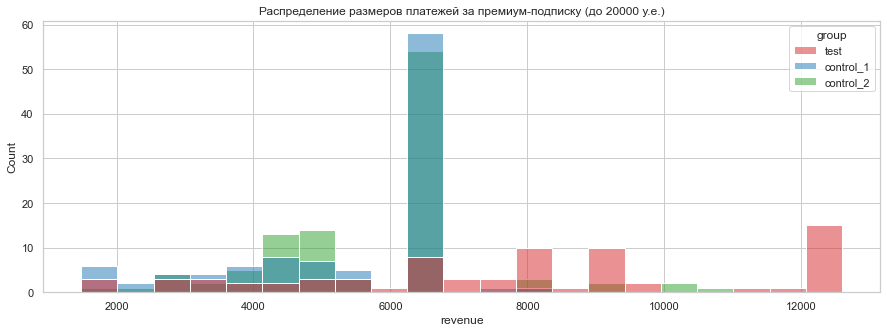

In [268]:
plt.figure(figsize=(15,5))
palette = {'test':'tab:red', 'control_1':'tab:blue', 'control_2':'tab:green'}
sns.histplot(data=transactions.query('product_type == "premium_no_trial" &\
                                      revenue < 20000'),
             x='revenue',hue='group',palette=palette)\
.set_title('Распределение размеров платежей за премиум-подписку (до 20000 у.е.)')
plt.show()

Таким образом, для того, чтобы выявить пользователей тестовой группы, купивших полную премиум-подписку через две новые платежные системы по более высокой цене, необходимо рассмотреть варианты цены данной подписки в тестовой группе, превышающие максимальное значение цен контрольных групп.

In [269]:
transactions_clean.query('product_type == "premium_no_trial"').groupby('group', as_index=False)\
.agg({'revenue':'max'}).rename(columns={'revenue':'revenue_max'}).head(2)

,group,revenue_max
0,control_1,7930.0
1,control_2,10608.0


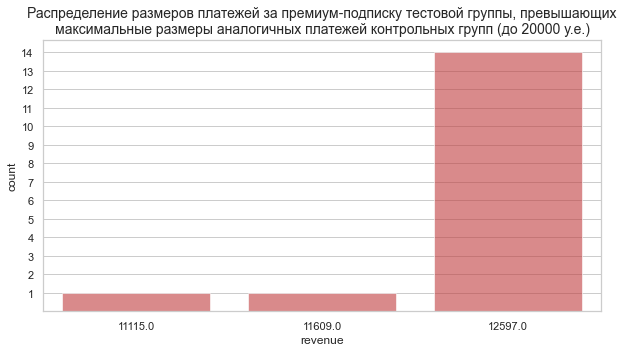

In [270]:
plt.figure(figsize=(10,5))
sns.countplot(data=transactions_clean.query('product_type == "premium_no_trial" &\
                                      revenue < 20000 &\
                                      revenue > 10608'),
                                      x='revenue',
                                      color='tab:red',
                                      alpha=0.6)\
.set_title(textwrap.fill('Распределение размеров платежей за премиум-подписку тестовой группы, \
превышающих максимальные размеры аналогичных платежей контрольных групп (до 20000 у.е.)', width=80,
                         break_long_words=False), fontsize=14)
plt.yticks(range(1,15,1))
plt.show()

Будем считать, что стоимость премиум-подписки при оплате через две новые платежные системы в тестовой группе составляла 12597.0 у.е., таких пользователей 14. Остальные варианты цен малочисленны (по одному платежу на каждый) и близки к ценам контрольных групп, поэтому их будем считать старыми ценами (через старые платежные системы).

Выделим две группы платящих тестовых пользователей в отдельный датасет.

In [271]:
pd.set_option('display.max_columns',30)

In [272]:
s = transactions_clean.query('group == "test" and \
                                      product_type == "premium_no_trial"').copy()
s['accepted_new_price'] = s.revenue.apply(lambda x: 'yes' if x == 12597 else 'no')
s = s[['uid','joined_at','paid_at','accepted_new_price']]\
.sort_values(['accepted_new_price','paid_at'],ascending=[False,True]).drop_duplicates(subset='uid')
users_test_premium = paying_users_full.merge(s[['uid','accepted_new_price']],how='inner',on='uid')
users_test_premium.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,age_segment,visit_days_count,country_segment,is_paying,is_premium_paid,is_trial_paid,joined_at,days_from_join,visits_frequency_adjusted,visits_frequency_segment,total_revenue_adjusted,revenue_segment,product_types_paid,products_class,accepted_new_price
0,891152790,29,769,NaN,Spain,"2,5,6",M,16,32,13,1.0,1.0,12597.0,test,29-34,4,Europe,1,1,0,2017-11-08 18:39:00,8,384,low-active,16031.0,enthusiastic spenders,[premium_no_trial],subscription only,yes
1,891589239,21,303,37.0,Italy,"1,2,3,4,5,6,7,8,9",M,18,24,181,1.0,1.0,37817.0,test,16-22,10,Europe,1,1,0,2017-10-31 14:16:00,16,581,reasonably active,39015.0,hardcore wasters,"[coins, premium_no_trial]",both subscription and non-subscription products,yes
2,891806436,32,57,NaN,Italy,"1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19",M,20,35,69,1.0,1.0,12597.0,test,29-34,19,Europe,1,1,0,2017-10-27 08:51:00,21,905,high-active,12597.0,enthusiastic spenders,[premium_no_trial],subscription only,yes
3,891882681,36,408,76.0,Belgium,"1,2,3,5,6,7,8,9,10,11,12,14,16,17,18,19,20,21",M,33,39,71,1.0,1.0,20410.0,test,35-45,19,Europe,1,1,0,2017-10-25 17:25:00,22,864,high-active,20410.0,hardcore wasters,"[coins, premium_no_trial]",both subscription and non-subscription products,yes
4,892211106,33,0,NaN,France,NaN,M,30,36,4,1.0,1.0,4537.0,test,29-34,1,Europe,1,1,0,2017-10-18 17:09:00,29,34,inactive,4537.0,moderate spenders,[premium_no_trial],subscription only,no


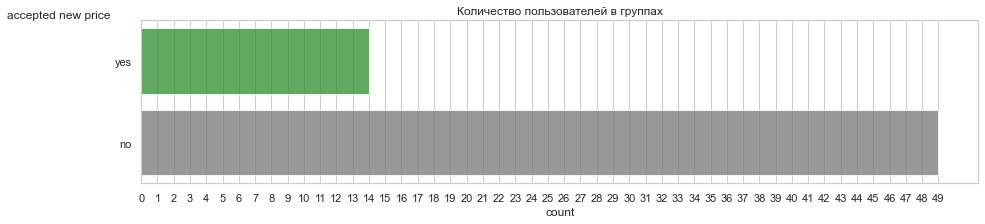

In [273]:
plt.figure(figsize=(15,3))
sns.countplot(data=users_test_premium,y='accepted_new_price', palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.8)
plt.xticks(range(0,50,1))
plt.ylabel('accepted new price',rotation=0, loc='top')
plt.title('Количество пользователей в группах')
plt.show()

Количество пользователей в группах сильно разнится, но имеем, что имеем. При необходимости применим для сравнения бутстрап.

Далее сравним пользователей обеих групп по всем возможным признакам в порядке убывания субъективной оценки вероятности различий в реакции на новые платежные системы.

### Страны/регионы

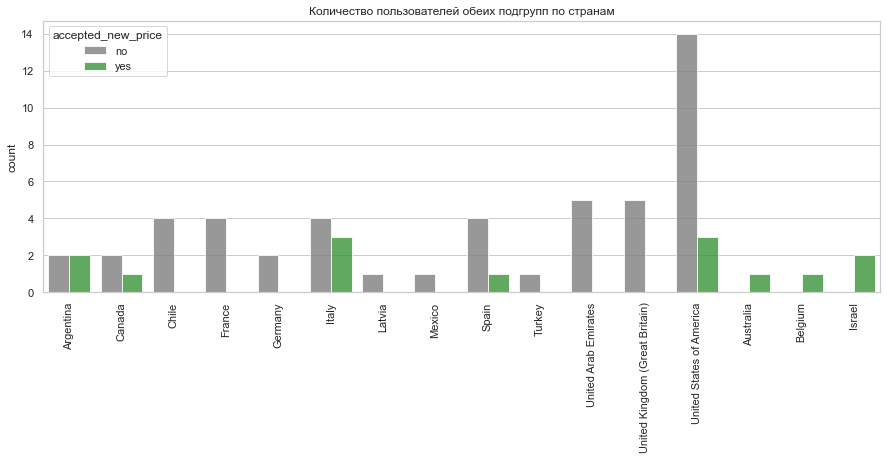

In [274]:
plt.figure(figsize=(15,5))
sns.barplot(data=users_test_premium.groupby(['accepted_new_price','country'], as_index=False)\
            .agg({'uid':'count'}).rename(columns={'uid':'count'}),
            x='country',y='count', hue='accepted_new_price', palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Количество пользователей обеих подгрупп по странам')
plt.xlabel('')
plt.show()

Явное разделение по странам отсутствует. Пользователи полной премиум-подписки в тестовой группе из Австралии, Бельгии и Израиля покупали ее только через новые платежные системы. Однако, их всего 4 в сумме и они из разных регионов, этого заведомо недостаточно, чтобы формировать обоснованные предположения и статистически значимые выводы для всех групп в дальнейшем.

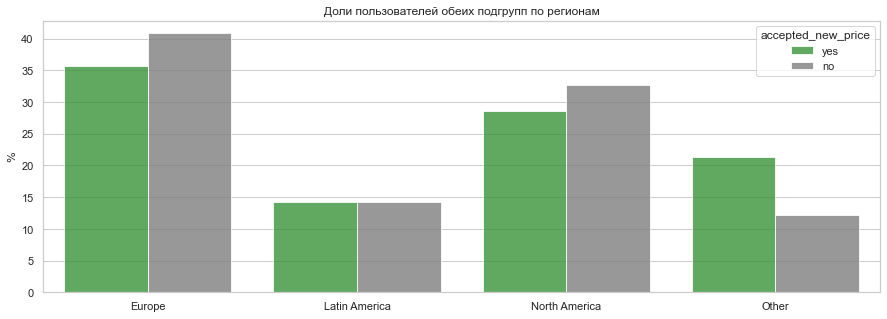

In [275]:
s = users_test_premium.groupby(['accepted_new_price','country_segment'], as_index=False).agg({'uid':'count'})\
.rename(columns={'uid':'count'})
s['%'] = round(s['count'] * 100 / s.groupby('accepted_new_price')['count'].transform('sum'),1)
plt.figure(figsize=(15,5))
sns.barplot(data=s,x='country_segment',y='%', hue='accepted_new_price', hue_order=['yes','no'],
            palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.8)
plt.title('Доли пользователей обеих подгрупп по регионам')
plt.xlabel('')
plt.show()

Пользователи обеих групп есть во всех регионах, примерно в равных пропорциях.

### Пол и возраст

In [276]:
users_test_premium.gender.value_counts(normalize=True)

M    1.0
Name: gender, dtype: float64

Все пользователи обоих групп - мужчины. Рассмотрим данные по возрасту.

In [277]:
users_test_premium.groupby('accepted_new_price', as_index=False)\
.agg({'age':['count','mean','std']}).round(1)

accepted_new_price   age            
                     count  mean   std
0                 no    49  31.7  12.6
1                yes    14  36.1  10.8

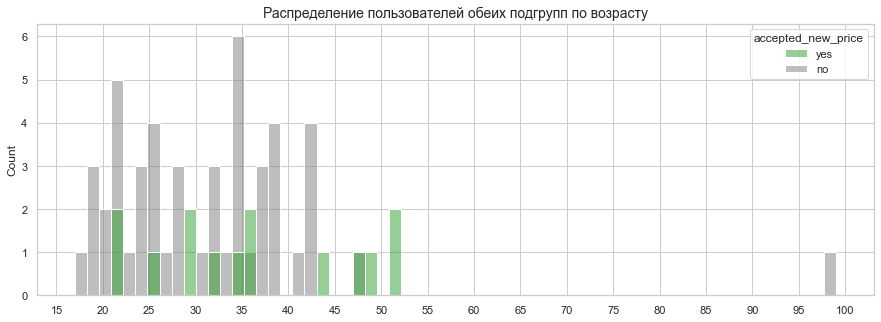

In [278]:
plt.figure(figsize=(15,5))
plt.title('Распределение пользователей обеих подгрупп по возрасту', fontsize=14)
sns.histplot(data=users_test_premium, x='age',hue='accepted_new_price', bins=63,
             palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.5)
plt.xticks(range(15,105,5))
plt.xlabel('')
plt.show()

Исключим аномальное значения возраста больше 55 лет.

In [279]:
users_test_premium.query('age < 55').groupby('accepted_new_price', as_index=False)\
.agg({'age':['count','mean','std']}).round(1)

accepted_new_price   age            
                     count  mean   std
0                 no    48  30.3   8.0
1                yes    14  36.1  10.8

Из-за малого количества наблюдений сравним группы методом бутстрапа.

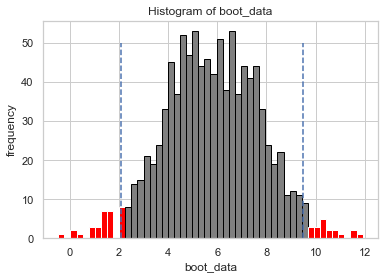

In [280]:
get_bootstrap(users_test_premium.query('accepted_new_price == "yes" and age < 55').age,
              users_test_premium.query('accepted_new_price == "no" and age < 55').age)

In [281]:
get_bootstrap_pvalue(users_test_premium.query('accepted_new_price == "yes" and age < 55').age,
                     users_test_premium.query('accepted_new_price == "no" and age < 55').age)

0.0021258104102477313

P-value на основе бутстрапа сильно ниже порога стат.значимости 0.05, однако следует принять во внимание следующие факты:

1. Для данного исследования была взята часть платящих клиентов тестовой группы, ни о какой экстраполяции результатов на генеральную совокупность пользователей не может идти речи.

2. В группе пользователей, купивших премиум-подписку за новую цену, всего 14 наблюдений. С помощью функции бутстрапа мы моделируем выборку из 48 наблюдений (количество во второй группе за минусом выброса >55 лет). Фактически мы делаем эту новую выборку на основании частот значений иходной выборки, причем в получившейся выборке значения повторяются, новые промежуточные не генерируются. Имея так мало исходных наблюдений мы сильно ограничиваем вариативность значений в бутстрапированной выборке, это значительно отдаляет данные от реальности.

3. Положительным моментом является отсутствие выбросов и равномерность распределения исходных 14 наблюдей.

Таким образом, принимая во внимание "синтетичность" произведенного сравнения средних возрастов методом бутстрапа, результаты данного сравнения не могут быть использованы для фактических выводов, но могут послужить в качестве гипотезы для проведения эксперимента для определенного возрастного диапазона на всех трех группах.

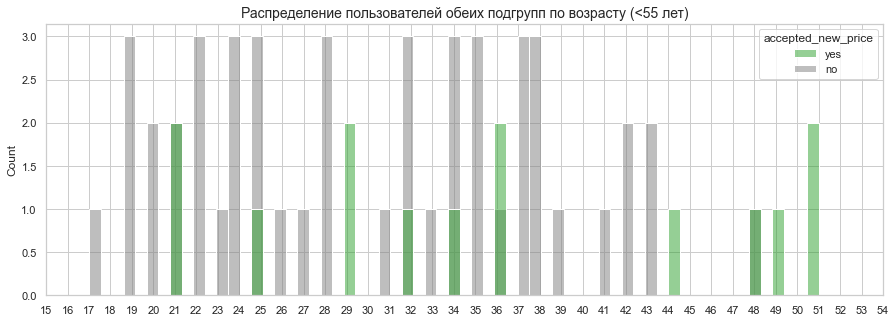

In [282]:
plt.figure(figsize=(15,5))
plt.title('Распределение пользователей обеих подгрупп по возрасту (<55 лет)', fontsize=14)
sns.histplot(data=users_test_premium.query('age < 55'), x='age',hue='accepted_new_price', bins=63,
             palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.5)
plt.xticks(range(15,55,1))
plt.xlabel('')
plt.show()

На распределении возрастов пользователей обеиз подгрупп (<55 лет) видно, что разница в средних достигается засчет возрастного диапазона от 44 лет.

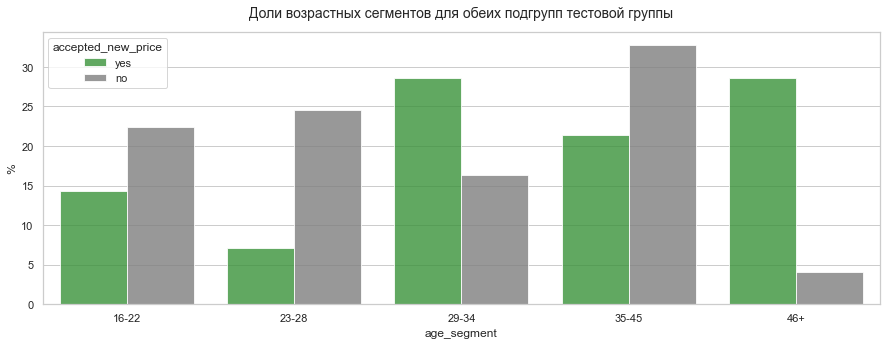

In [283]:
s = users_test_premium.groupby(['accepted_new_price','age_segment'], as_index=False).agg({'uid':'count'})\
.rename(columns={'uid':'count'})
s['%'] = round(s['count'] * 100 / s.groupby('accepted_new_price')['count'].transform('sum'),1)
plt.figure(figsize=(15,5))
sns.barplot(data=s,x='age_segment',y='%', hue='accepted_new_price', hue_order=['yes','no'],
            palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.8)
plt.title('Доли возрастных сегментов для обеих подгрупп тестовой группы', fontsize=14, pad=15)
plt.show()

На графике по ранее выделенным возрастным сегментам заметен сильный перекос доли клиентов сегмента 46+ у оплативших подписку по новой цене, по сравнению с аналогичным сегментом оплативших по старой. Таких клиентов всего 4, фактор случайности велик, однако, проверим гипотезу об успешности изменения цены при оплате через новые платежные системы для пользователей в диапазоне 44-55 лет на всех имеющихся данных 

Средний доход на одного пользователя в данной возрастной группе.

In [284]:
users_clean_full.query('age >= 44 & age <= 55').groupby('group', as_index=False)\
.agg({'total_revenue':['count','mean','std']}).round(1)

group total_revenue               
                     count   mean     std
0  control_1           562  497.5  3212.9
1  control_2           519  548.7  2725.7
2       test           513  396.2  2390.4

Очевидно, гипотеза о повышении данной метрики в в возрастной группе 44-55 лет не подтвердится.

Рассмотрим долю пользователей, купивших полную премиум-подписку

In [285]:
s = users_clean_full.query('age >= 44 & age <= 55').groupby('group', as_index=False)\
.agg({'is_premium_paid':['count','sum']}).round(1)
s.columns = s.columns.droplevel()
s.columns = ['group', 'total', 'premium_paid']
s['%'] = round(s.premium_paid *100 / s.total, 1)
s

,group,total,premium_paid,%
0,control_1,562,7,1.2
1,control_2,519,9,1.7
2,test,513,6,1.2


Также различий не обнаружено.

### Частота посещений, прогнозный доход

In [286]:
users_test_premium.groupby('accepted_new_price', as_index=False)\
.agg({'visits_frequency_adjusted':['count','mean','std'],
      'total_revenue_adjusted':['count','mean','std']}).round(1)

accepted_new_price visits_frequency_adjusted                \
                                         count   mean    std   
0                 no                        49  564.9  296.1   
1                yes                        14  642.9  253.6   

  total_revenue_adjusted                   
                   count     mean     std  
0                     49  11481.6  8431.7  
1                     14  17307.4  7556.4

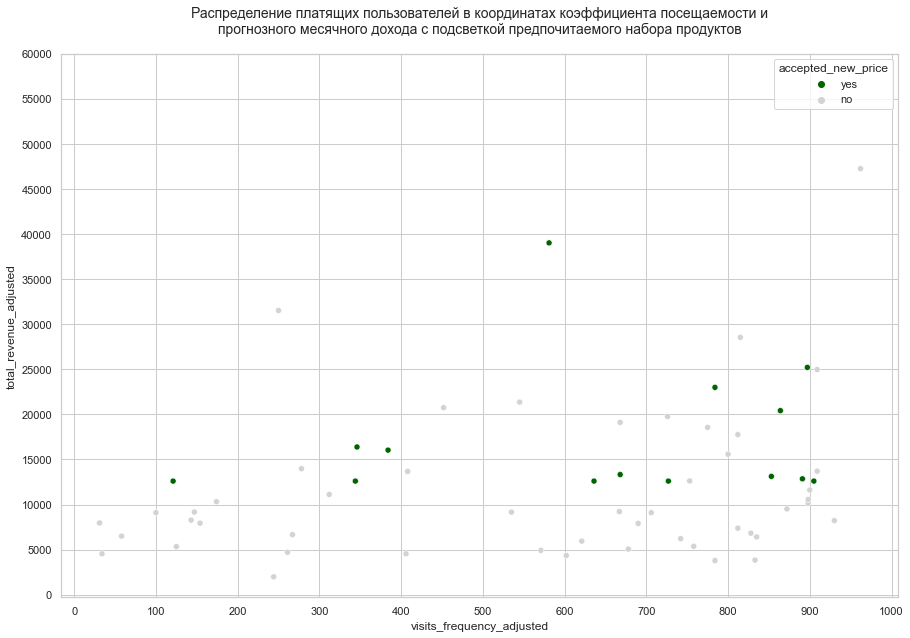

In [287]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=users_test_premium,x='visits_frequency_adjusted',y='total_revenue_adjusted',hue='accepted_new_price',
               palette=['darkgreen','lightgrey'])
plt.title(textwrap.fill('Распределение платящих пользователей в координатах коэффициента посещаемости и \
                        прогнозного месячного дохода с подсветкой предпочитаемого набора продуктов', 88), 
          fontsize=14, pad=20)
plt.yticks(range(0,60001,5000))
plt.xticks(range(0,1001,100))
plt.show()

По коэффициенту посещаемости в целом распределения схожи, по прогнозному доходу пользователи, оплатившие подписку по новой высокой цене, естественно выше, однако в среднем не намного выше цены этой подписки.

### Коэффициент привлекательности

In [288]:
users_test_premium.groupby('accepted_new_price', as_index=False)\
.agg({'attraction_coeff':['count','mean','std']}).round(1)

accepted_new_price attraction_coeff              
                                count   mean    std
0                 no               49  357.2  211.5
1                yes               14  377.9  222.9

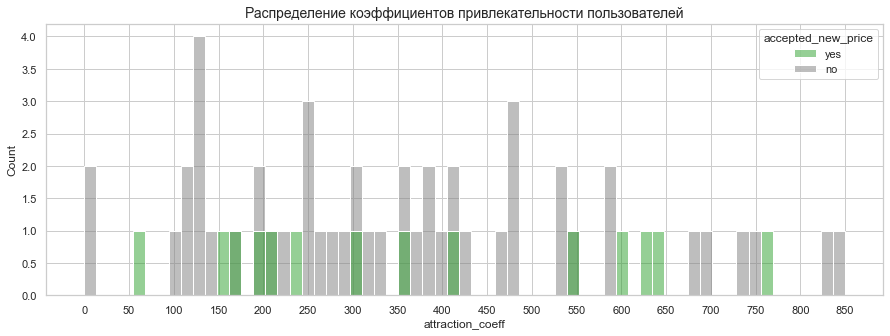

In [289]:
plt.figure(figsize=(15,5))
sns.histplot(data=users_test_premium, x='attraction_coeff',hue='accepted_new_price', bins=63,
             palette={'yes':'tab:green','no':'tab:grey'}, alpha=0.5)
plt.title('Распределение коэффициентов привлекательности пользователей', fontsize=14)
plt.xticks(range(0,900,50))
plt.show()

In [290]:
stats.ttest_ind(users_test_premium.query('accepted_new_price == "yes"').attraction_coeff,
                users_test_premium.query('accepted_new_price == "no"').attraction_coeff,
                equal_var=False)[1]

0.7603121466972276

Статистически значимые различия по коэффициенту привлекательности отсутствуют.

Таким образом, выделить явные отличительные признаки пользователей, купивших премиум-подписку по измененной цене через новые платежные системы, на основании имеющихся данных не удалось. Конкретные группы пользователей, для которых нововведение имело бы смысл, не обнаружены.